### Starbucks Capstone Challenge : Data Analysis and Visualization
Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

Final Advice
Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).


Data Sets
The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
profile.json - demographic data for each customer
transcript.json - records for transactions, offers received, offers viewed, and offers completed
Here is the schema and explanation of each variable in the files:

portfolio.json

id (string) - offer id
offer_type (string) - type of offer ie BOGO, discount, informational
difficulty (int) - minimum required spend to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time for offer to be open, in days
channels (list of strings)
profile.json

age (int) - age of the customer
became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
id (str) - customer id
income (float) - customer's income
transcript.json

event (str) - record description (ie transaction, offer received, offer viewed, etc.)
person (str) - customer id
time (int) - time in hours since start of test. The data begins at time t=0
value - (dict of strings) - either an offer id or transaction amount depending on the record

This is a Capstone Project for Udacity Data Scientist Nano Degree Program.  In this project I will be analyzing simulated data provided by Starbucks about customers and offers.

In [305]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

#import data set
portfolio_df = pd.read_json("portfolio.json", lines = True)
profile_df = pd.read_json("profile.json", lines = True)
transcript_df = pd.read_json("transcript.json", lines = True)

Portfolio data analysis and cleaning:
Portfolio data details:
1. id (string) - offer id 
2. offer_type (string) - type of offer ie BOGO, discount, informational 
3. difficulty (int) - minimum required spend to complete an offer 
4. reward (int) - reward given for completing an offer 
5. duration (int) - time for offer to be open, in days 
6. channels (list of strings)


In [124]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Cleaning Portfolio dataset
Actions:
1. replace channels column with 4 columns representing each communication channel (web, email, mobile, social) 
2. replace offer id with easily understandable number format
3. change unit of measurement for duration to hours from days
4. rename id column to offer_id
5. Rename reward to 'offer reward'

In [125]:
#1. creating columns for each channel and replacing channels column
portfolio_df = portfolio_df.drop('channels', axis=1).join(portfolio_df.channels.str.join('|').str.get_dummies())

#2. create unique values for each offerID and store in a dictionary for use in other datasets
offer_id = list(portfolio_df['id'])
value_id = list(range(1,11,1))
offer_id_dict = {offer_id[i]: int(value_id[i]) for i in range(len(value_id))}                              
portfolio_df['id'] = portfolio_df['id'].map(offer_id_dict)

#3. change unit for duration to hours
portfolio_df['duration'] = portfolio_df['duration'] * 24

#4. rename id coulmn to offer_id
portfolio_df = portfolio_df.rename(columns = {'id': 'offer_id'})

#5. rename reward coulmn to offer_reward
portfolio_df = portfolio_df.rename(columns = {'reward': 'offer_reward'})


In [126]:
#cleaned portfolio dataset
portfolio_df.head(10)

offer_reward  difficulty  duration     offer_type  offer_id  email  mobile  \
0            10          10       168           bogo         1      1       1   
1            10          10       120           bogo         2      1       1   
2             0           0        96  informational         3      1       1   
3             5           5       168           bogo         4      1       1   
4             5          20       240       discount         5      1       0   
5             3           7       168       discount         6      1       1   
6             2          10       240       discount         7      1       1   
7             0           0        72  informational         8      1       1   
8             5           5       120           bogo         9      1       1   
9             2          10       168       discount        10      1       1   

   social  web  
0       1    0  
1       1    1  
2       0    1  
3       0    1  
4       0    1  
5       1    1  
6       1    1  
7       1    0  
8       1    1  
9       0    1

Profile data analysis and cleaning
Profile data details:
1. gender: (categorical) M, F, O, or null
2. age: (numeric) missing value encoded as 118
3. id: (string/hash)
4. became_member_on: (date) format YYYYMMDD
5. income: (numeric)

In [127]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Cleaning Profile dataset
Actions:
1. Here we can see that gender and income has 2175 missing values, also missing values for age has been encoded as 118(if we count these it comes out to be exactly 2175, so it is safe to assume that it is for entries who have missing gender and income). We will remove these values. We will check if our assumption is right before deleting the entries
2. replace offer id with easily understandable number format
3. replace became_member_on column with member_for column indicating for how many monhts the custer is a member
4. rename id column to member_id

In [128]:
#here we see that for age = 118 there is no value in gender and income so our assumption was right, we will delete these entries
profile_df[profile_df['age'] == 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [129]:
#1. delete all members with Nan as income
profile_df.dropna(subset = ["income"], inplace=True)

#2. create unique values for each member id and store in a dictionary for use in other datasets
profile_id = list(profile_df['id'])
member_id = list(range(1,14826,1))
profile_id_dict = {profile_id[i]: int(member_id[i]) for i in range(len(member_id))}                              
profile_df['id'] = profile_df['id'].map(profile_id_dict)

#3. replace became_member_on column with member_for column indicating for how many monhts the custer is a member
profile_df['became_member_on']= profile_df['became_member_on'].astype(str)
profile_df['member_date'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')
today = pd.to_datetime ('today')
profile_df['member_for_months']  = ((today - profile_df.member_date)/np.timedelta64(1, 'M'))
profile_df['member_for_months'] = profile_df['member_for_months'].astype(int)
profile_df= profile_df.drop(['became_member_on','member_date'], axis = 1)
#4. rename id column to member_id
profile_df = profile_df.rename(columns = {'id': 'member_id'})

Exploratory data analysis for profile dataset

Text(0.5, 1.0, 'Income Histogram')

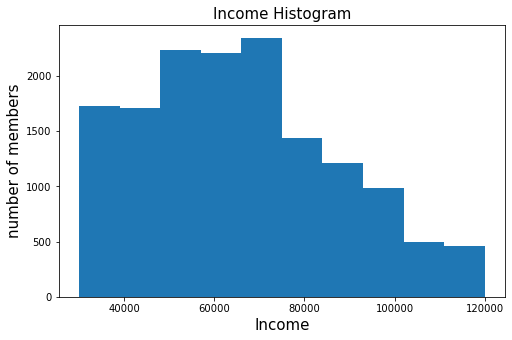

In [130]:
#income distribution for members
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile_df['income'], 10)
plt.xlabel('Income')
plt.ylabel('number of members')
plt.title('Income Histogram')

In [131]:
#income range
profile_df.describe()

age     member_id         income  member_for_months
count  14825.000000  14825.000000   14825.000000       14825.000000
mean      54.393524   7413.000000   65404.991568          45.507386
std       17.383705   4279.753206   21598.299410          13.775622
min       18.000000      1.000000   30000.000000          28.000000
25%       42.000000   3707.000000   49000.000000          35.000000
50%       55.000000   7413.000000   64000.000000          40.000000
75%       66.000000  11119.000000   80000.000000          55.000000
max      101.000000  14825.000000  120000.000000          88.000000

Text(0.5, 1.0, 'Age Histogram')

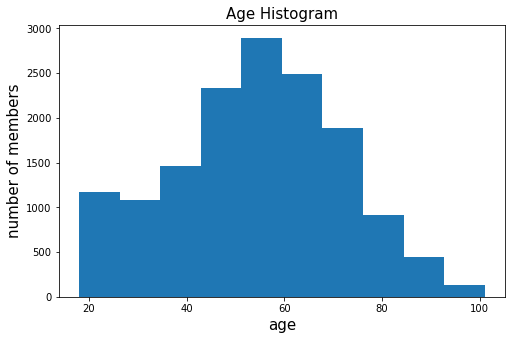

In [132]:
#Age distribution for members
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile_df['age'], 10)
plt.xlabel('age')
plt.ylabel('number of members')
plt.title('Age Histogram')

In [133]:
#correlation between Age and income
profile_df['age'].corr(profile_df['income'])
#there is not correlation between age and income

0.30670278856125516

Text(0.5, 1.0, 'Distribution of members, when they joined the app ')

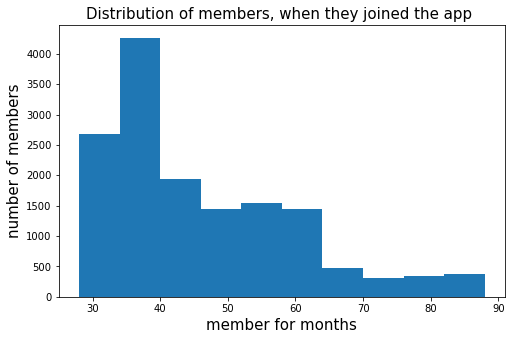

In [134]:
#distribution for members loyalty based in number of month when they joined the app
fig, ax = plt.subplots(figsize = (8,5))
plt.hist(profile_df['member_for_months'], 10)
plt.xlabel('member for months')
plt.ylabel('number of members')
plt.title('Distribution of members, when they joined the app ')

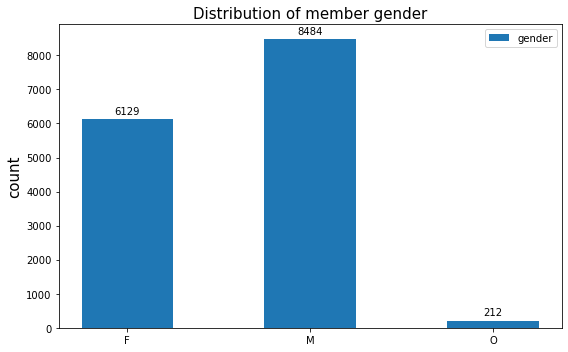

In [135]:
#gender distribution for members
gender = profile_df.groupby('gender')['member_id'].count()
gender_cat = profile_df.gender.unique()
x = np.arange(len(gender_cat))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots(figsize = (8,5))
rects1 = ax.bar(x, gender, width, label='gender')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('Distribution of member gender')
ax.set_xticks(x)
ax.set_xticklabels(gender_cat, rotation = 0)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=15, labelsize=15)
plt.rc('font', size=10)
autolabel(rects1)
fig.tight_layout()
plt.show()

#### More Data cleaning:(categorize age, income and loyalty years based on 4 quartiles)
5. divide age in 4 groups: 1. young , 2. middle, 3. senior, 4. old
6. divide income in 4 groups 1. lower, 2. avg , 3. above_avg, 4.rich
7. divide loyalty in 4 groups 1. very_recent, 2 recent , 3. seasoned, 4.vintage

In [136]:
#5. Divide loyalty categories

for i in range(len(profile_df['member_for_months'])):
    if profile_df['member_for_months'].iloc[i] < 35:
        profile_df['member_for_months'].iloc[i] = 'very_recent'
    elif profile_df['member_for_months'].iloc[i] < 40:
        profile_df['member_for_months'].iloc[i] = 'recent'
    elif profile_df['member_for_months'].iloc[i] < 54:
        profile_df['member_for_months'].iloc[i] = 'seasoned'
    else:
        profile_df['member_for_months'].iloc[i] = 'vintage'

profile_df = profile_df.rename(columns = {'member_for_months': 'loyalty'})

#5. Divide age categories
for i in range(len(profile_df['age'])):
    if profile_df['age'].iloc[i] < 42:
        profile_df['age'].iloc[i] = 'young'
    elif profile_df['age'].iloc[i] < 55:
        profile_df['age'].iloc[i] = 'middle'
    elif profile_df['age'].iloc[i] < 66:
        profile_df['age'].iloc[i] = 'senior'
    else:
        profile_df['age'].iloc[i] = 'old'

#6 Divide income in 4 categories
for i in range(len(profile_df['income'])):
    if profile_df['income'].iloc[i] < 49000:
        profile_df['income'].iloc[i] = 'lower'
    elif profile_df['income'].iloc[i] < 64000:
        profile_df['income'].iloc[i] = 'avg'
    elif profile_df['income'].iloc[i] < 80000:
        profile_df['income'].iloc[i] = 'above_avg'
    else:
        profile_df['income'].iloc[i] = 'rich'


C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [137]:
#cleaned profile dataset
profile_df.head()

gender     age  member_id     income      loyalty
1       F  senior          1       rich     seasoned
3       F     old          2       rich     seasoned
5       M     old          3  above_avg  very_recent
8       M  senior          4        avg  very_recent
12      M  senior          5        avg       recent

Transcript data Analysis and cleaning:

1. person: (string/hash)
2. event: (string) offer received, offer viewed, transaction, offer completed value: (dictionary) different values depending on event type
3. Value:
    1. offer id: (string/hash) not associated with any "transaction"
    2. amount: (numeric) money spent in "transaction"
    3. reward: (numeric) money gained from "offer completed" 
4. time: (numeric) hours after start of test

In [138]:
transcript_df.head(10)

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   
5  389bc3fa690240e798340f5a15918d5c  offer received   
6  c4863c7985cf408faee930f111475da3  offer received   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received   
9  31dda685af34476cad5bc968bdb01c53  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
5  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
6  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}     0  
7  {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
9  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0

Cleaning transcript dataset:
1. replace person column name with member_id and map values form member_id_dict
2. replace value column with 3 columns(offer_id, amount and reward) and put respective values in the columns. map offer_id with offer_id_dict 

In [139]:
#1. replace person with member id from profile data set, using profile_id_dict
transcript_df['person'] = transcript_df['person'].map(profile_id_dict)
transcript_df.dropna(subset = ['person'], inplace = True)
transcript_df = transcript_df.rename(columns = {'person': 'member_id'})

#2. Create one column for each event type and put offerId , transaction amount or offer received amount in the column as value
transcript_df['offer_id'] = transcript_df['value'].apply(lambda x: x.get('offer_id'))
transcript_df['offer id'] = transcript_df['value'].apply(lambda x: x.get('offer id'))
#merge the 'offer_id' and 'offer id' columns
transcript_df['transaction_amount'] = transcript_df['value'].apply(lambda x: x.get('amount'))
transcript_df['transaction_reward'] = transcript_df['value'].apply(lambda x: x.get('reward'))
transcript_df['offer_id'] = transcript_df.apply(lambda x: x['offer id'] if x['offer_id'] == None else x['offer_id'], axis = 1)
transcript_df = transcript_df.drop(['value', 'offer id'], axis = 1)
transcript_df.fillna(0, inplace = True)
transcript_df['offer_id'] = transcript_df['offer_id'].map(offer_id_dict)
transcript_df.fillna(0, inplace = True)


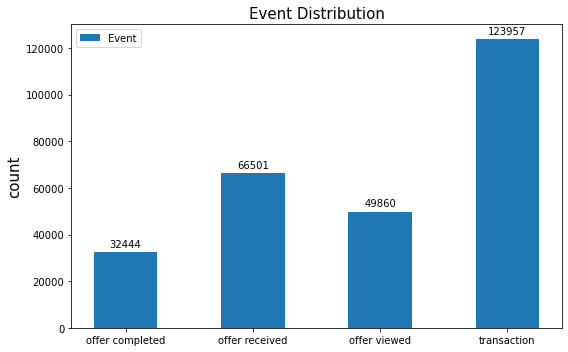

In [140]:
#Exploratory analysis for Transaction data
#Distribution of Events for all transaction dataset
events= transcript_df.groupby('event')['member_id'].count()
event_name = np.sort(transcript_df.event.unique())
x = np.arange(len(event_name))  # the label locations
width = 0.50  # the width of the bars
fig, ax = plt.subplots(figsize = (8,5))
rects1 = ax.bar(x, events, width, label='Event')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('Event Distribution')
ax.set_xticks(x)
ax.set_xticklabels(event_name, rotation = 0)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.rc('axes', titlesize=15, labelsize=15)
plt.rc('font', size=10)
autolabel(rects1)
fig.tight_layout()
plt.show()

An offer is successful only if it is received by member, viewed by member within time duration and completed by member in time duration. if an offer is not viewed by member but he/she still makes purchases and completes the offer then that offer is not successful.

In [141]:
transcript_df.head()

member_id           event  time  offer_id  transaction_amount  \
0        2.0  offer received     0       4.0                 0.0   
2        3.0  offer received     0      10.0                 0.0   
5        4.0  offer received     0       9.0                 0.0   
7        5.0  offer received     0       3.0                 0.0   
8        6.0  offer received     0       5.0                 0.0   

   transaction_reward  
0                 0.0  
2                 0.0  
5                 0.0  
7                 0.0  
8                 0.0

In [142]:
#lets merge the three datasets into one
#row which are specific to transaction events will not have any value in the coulmns pertaining to offer details, 
#we will impute them later if required
final_df = pd.merge(transcript_df, profile_df , on ='member_id')
final_df = pd.merge(final_df, portfolio_df , how='left', on ='offer_id')
final_df

member_id            event  time  offer_id  transaction_amount  \
0             2.0   offer received     0       4.0                0.00   
1             2.0     offer viewed     6       4.0                0.00   
2             2.0      transaction   132       0.0               19.89   
3             2.0  offer completed   132       4.0                0.00   
4             2.0      transaction   144       0.0               17.78   
...           ...              ...   ...       ...                 ...   
272757    14080.0     offer viewed   504       3.0                0.00   
272758    14080.0   offer received   576       2.0                0.00   
272759    14080.0     offer viewed   576       2.0                0.00   
272760    10391.0   offer received   576       2.0                0.00   
272761    10391.0     offer viewed   576       2.0                0.00   

        transaction_reward gender     age     income   loyalty  offer_reward  \
0                      0.0      F     old       rich  seasoned           5.0   
1                      0.0      F     old       rich  seasoned           5.0   
2                      0.0      F     old       rich  seasoned           NaN   
3                      5.0      F     old       rich  seasoned           5.0   
4                      0.0      F     old       rich  seasoned           NaN   
...                    ...    ...     ...        ...       ...           ...   
272757                 0.0      M  middle       rich    recent           0.0   
272758                 0.0      M  middle       rich    recent          10.0   
272759                 0.0      M  middle       rich    recent          10.0   
272760                 0.0      F  senior  above_avg  seasoned          10.0   
272761                 0.0      F  senior  above_avg  seasoned          10.0   

        difficulty  duration     offer_type  email  mobile  social  web  
0              5.0     168.0           bogo    1.0     1.0     0.0  1.0  
1              5.0     168.0           bogo    1.0     1.0     0.0  1.0  
2              NaN       NaN            NaN    NaN     NaN     NaN  NaN  
3              5.0     168.0           bogo    1.0     1.0     0.0  1.0  
4              NaN       NaN            NaN    NaN     NaN     NaN  NaN  
...            ...       ...            ...    ...     ...     ...  ...  
272757         0.0      96.0  informational    1.0     1.0     0.0  1.0  
272758        10.0     120.0           bogo    1.0     1.0     1.0  1.0  
272759        10.0     120.0           bogo    1.0     1.0     1.0  1.0  
272760        10.0     120.0           bogo    1.0     1.0     1.0  1.0  
272761        10.0     120.0           bogo    1.0     1.0     1.0  1.0  

[272762 rows x 18 columns]

In [143]:
#creating a copy of final_df on which we will be doing all the analysis work
final_df1 = final_df.copy()

In [144]:
final_df1

member_id            event  time  offer_id  transaction_amount  \
0             2.0   offer received     0       4.0                0.00   
1             2.0     offer viewed     6       4.0                0.00   
2             2.0      transaction   132       0.0               19.89   
3             2.0  offer completed   132       4.0                0.00   
4             2.0      transaction   144       0.0               17.78   
...           ...              ...   ...       ...                 ...   
272757    14080.0     offer viewed   504       3.0                0.00   
272758    14080.0   offer received   576       2.0                0.00   
272759    14080.0     offer viewed   576       2.0                0.00   
272760    10391.0   offer received   576       2.0                0.00   
272761    10391.0     offer viewed   576       2.0                0.00   

        transaction_reward gender     age     income   loyalty  offer_reward  \
0                      0.0      F     old       rich  seasoned           5.0   
1                      0.0      F     old       rich  seasoned           5.0   
2                      0.0      F     old       rich  seasoned           NaN   
3                      5.0      F     old       rich  seasoned           5.0   
4                      0.0      F     old       rich  seasoned           NaN   
...                    ...    ...     ...        ...       ...           ...   
272757                 0.0      M  middle       rich    recent           0.0   
272758                 0.0      M  middle       rich    recent          10.0   
272759                 0.0      M  middle       rich    recent          10.0   
272760                 0.0      F  senior  above_avg  seasoned          10.0   
272761                 0.0      F  senior  above_avg  seasoned          10.0   

        difficulty  duration     offer_type  email  mobile  social  web  
0              5.0     168.0           bogo    1.0     1.0     0.0  1.0  
1              5.0     168.0           bogo    1.0     1.0     0.0  1.0  
2              NaN       NaN            NaN    NaN     NaN     NaN  NaN  
3              5.0     168.0           bogo    1.0     1.0     0.0  1.0  
4              NaN       NaN            NaN    NaN     NaN     NaN  NaN  
...            ...       ...            ...    ...     ...     ...  ...  
272757         0.0      96.0  informational    1.0     1.0     0.0  1.0  
272758        10.0     120.0           bogo    1.0     1.0     1.0  1.0  
272759        10.0     120.0           bogo    1.0     1.0     1.0  1.0  
272760        10.0     120.0           bogo    1.0     1.0     1.0  1.0  
272761        10.0     120.0           bogo    1.0     1.0     1.0  1.0  

[272762 rows x 18 columns]

Exploratory data analysis of this merged dataset

Total transaction done in one months time by members in various age groups and income groups
age            young     middle     senior        old
income                                               
above_avg   95641.06  120239.60  128738.68  129320.40
avg        107340.46   94493.39   78664.96   82635.85
lower      101294.01   48111.04   44760.58   46480.11
rich        25140.62  155364.09  224904.90  251812.65
----------------------------------------------------
Count of members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg    795     953     961  1013
avg         1111     957     819   875
lower       1454     799     658   713
rich         131     938    1263  1385
-----------------------------------------------------
Per person spent on starbucks by app members in various age groups and income groups
age        young  middle  senior    old
income                                 
above_avg  120.0   1

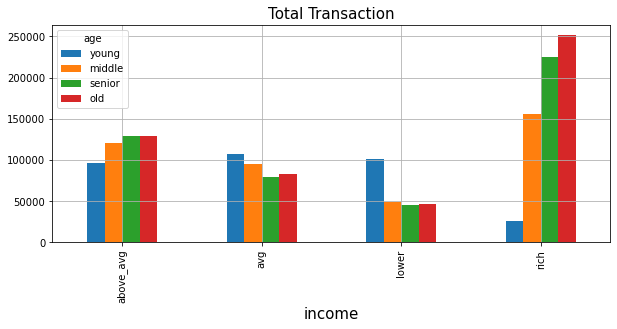

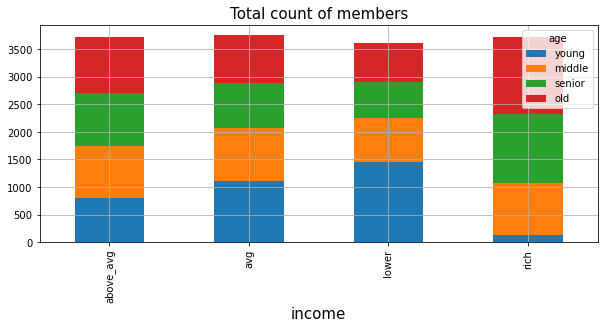

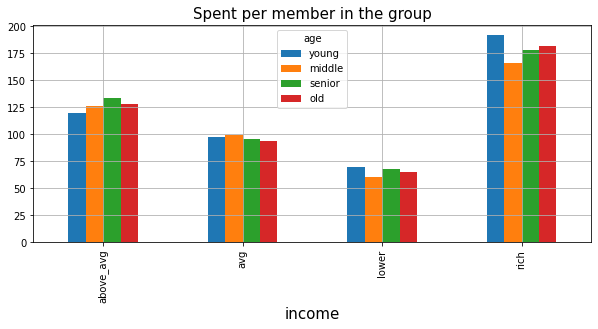

In [145]:
#Demographic data on which group of member make most transaction
#based on income and age
print("Total transaction done in one months time by members in various age groups and income groups")
income_expend = final_df1.groupby(['income', 'age'])['transaction_amount'].sum().unstack()
income_expend = income_expend[['young', 'middle', 'senior', 'old']]
income_expend.plot.bar(figsize=(10,4), title="Total Transaction", grid=True)
print(income_expend)
print("----------------------------------------------------")
print("Count of members in various age groups and income groups")
demo_count = profile_df.groupby(['income', 'age'])['member_id'].count().unstack()
demo_count = demo_count[['young', 'middle', 'senior', 'old']]
demo_count.plot.bar(stacked=True , figsize=(10,4), title="Total count of members", grid=True)
print(demo_count)
print('-----------------------------------------------------')
print("Per person spent on starbucks by app members in various age groups and income groups")
#expenditure per member
exp_per_member = np.round(income_expend/demo_count , decimals = 0)
print(exp_per_member)
exp_per_member.plot.bar(figsize=(10,4), title="Spent per member in the group", grid=True)

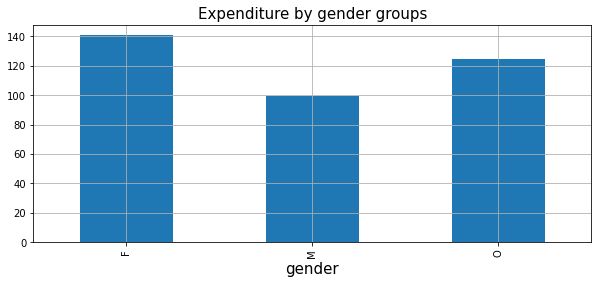

In [146]:
# Expenditure done by various groups different genders 
gender_expense = final_df1.groupby('gender')['transaction_amount'].sum()
gender_count = profile_df.groupby('gender')['member_id'].count()
per_person_gender_expense= gender_expense/gender_count
per_person_gender_expense.plot.bar(figsize=(10,4), title="Expenditure by gender groups", grid=True)
#Females tend to expend more by 40% compared to males

Total transaction done in one months time by members in various age groups and gender groups
age            young     middle     senior        old
income                                               
above_avg   95641.06  120239.60  128738.68  129320.40
avg        107340.46   94493.39   78664.96   82635.85
lower      101294.01   48111.04   44760.58   46480.11
rich        25140.62  155364.09  224904.90  251812.65
----------------------------------------------------
Count of members in various age groups and gender groups
age        young  middle  senior   old
income                                
above_avg    795     953     961  1013
avg         1111     957     819   875
lower       1454     799     658   713
rich         131     938    1263  1385
-----------------------------------------------------
Per person spent on starbucks by app members in various age groups and gender groups
age     young  middle  senior    old
gender                              
F       126.0   141.0   14

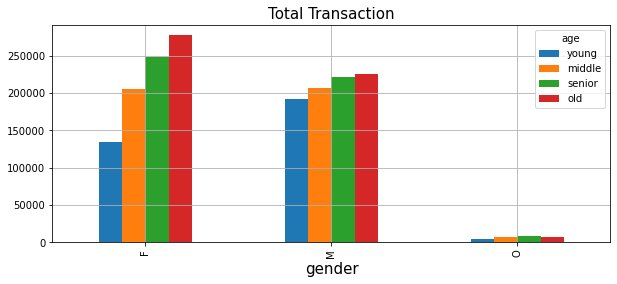

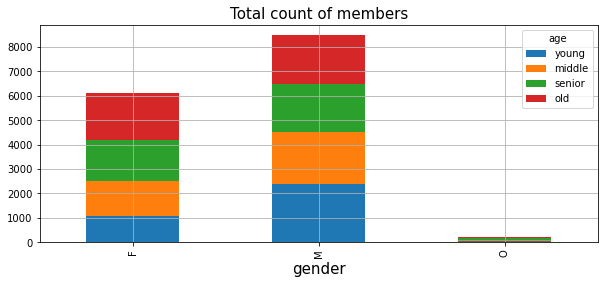

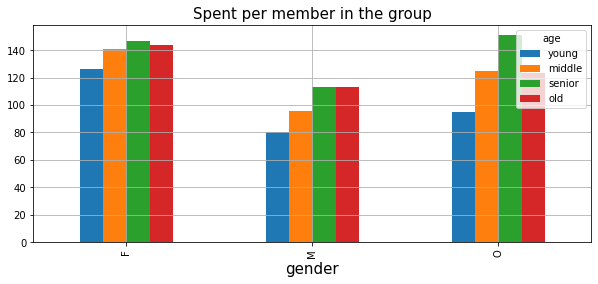

In [147]:
#Demographic data on which group of member make most transaction
#based on gender and age
print("Total transaction done in one months time by members in various age groups and gender groups")
gender_expend = final_df1.groupby(['gender', 'age'])['transaction_amount'].sum().unstack()
gender_expend = gender_expend[['young', 'middle', 'senior', 'old']]
gender_expend.plot.bar(figsize=(10,4), title="Total Transaction", grid=True)
print(income_expend)
print("----------------------------------------------------")
print("Count of members in various age groups and gender groups")
gender_count = profile_df.groupby(['gender', 'age'])['member_id'].count().unstack()
gender_count = gender_count[['young', 'middle', 'senior', 'old']]
gender_count.plot.bar(stacked=True , figsize=(10,4), title="Total count of members", grid=True)
print(demo_count)
print('-----------------------------------------------------')
print("Per person spent on starbucks by app members in various age groups and gender groups")
#expenditure per member
exp_per_member_gender_age = np.round(gender_expend/gender_count , decimals = 0)
print(exp_per_member_gender_age)
exp_per_member_gender_age.plot.bar(figsize=(10,4), title="Spent per member in the group", grid=True)

Which demography group views the offers that they get in app, this wont reflect if the user saw the add on time. But this will give a decent Idea about which group is more active on the app

Total offer recieved by members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg   3603    4235    4338  4473
avg         4989    4279    3728  3961
lower       6556    3558    2944  3198
rich         594    4151    5712  6182
----------------------------------------------------
Total offer viewed by members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg   2617    3437    3359  3433
avg         3592    3443    2974  3187
lower       4527    2373    2017  2197
rich         563    3277    4271  4593
-----------------------------------------------------
Percentage of offers viewed by app members in various age groups and income groups
age        young  middle  senior    old
income                                 
above_avg  72.63   81.16   77.43  76.75
avg        72.00   80.46   79.77  80.46
lower      69.05   66.69   68.51  68.70


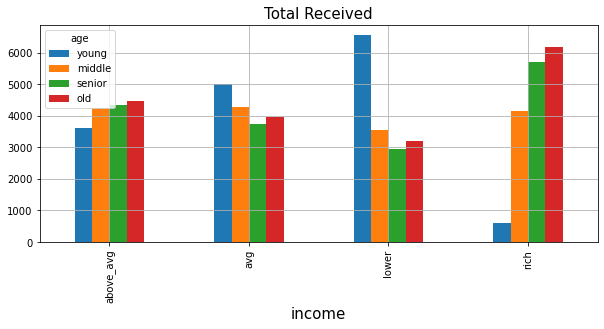

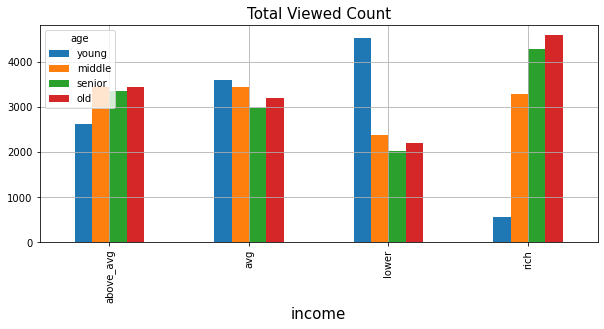

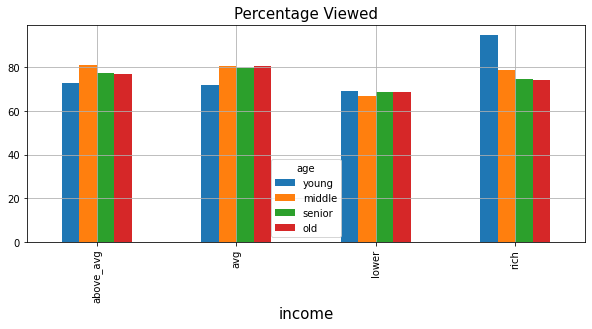

In [148]:
offer_viewed = final_df1[final_df1['event'] == 'offer viewed']
offer_received = final_df1[final_df1['event'] == 'offer received']
print("Total offer recieved by members in various age groups and income groups")
received = offer_received.groupby(['income', 'age'])['member_id'].count().unstack()
received = received[['young', 'middle', 'senior', 'old']]
received.plot.bar(figsize=(10,4), title="Total Received", grid=True)
print(received)
print("----------------------------------------------------")
print("Total offer viewed by members in various age groups and income groups")
view = offer_viewed.groupby(['income', 'age'])['member_id'].count().unstack()
view = view[['young', 'middle', 'senior', 'old']]
view.plot.bar(figsize=(10,4), title="Total Viewed Count", grid=True)
print(view)
print('-----------------------------------------------------')
print("Percentage of offers viewed by app members in various age groups and income groups")
#expenditure per member
percentage_view = np.round((view/received) * 100 , decimals = 2)
print(percentage_view)
percentage_view.plot.bar(figsize=(10,4), title="Percentage Viewed", grid=True)

Which demography group completes the offers that they get in app and view it, this wont reflect if the user viewed the offer on time. But this will give a decent Idea about which group is more active on the app

Total offer completed by members in various age groups and income groups
age        young  middle  senior   old
income                                
above_avg   1629    2243    2442  2381
avg         2195    2012    1727  1828
lower       2367    1219    1039  1156
rich         361    2505    3506  3834
-----------------------------------------------------
Percentage of offers completed which were viewed by app members in various age groups and income groups


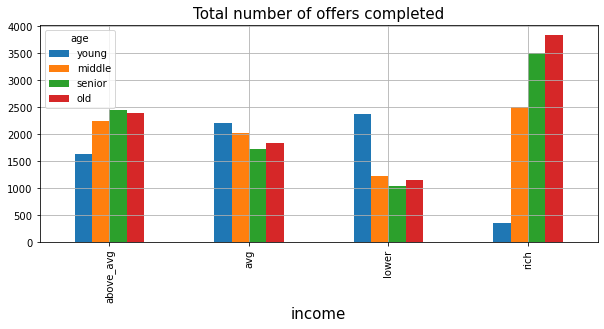

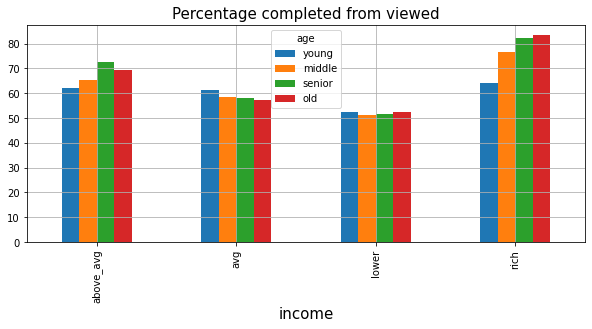

In [149]:
offer_completed = final_df1[final_df1['event'] == 'offer completed']
print("Total offer completed by members in various age groups and income groups")
completed = offer_completed.groupby(['income', 'age'])['member_id'].count().unstack()
completed = completed[['young', 'middle', 'senior', 'old']]
completed.plot.bar(figsize=(10,4), title="Total number of offers completed", grid=True)
print(completed)
print('-----------------------------------------------------')
print("Percentage of offers completed which were viewed by app members in various age groups and income groups")
#expenditure per member
percentage_view_complete = np.round((completed/view) * 100 , decimals = 2)
percentage_view_complete
percentage_view_complete.plot.bar(figsize=(10,4), title="Percentage completed from viewed", grid=True)


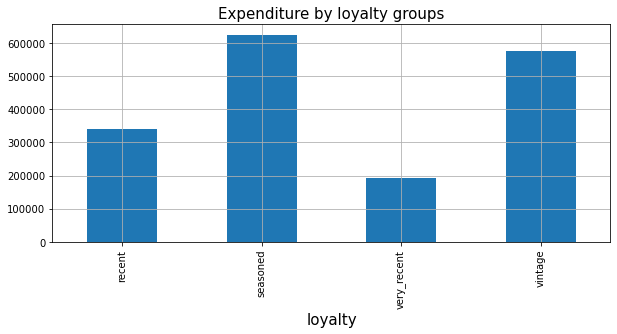

In [150]:
expenditure_loyalty = final_df1.groupby(['loyalty'])['transaction_amount'].sum()
expenditure_loyalty.plot.bar(figsize = (10,4), title= "Expenditure by loyalty groups" , grid=True)

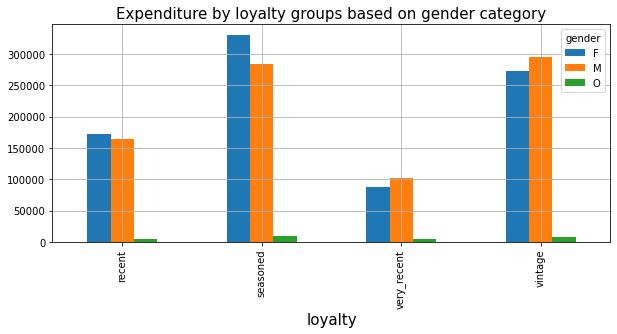

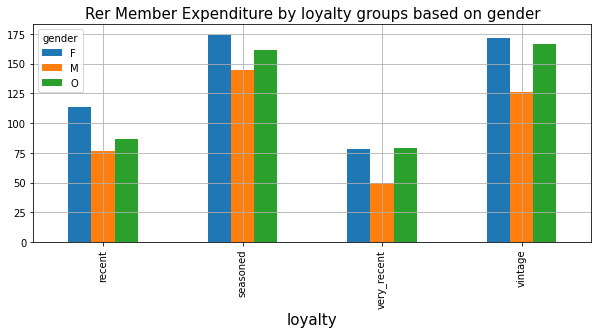

In [151]:
#transaction details based loyalty and gender 
loyalty_expense = final_df1.groupby(['loyalty', 'gender'])['transaction_amount'].sum().unstack()
loyalty_expense.plot.bar(figsize = (10,4), title= "Expenditure by loyalty groups based on gender category" , grid=True)
gender_count_loyalty = profile_df.groupby(['loyalty', 'gender'])['member_id'].count().unstack()
per_loyalty_gender_expense = np.round(loyalty_expense/gender_count_loyalty , decimals = 2)
per_loyalty_gender_expense.plot.bar(figsize=(10,4), title="Rer Member Expenditure by loyalty groups based on gender", grid=True)

age              young     middle     senior        old
loyalty                                                
recent        70077.45   78973.80   92611.78   99122.86
seasoned     110110.88  148915.22  172491.54  192769.46
very_recent   44750.86   44612.49   51006.46   53224.72
vintage      104476.96  145706.61  160959.34  165131.97

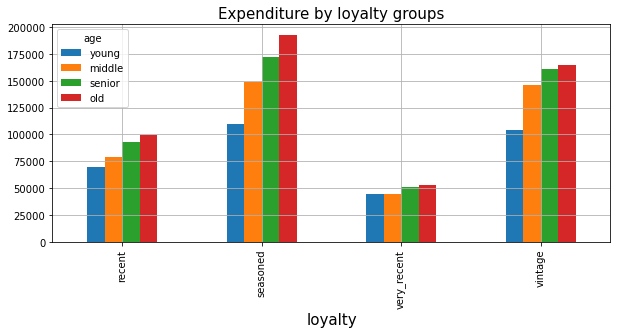

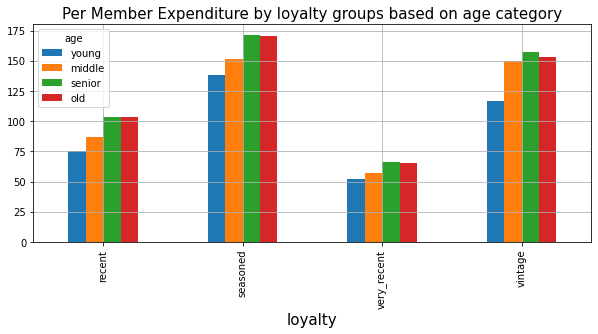

In [152]:
#transaction details based loyalty and age 
loyalty_expense = final_df1.groupby(['loyalty', 'age'])['transaction_amount'].sum().unstack()
loyalty_expense = loyalty_expense[['young', 'middle', 'senior', 'old']]
loyalty_expense.plot.bar(figsize=(10,4), title="Expenditure by loyalty groups", grid=True)
age_count_loyalty = profile_df.groupby(['loyalty', 'age'])['member_id'].count().unstack()
age_count_loyalty = age_count_loyalty[['young', 'middle', 'senior', 'old']]
per_loyalty_age_expense = np.round(loyalty_expense/age_count_loyalty , decimals = 2)
per_loyalty_age_expense.plot.bar(figsize=(10,4), title="Per Member Expenditure by loyalty groups based on age category", grid=True)

loyalty_expense

Before we dive into which offers were completed properly and which were not. Lets do some analysis on which type of offer is prefered by which member demography most. We will do this one by one for all four : 1. Income , 2, gender, 3 Age and 4. Loyalty

In [153]:
#By Gender
#offer_completed
offers_gender = offer_completed.groupby(['gender', 'offer_type'])['member_id'].count().unstack()
offers_gender

offer_type  bogo  discount
gender                    
F           7501      7976
M           7512      8954
O            245       256

In [154]:
gender_count= profile_df.groupby('gender')['gender'].count()

In [155]:
#per member bogo and discount offers used
y = offers_gender['discount']/gender_count
x = offers_gender['bogo']/gender_count
print(x, y)

gender
F    1.223854
M    0.885431
O    1.155660
dtype: float64 gender
F    1.301354
M    1.055398
O    1.207547
dtype: float64


In [156]:
#Offer completion percentage for various offers
#number of offers sent
offers = transcript_df.groupby(['offer_id', 'event'])['member_id'].count().unstack()
offers = offers.drop(['transaction'], axis = 1)
offers = offers.drop(index =0 )

In [157]:
offers['view_perc'] = np.round(((offers['offer viewed']/offers['offer received']) * 100), decimals = 1)
offers['complete_perc'] = np.round(((offers['offer completed']/offers['offer received']) * 100), decimals = 1)
offers

event     offer completed  offer received  offer viewed  view_perc  \
offer_id                                                             
1.0                3657.0          6683.0        5901.0       88.3   
2.0                3310.0          6593.0        6329.0       96.0   
3.0                   NaN          6657.0        3487.0       52.4   
4.0                4188.0          6685.0        3499.0       52.3   
5.0                3386.0          6726.0        2215.0       32.9   
6.0                4886.0          6655.0        6379.0       95.9   
7.0                5003.0          6652.0        6407.0       96.3   
8.0                   NaN          6643.0        5873.0       88.4   
9.0                4103.0          6576.0        6310.0       96.0   
10.0               3911.0          6631.0        3460.0       52.2   

event     complete_perc  
offer_id                 
1.0                54.7  
2.0                50.2  
3.0                 NaN  
4.0                62.6  
5.0                50.3  
6.0                73.4  
7.0                75.2  
8.0                 NaN  
9.0                62.4  
10.0               59.0

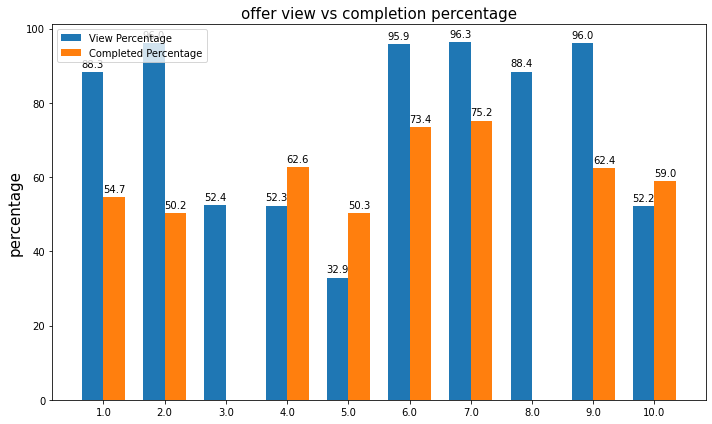

In [158]:
offer_idss = offers.index
x = np.arange(len(offer_idss))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2 , offers['view_perc'], width, label='View Percentage')
rects2 = ax.bar(x + width/2 , offers['complete_perc'], width, label='Completed Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('percentage')
ax.set_title('offer view vs completion percentage')
ax.set_xticks(x)
ax.set_xticklabels(offer_idss, rotation = 0)
ax.legend()
def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

plt.rc('axes', titlesize=15, labelsize=15)
plt.rc('font', size=10)
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

This is the result from raw dataset, here all the offers with completed and viewed flag has been considered. You can see that there is no offer complete for informational offers(3,8). For all of these offer completed several will be where customer didnot see the offer at all or he was it late after he/she has already taken benefit form the offer. This dataset in no ways gives an accurate picture but we can see here that conversion from offer view to complete is between 60-65% considering all offers are send equally. Once we have fatored in other conditions which define a successful offer completion this graph will be helpful. 

Give the demographic description of customers who spent the most? (removing O gender from the analysis)

In [160]:
tran_member = final_df1.groupby('member_id')['transaction_amount'].sum()
tran_member

member_id
1.0         77.01
2.0        159.27
3.0         57.73
4.0         36.43
5.0         15.62
            ...  
14821.0     20.03
14822.0     25.97
14823.0     39.74
14824.0    189.67
14825.0    143.02
Name: transaction_amount, Length: 14825, dtype: float64

In [161]:
profile_trans_df = profile_df.copy()
profile_trans_df['total_transactions'] = list(tran_member)
profile_trans_df

gender     age  member_id     income      loyalty  total_transactions
1          F  senior          1       rich     seasoned               77.01
3          F     old          2       rich     seasoned              159.27
5          M     old          3  above_avg  very_recent               57.73
8          M  senior          4        avg  very_recent               36.43
12         M  senior          5        avg       recent               15.62
...      ...     ...        ...        ...          ...                 ...
16995      F  middle      14821        avg  very_recent               20.03
16996      M  senior      14822  above_avg  very_recent               25.97
16997      M  middle      14823  above_avg     seasoned               39.74
16998      F     old      14824        avg      vintage              189.67
16999      F  senior      14825       rich     seasoned              143.02

[14825 rows x 6 columns]

In [166]:
profile_trans_df = profile_trans_df.drop(profile_trans_df[profile_trans_df['gender']=='O'].index, axis = 0)

In [167]:
demo_spend_most = profile_trans_df.groupby(['gender', 'age', 'income' ])['total_transactions'].sum().unstack()
demo_count = profile_trans_df.groupby(['gender', 'age', 'income'])['member_id'].count().unstack()

In [168]:
demo_spend_most

income         above_avg       avg     lower       rich
gender age                                             
F      middle   56987.29  43597.66  15850.95   88544.37
       old      69579.13  36036.10  21772.16  150073.83
       senior   64741.46  33681.71  17345.49  131697.21
       young    41874.79  44813.00  37111.45    9988.40
M      middle   61440.67  49613.40  31405.31   63632.87
       old      57903.18  44137.93  24258.94   99578.17
       senior   60775.32  44381.63  26338.47   90256.67
       young    52669.35  60686.81  62884.68   14927.46

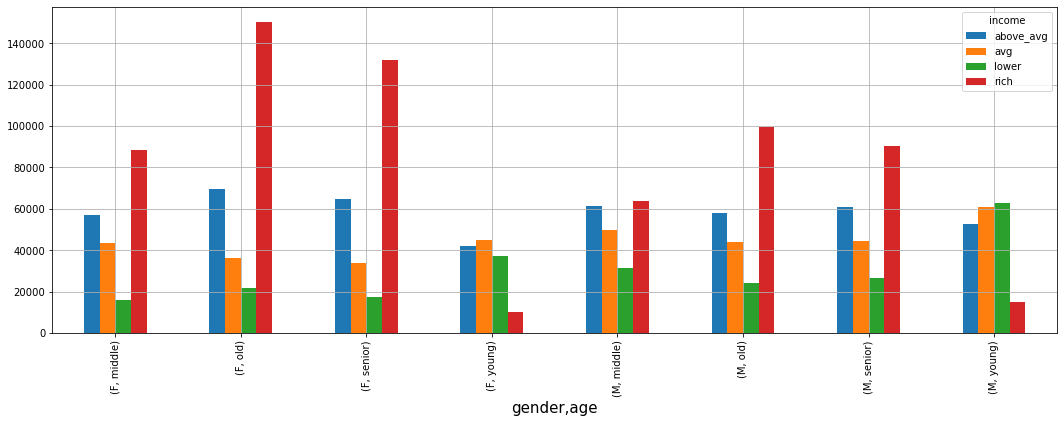

In [172]:
demo_spend_most.plot.bar(figsize = (18,6), grid = True)

Preparing dataset for model.....
Offer journey :In the transcript dataset we have four event status. An offer may go through three of these status(received, viewed and complete). Transaction gives details about all monetary transactions and these transactions may have been triggered after influence from any of the offers or they can be independent purchases. They can also partially linked to offer influence and partial a normal purchase. Either ways , if an offer is sent to a customer , a offer complete event is triggered as soon as the difficulty level for that offer is met within the time duration limit. So we can safely conclude that not all all offer complete event were influenced by offer.
We will consider only those offers successfully complete with meet below two conditions:
Offer view in Time: Once offer in received, offer is viewed by customer within time duration.
Offer completed transaction: Once offer view has happened, offer complete event is triggered between view time and offer duration.

For all other cases where offer view happened after offer complete or offer complete happened without offer view ever happening will be considered unsuccessful offers. Here, for informational offers, it is not possible to find if purchases were made because of them as there is no offer complete tag for these. For those we will consider offer view flag only, but we are not doing any analysis for these offer in this project. 

In [173]:
#inserting a new index coulmn to identify the row
final_df1.insert(0, 'index_new', np.arange(0,272762,1))
def success_flag(profile_df, final_df1):
    """this function returns success_indexs_number, view_index_number values for all transcripts which corresponds to offer_received and are categorized as
    successful orders"""
    customer_id = profile_df['member_id'].unique()
    success_indexs_number = []
    view_index_number = []
    #loop through all customer IDs
    for i in range(len(customer_id)):
        user_id= customer_id[i]
        #extract transactions associated with customer from transcripts data
        user_transcript_data = final_df1[final_df1['member_id'] ==user_id]
        #extract all the rows for offer received, completed and viewed
        offer_received_data = user_transcript_data[user_transcript_data['event'] == 'offer received']
        offer_viewed_data = user_transcript_data[user_transcript_data['event'] == 'offer viewed']
        offer_completed_data = user_transcript_data[user_transcript_data['event'] == 'offer completed']
        # loop through each offer received entry
        for j in range(offer_received_data.shape[0]):
            #extarct one offer ID
            success_flag = False
            offer_id = offer_received_data.iloc[j]['offer_id']
            print(offer_id)
            ind_number = offer_received_data.iloc[j]['index_new']
            # extract duration in hours an offer is valid from offer_recieved_data
            duration_hours = offer_received_data.iloc[j]['duration']
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[j]['time']
            end_time = start_time + duration_hours
            #get all such offer_id rows, and compare if there is any occurance where both offer view and then offer complete is hapenning
            all_offers_view_this_id = offer_viewed_data[offer_viewed_data['offer_id'] == offer_id]
            all_offers_complete_this_id = offer_completed_data[offer_completed_data['offer_id'] == offer_id]
            for k in range(all_offers_view_this_id.shape[0]):
                offer_view_time = all_offers_view_this_id.iloc[k]['time']
                offer_viewed_intime = np.logical_and(offer_view_time >= start_time,offer_view_time <= end_time)               
                if offer_viewed_intime == False:
                    continue
                view_index_number.append(ind_number)
                if all_offers_complete_this_id.empty:
                    success_flag = False
                else:
                    for t in range(all_offers_complete_this_id.shape[0]):
                        offer_complete_time = all_offers_complete_this_id.iloc[t]['time']
                        offer_completed_intime = np.logical_and(offer_complete_time >= offer_view_time, offer_complete_time <= end_time)
                        if offer_completed_intime == True:
                            success_flag = True
                            break
                        else:
                            success_flag = False
                    
            if (success_flag == True):
                success_indexs_number.append(ind_number)

    return success_indexs_number, view_index_number

indx_numbers, view_indx_numbers = success_flag(profile_df, final_df1)

4.0
3.0
4.0
6
True
132
True
8.0
216
True
1.0
408
True
510
True
9.0
582
True
510
False
10.0
18
True
3.0
4.0
420
True
522
True
7.0
522
True
522
True
9.0
0
True
60
True
504
False
4.0
192
True
498
False
438
False
10.0
354
True
498
True
4.0
192
False
438
True
498
True
9.0
0
False
504
True
60
False
600
True
7.0
588
True
600
True
3.0
6.0
168
True
7.0
348
True
456
True
5.0
18
True
2.0
168
True
210
True
8.0
336
True
1.0
432
True
426
False
9.0
612
True
630
True
5.0
10.0
5.0
1.0
414
True
5.0
10.0
5.0
150
True
7.0
168
True
258
True
582
False
6.0
336
True
384
True
426
True
384
False
426
True
6.0
336
False
426
True
384
False
426
True
6.0
336
False
426
False
7.0
168
False
582
True
258
False
5.0
1.0
414
True
486
True
8.0
504
True
5.0
4.0
6.0
408
True
528
True
4.0
3.0
4.0
1.0
438
True
8.0
618
True
6.0
60
True
78
True
192
False
420
False
6.0
60
False
192
True
78
False
222
True
420
False
6.0
60
False
192
False
420
True
78
False
222
False
426
True
5.0
540
True
510
False
10.0
1.0
102
True
510
False
510
Fal

1.0
342
True
4.0
8.0
588
True
6.0
18
True
606
False
540
False
1.0
174
True
7.0
426
True
6.0
18
False
540
True
606
True
8.0
660
False
4.0
222
True
6.0
372
True
9.0
408
True
5.0
10.0
168
True
282
True
1.0
432
True
468
True
8.0
528
True
7.0
582
True
660
True
6.0
78
True
72
False
2.0
168
True
5.0
396
True
3.0
528
True
4.0
582
True
624
True
1.0
0
True
12
True
174
False
1.0
0
False
174
True
12
False
174
True
9.0
366
True
384
True
3.0
8.0
66
True
3.0
198
True
6.0
396
True
384
False
7.0
408
True
468
True
1.0
606
True
570
False
3.0
6
True
3.0
6
False
3.0
6
False
1.0
522
True
528
True
594
True
528
False
588
False
1.0
522
False
594
True
528
False
588
False
2.0
174
True
5.0
9.0
420
True
8.0
600
True
3.0
9.0
444
True
504
True
9.0
444
False
504
True
5.0
9.0
216
True
204
False
4.0
2.0
528
True
528
True
576
True
528
False
576
True
2.0
528
False
576
True
528
False
576
True
5.0
2.0
270
True
8.0
618
False
8.0
618
True
1.0
18
True
8.0
174
True
4.0
6.0
420
True
474
True
10.0
5.0
24
True
9.0
168
True
510
Fa

510
True
504
False
8.0
576
True
1.0
54
True
4.0
192
True
8.0
372
True
6.0
672
True
648
False
6.0
12
True
144
True
1.0
174
True
3.0
8.0
504
True
7.0
648
True
8.0
18
True
594
False
2.0
180
True
192
True
384
False
408
False
2.0
180
False
384
True
192
False
426
True
408
True
192
False
426
True
2.0
180
False
384
False
408
True
192
False
426
True
4.0
8.0
18
False
594
True
8.0
18
True
5.0
7.0
546
True
552
True
10.0
7.0
6
True
48
True
1.0
180
True
180
True
3.0
336
True
6.0
582
True
594
True
9.0
6
True
36
True
510
False
8.0
168
True
9.0
6
False
510
True
36
False
516
True
4.0
666
True
588
False
2.0
228
True
174
False
5.0
5.0
3.0
9.0
168
True
192
True
3.0
3.0
8.0
504
True
7.0
624
True
576
False
8.0
150
False
4.0
168
True
246
True
9.0
336
True
10.0
414
True
462
True
5.0
558
True
588
True
1.0
702
True
588
False
7.0
144
True
162
True
366
False
4.0
7.0
144
False
366
True
162
False
378
True
1.0
426
True
426
True
9.0
570
True
558
False
8.0
204
True
6.0
444
True
462
True
4.0
510
True
516
True
7.0
96
Tru

7.0
6
True
138
True
480
False
4.0
3.0
600
False
7.0
6
False
480
True
138
False
2.0
504
True
3.0
600
True
7.0
24
True
126
True
5.0
228
True
234
True
1.0
414
True
456
True
9.0
504
True
534
True
6.0
594
True
576
False
6.0
0
True
42
True
2.0
168
True
4.0
414
True
450
True
9.0
522
True
540
True
1.0
654
True
3.0
48
True
7.0
168
True
258
True
9.0
342
True
342
True
504
False
9.0
342
False
504
True
342
False
504
True
5.0
594
True
678
True
10.0
10.0
9.0
504
True
528
True
600
True
528
False
582
False
9.0
504
False
600
True
528
False
582
False
5.0
2.0
174
True
198
True
360
False
516
False
576
False
2.0
174
False
360
True
198
False
366
True
516
False
576
False
5.0
2.0
174
False
360
False
516
True
198
False
366
False
504
False
582
True
576
True
198
False
366
False
504
False
582
True
2.0
174
False
360
False
516
False
576
True
198
False
366
False
504
False
582
True
1.0
210
True
5.0
9.0
408
True
522
True
5.0
7.0
594
True
612
True
4.0
6.0
186
True
192
True
8.0
342
True
552
False
2.0
444
True
8.0
342
Fal

9.0
168
True
222
True
408
False
9.0
168
False
408
True
222
False
3.0
4.0
66
True
10.0
6.0
342
True
414
True
10.0
2.0
528
True
10.0
5.0
9.0
360
True
4.0
1.0
576
True
8.0
12
True
3.0
168
True
1.0
348
True
456
True
1.0
348
False
456
True
2.0
666
True
7.0
36
True
180
True
360
False
1.0
600
False
7.0
36
False
360
True
180
False
480
True
6.0
408
True
480
True
5.0
1.0
600
True
180
False
654
True
4.0
2.0
204
True
336
False
504
False
2.0
204
False
336
True
504
False
3.0
438
True
2.0
204
False
336
False
504
True
7.0
594
True
630
True
2.0
18
True
3.0
342
True
606
False
5.0
3.0
342
False
606
True
2.0
42
True
8.0
168
True
3.0
3.0
4.0
10.0
5.0
3.0
2.0
606
True
1.0
24
True
366
False
336
False
10.0
174
True
192
True
1.0
24
False
336
True
366
True
6.0
576
True
588
True
2.0
336
True
3.0
420
True
6.0
504
True
660
True
7.0
594
True
660
True
5.0
7.0
180
True
186
True
8.0
336
True
474
False
8.0
336
False
474
True
3.0
570
True
2.0
0
True
42
True
7.0
168
True
168
True
1.0
336
True
414
True
8.0
504
True
9.0
57

10.0
48
True
5.0
390
True
7.0
408
True
636
True
582
True
636
True
8.0
504
True
7.0
408
False
582
True
636
True
4.0
444
True
2.0
540
True
576
True
2.0
540
False
576
True
8.0
258
False
10.0
1.0
426
True
4.0
10.0
8.0
168
True
3.0
2.0
444
True
708
False
3.0
2.0
444
False
708
False
9.0
12
True
1.0
9.0
12
False
7.0
576
True
4.0
30
True
42
True
4.0
30
False
8.0
336
True
4.0
30
False
10.0
6.0
576
True
630
True
1.0
588
False
9.0
228
True
192
False
6.0
5.0
462
True
528
True
1.0
588
True
510
False
1.0
588
True
510
False
1.0
36
True
126
True
240
False
1.0
36
False
240
True
126
False
222
False
4.0
474
True
432
False
2.0
576
True
594
True
6.0
252
False
588
False
5.0
366
True
432
True
7.0
438
True
432
False
6.0
252
False
588
True
612
True
9.0
0
True
42
True
8.0
204
True
7.0
360
True
396
True
1.0
504
True
534
True
2.0
588
True
6.0
18
True
168
True
378
False
9.0
204
True
168
False
6.0
18
False
378
True
168
False
378
True
2.0
510
True
420
False
8.0
576
True
10.0
18
True
90
True
1.0
366
True
372
True
3.0

5.0
10.0
198
True
246
True
4.0
9.0
450
True
8.0
522
True
7.0
576
True
672
True
7.0
24
True
90
True
10.0
2.0
390
True
5.0
1.0
510
True
8.0
624
True
8.0
0
True
4.0
372
False
5.0
1.0
582
True
5.0
1.0
192
True
7.0
414
True
480
True
9.0
504
True
576
True
576
True
576
True
9.0
504
False
576
True
576
True
2.0
36
True
1.0
192
True
186
False
10.0
9.0
420
True
4.0
10.0
8.0
6
True
438
False
6.0
174
True
324
True
2.0
342
True
8.0
6
False
438
True
9.0
510
True
1.0
630
True
10.0
18
True
30
True
2.0
174
True
192
True
420
False
2.0
174
False
420
True
192
False
420
True
8.0
516
True
3.0
588
True
8.0
6
True
510
False
7.0
270
True
330
True
3.0
372
True
2.0
438
True
582
False
624
False
8.0
6
False
510
True
2.0
438
False
624
True
582
False
8.0
12
True
6.0
174
True
204
True
438
False
7.0
348
True
474
True
6.0
174
False
438
True
204
False
474
True
1.0
546
True
3.0
60
True
414
False
10.0
594
False
3.0
60
False
414
True
10.0
594
True
636
True
9.0
18
True
66
True
168
False
9.0
18
False
168
True
66
False
186
Tru

5.0
8.0
168
True
7.0
342
True
342
True
10.0
3.0
6.0
24
True
18
False
198
False
192
False
6.0
24
False
192
True
18
False
198
True
5.0
4.0
3.0
5.0
6.0
30
True
360
False
336
False
6.0
30
False
336
True
360
True
3.0
7.0
6
True
462
False
390
False
2.0
168
True
7.0
6
False
390
True
462
True
8.0
6.0
630
True
702
True
3.0
2.0
372
True
588
False
6.0
426
True
9.0
516
True
2.0
372
False
588
True
5.0
72
True
456
False
672
False
342
False
9.0
192
True
204
True
5.0
72
False
342
True
456
True
7.0
450
True
456
True
5.0
72
False
342
False
2.0
0
True
10.0
186
True
3.0
408
True
1.0
612
True
1.0
0
True
96
True
10.0
552
False
4.0
636
True
4.0
36
True
72
True
438
False
504
False
4.0
36
False
438
True
72
False
480
True
504
True
72
False
480
False
582
False
4.0
36
False
438
False
504
True
72
False
480
False
582
True
3.0
372
True
588
False
9.0
426
True
3.0
372
False
588
True
7.0
12
True
72
True
10.0
1.0
342
True
342
True
8.0
8.0
3.0
588
True
6.0
48
True
66
True
9.0
180
True
168
False
8.0
336
True
534
False
7.0

4.0
0
True
18
True
7.0
336
True
360
True
1.0
414
True
414
True
2.0
504
True
522
True
1.0
144
True
168
True
4.0
198
True
168
False
5.0
348
True
444
True
10.0
414
True
408
False
1.0
168
True
4.0
8.0
408
True
528
False
8.0
408
False
528
True
4.0
6.0
12
True
708
False
168
True
708
False
606
False
6.0
12
False
168
True
708
False
606
False
3.0
3.0
6.0
12
False
168
False
606
True
708
True
6.0
60
True
0
False
558
False
444
False
2.0
294
False
1.0
342
True
342
True
6.0
60
False
444
True
0
False
558
True
5.0
516
True
558
True
9.0
582
True
10.0
3.0
1.0
7.0
408
True
9.0
516
True
6.0
612
True
1.0
126
True
3.0
7.0
342
True
480
True
6.0
408
True
480
True
5.0
594
True
606
True
2.0
186
True
8.0
1.0
408
True
576
True
3.0
1.0
408
False
576
True
1.0
6
True
12
True
7.0
180
True
168
False
10.0
354
True
336
False
528
False
4.0
618
False
10.0
354
False
4.0
618
True
414
False
612
False
1.0
144
True
30
False
6.0
186
True
216
True
336
True
216
False
372
False
474
False
408
False
6.0
186
False
336
True
216
False


10.0
294
False
1.0
522
True
10.0
294
False
5.0
8.0
240
True
4.0
444
True
534
False
534
False
4.0
444
True
534
True
4.0
444
False
2.0
24
True
72
True
4.0
306
True
312
True
5.0
366
True
426
True
10.0
480
True
408
False
6.0
504
True
510
True
7.0
618
True
618
True
10.0
1.0
450
True
8.0
4.0
6.0
18
True
18
True
408
False
2.0
168
True
180
True
6.0
18
False
408
True
18
False
414
True
4.0
5.0
7.0
0
True
54
True
10.0
180
True
186
True
10.0
180
False
2.0
516
True
510
False
10.0
0
True
12
True
4.0
396
True
480
True
618
False
6.0
408
True
480
True
4.0
396
False
618
True
480
False
5.0
168
True
8.0
342
True
9.0
408
True
444
True
4.0
534
True
504
False
1.0
18
True
132
True
450
False
582
False
6.0
168
True
288
True
1.0
18
False
450
True
132
False
342
False
594
False
582
False
1.0
18
False
450
False
582
True
132
False
342
False
594
True
5.0
6
True
7.0
180
True
4.0
528
True
8.0
588
True
8.0
60
True
5.0
606
True
552
False
552
False
5.0
606
True
552
False
552
False
10.0
4.0
198
True
174
False
10.0
6.0
444


6.0
588
True
3.0
36
True
2.0
204
True
252
True
8.0
606
False
1.0
5.0
8.0
606
True
8.0
8.0
10.0
390
True
474
True
4.0
6.0
510
True
666
True
2.0
582
True
666
True
2.0
0
True
600
False
504
False
10.0
174
True
192
True
8.0
4.0
420
True
438
True
2.0
0
False
504
True
600
True
7.0
576
True
600
True
7.0
174
True
198
True
2.0
408
True
432
True
9.0
528
True
540
True
7.0
6
True
10.0
6.0
618
True
678
True
3.0
114
False
5.0
180
True
186
True
498
False
3.0
114
False
5.0
180
False
498
True
186
False
552
True
10.0
558
True
552
False
1.0
576
True
594
True
6.0
60
True
180
False
630
False
168
True
180
False
630
False
540
False
6.0
60
False
168
True
180
True
540
False
2.0
474
True
6.0
60
False
168
False
540
True
180
False
630
True
10.0
648
True
630
False
3.0
180
True
5.0
8.0
4.0
510
True
516
True
7.0
606
True
666
True
2.0
24
True
42
True
4.0
168
True
174
True
8.0
390
True
4.0
168
False
5.0
504
True
522
True
9.0
618
True
588
False
2.0
192
True
3.0
1.0
414
True
432
True
3.0
10.0
8.0
354
True
2.0
408
True
51

True
10.0
120
True
96
False
612
False
9.0
180
True
282
True
7.0
372
True
486
True
5.0
492
True
486
False
690
False
672
False
10.0
120
False
5.0
492
False
672
True
486
False
690
True
6.0
6
True
3.0
4.0
618
True
630
True
10.0
24
True
48
True
8.0
210
True
9.0
378
True
1.0
7.0
582
True
666
True
7.0
0
True
108
True
408
False
7.0
0
False
408
True
108
False
408
True
2.0
510
True
528
True
8.0
630
True
1.0
252
True
4.0
456
True
504
True
5.0
648
True
546
False
2.0
168
True
186
True
336
False
2.0
168
False
336
True
186
False
336
True
7.0
414
True
408
False
504
True
516
True
408
False
504
False
576
True
594
True
408
False
504
False
576
False
7.0
414
False
516
True
408
False
504
False
576
True
594
True
408
False
504
False
576
False
7.0
414
False
516
False
594
True
408
False
504
False
576
False
6.0
168
True
294
True
1.0
336
True
366
True
558
False
2.0
414
True
666
False
576
False
1.0
336
False
558
True
366
False
666
True
2.0
414
False
576
True
666
True
6.0
30
True
42
True
4.0
7.0
456
True
462
True
1

5.0
6.0
444
True
408
False
606
False
582
False
2.0
504
True
606
True
6.0
444
False
582
True
408
False
606
True
8.0
180
True
360
False
534
False
8.0
180
False
360
True
534
False
2.0
408
True
420
True
8.0
180
False
360
False
534
True
1.0
600
True
636
True
7.0
0
True
2.0
186
True
246
True
588
False
5.0
10.0
414
True
2.0
186
False
588
True
246
False
7.0
66
True
144
True
4.0
168
True
186
True
1.0
432
True
468
True
2.0
0
True
10.0
10.0
10.0
4.0
6.0
576
True
10.0
7.0
168
True
192
True
654
False
2.0
432
True
7.0
168
False
654
True
192
False
2.0
126
False
372
False
522
False
9.0
180
True
192
True
2.0
126
False
372
True
378
True
522
False
8.0
2.0
126
False
372
False
522
True
378
False
528
True
10.0
9.0
12
True
8.0
222
True
354
False
8.0
222
False
354
True
5.0
444
True
594
True
2.0
516
True
594
True
1.0
690
True
594
False
5.0
6
True
18
True
8.0
228
True
9.0
360
True
2.0
420
True
462
True
4.0
570
True
8.0
18
True
612
False
3.0
1.0
360
True
6.0
408
True
504
True
5.0
8.0
18
False
612
True
5.0
1.0
17

516
True
516
True
8.0
600
True
7.0
18
True
186
True
8.0
192
True
3.0
498
False
9.0
528
True
10.0
624
True
1.0
6
True
408
False
6.0
198
True
294
True
10.0
366
True
1.0
6
False
408
True
7.0
594
True
3.0
12
True
6.0
168
True
228
True
8.0
336
True
4.0
414
True
510
True
2.0
504
True
510
True
6.0
102
True
3.0
8.0
9.0
498
True
504
True
2.0
504
True
4.0
1.0
7.0
168
True
282
True
3.0
6.0
3.0
10.0
174
True
198
True
7.0
360
True
558
True
9.0
456
True
6.0
5.0
594
True
714
True
9.0
132
False
5.0
8.0
366
True
7.0
468
True
558
True
2.0
534
True
6.0
582
True
8.0
18
True
4.0
372
False
576
False
4.0
372
False
576
True
270
False
588
False
4.0
372
False
576
True
270
False
588
True
6.0
18
True
2.0
168
True
5.0
3.0
4.0
24
True
66
True
666
False
3.0
6.0
354
True
354
True
10.0
8.0
564
True
4.0
24
False
666
True
66
False
9.0
6
True
4.0
336
True
408
True
1.0
414
True
408
False
2.0
6
True
30
True
606
False
7.0
222
True
390
True
4.0
360
True
390
True
10.0
456
True
474
True
3.0
516
True
2.0
6
False
606
True
30
Fal

7.0
168
True
204
True
9.0
336
True
336
True
8.0
408
True
2.0
510
True
576
True
6.0
6
True
8.0
246
False
576
False
3.0
4.0
438
True
1.0
534
True
8.0
246
False
576
True
7.0
48
True
168
True
4.0
2.0
372
True
7.0
48
False
4.0
3.0
5.0
84
True
1.0
360
True
384
True
4.0
408
True
414
True
528
True
414
False
558
True
4.0
408
False
528
True
414
False
558
True
10.0
576
True
696
True
4.0
8.0
192
True
7.0
354
True
366
True
1.0
510
True
6.0
630
True
6.0
6
True
660
False
504
False
7.0
408
True
6.0
6
False
504
True
660
True
8.0
2.0
42
True
42
True
9.0
240
True
264
True
3.0
396
True
648
False
1.0
408
True
408
True
5.0
3.0
396
False
648
True
10.0
9.0
168
True
180
True
5.0
10.0
54
True
66
True
9.0
426
True
2.0
558
True
6.0
612
True
696
True
3.0
558
False
5.0
10.0
3.0
558
False
3.0
558
True
9.0
624
True
10.0
120
True
30
False
2.0
336
True
426
True
612
False
1.0
414
True
426
True
2.0
336
False
612
True
426
False
606
False
4.0
90
True
126
True
2.0
180
True
228
True
6.0
600
True
606
True
9.0
174
True
264
Tru

9.0
0
True
18
True
336
False
6.0
174
True
180
True
9.0
0
False
336
True
18
False
336
True
5.0
654
True
600
False
600
False
5.0
654
True
600
False
600
False
7.0
84
True
60
False
372
False
372
False
8.0
198
True
7.0
84
False
372
True
60
False
372
True
3.0
4.0
6.0
0
True
78
True
5.0
1.0
336
True
414
True
5.0
7.0
378
True
456
True
582
False
3.0
7.0
378
False
582
True
456
False
702
True
2.0
30
True
72
True
1.0
174
True
258
True
7.0
372
True
462
True
414
True
462
True
7.0
372
False
414
True
462
True
8.0
558
True
8.0
18
True
414
False
5.0
8.0
18
False
414
True
7.0
522
True
558
True
10.0
8.0
48
True
384
False
582
False
8.0
48
False
384
True
582
False
8.0
48
False
384
False
582
True
4.0
12
True
42
True
10.0
6.0
2.0
420
True
522
True
3.0
594
True
2.0
6
True
42
True
360
False
9.0
174
True
228
True
2.0
6
False
360
True
42
False
384
True
3.0
462
True
8.0
594
True
6.0
222
True
180
False
480
False
468
False
10.0
6.0
222
False
468
True
180
False
480
True
4.0
522
True
558
True
5.0
2.0
0
True
6
True
408

342
False
594
True
450
False
4.0
4.0
6.0
426
True
510
True
10.0
1.0
600
True
606
True
6.0
228
True
8.0
366
True
4.0
7.0
516
True
3.0
8.0
24
True
10.0
336
True
342
True
5.0
3.0
576
True
2.0
78
True
1.0
10.0
504
True
3.0
588
True
3.0
12
True
7.0
168
True
2.0
414
True
4.0
516
True
6.0
576
True
690
True
9.0
12
True
30
True
6.0
168
True
312
True
2.0
462
True
432
False
5.0
7.0
6
True
18
True
588
False
2.0
258
True
204
False
9.0
378
True
378
True
10.0
1.0
522
True
588
True
7.0
6
False
588
True
18
False
588
True
9.0
438
True
450
True
8.0
6
True
3.0
186
True
450
False
9.0
372
True
3.0
186
False
450
True
10.0
564
True
6.0
642
True
696
True
5.0
8.0
450
False
3.0
582
False
4.0
210
True
192
False
498
False
462
False
8.0
342
True
4.0
210
False
462
True
192
False
498
True
3.0
582
True
5.0
4.0
3.0
1.0
504
True
516
True
8.0
1.0
36
True
4.0
10.0
8.0
444
True
5.0
10.0
84
True
4.0
5.0
1.0
618
True
7.0
54
True
5.0
2.0
408
True
7.0
18
True
48
True
10.0
234
True
174
False
642
False
1.0
342
True
378
True
8.0


2.0
180
True
186
True
3.0
354
True
6.0
5.0
10.0
144
True
102
False
2.0
222
True
3.0
3.0
6.0
528
True
528
True
582
True
528
False
600
True
6.0
528
False
582
True
528
False
600
True
5.0
54
True
10.0
264
True
1.0
4.0
408
True
9.0
516
True
9.0
36
True
540
False
4.0
198
True
3.0
426
True
9.0
36
False
540
True
4.0
0
True
336
False
396
False
1.0
174
True
222
True
4.0
0
False
396
True
336
False
5.0
420
True
480
True
9.0
576
True
576
True
7.0
168
True
174
True
3.0
516
False
3.0
516
True
4.0
5.0
90
True
216
True
9.0
168
True
180
True
576
False
7.0
420
True
420
True
528
True
420
False
510
False
7.0
420
False
528
True
420
False
510
False
9.0
168
False
576
True
180
False
582
True
8.0
7.0
180
True
1.0
2.0
516
True
606
True
6.0
576
True
606
True
5.0
78
True
84
True
10.0
216
True
246
True
6.0
348
True
360
True
3.0
7.0
588
True
630
True
2.0
0
True
30
True
3.0
174
True
420
False
7.0
402
True
552
True
3.0
174
False
420
True
8.0
534
True
1.0
24
True
42
True
210
False
1.0
24
False
210
True
42
False
216
Tru

564
True
558
False
5.0
2.0
0
True
3.0
7.0
576
True
5.0
8.0
414
True
1.0
504
True
2.0
3.0
354
True
5.0
576
True
594
True
2.0
168
True
5.0
3.0
7.0
588
True
1.0
36
True
534
False
4.0
4.0
1.0
36
False
9.0
612
True
9.0
30
True
7.0
168
True
2.0
366
True
3.0
6.0
576
True
7.0
132
True
198
True
510
False
10.0
228
True
198
False
5.0
8.0
414
True
7.0
132
False
510
True
198
False
546
True
3.0
618
True
6.0
42
True
96
True
7.0
168
True
186
True
4.0
10.0
414
True
414
True
9.0
588
True
588
True
2.0
24
True
30
True
432
False
576
False
10.0
240
True
330
True
4.0
2.0
24
False
432
True
30
False
576
False
2.0
24
False
432
False
576
True
30
False
7.0
48
True
174
True
1.0
192
True
174
False
504
False
570
False
4.0
3.0
1.0
192
False
570
True
174
False
504
False
6.0
594
True
582
False
6.0
6
True
60
True
510
False
8.0
342
True
420
False
8.0
342
False
420
True
6.0
6
False
510
True
60
False
504
False
10.0
24
True
72
True
1.0
294
True
3.0
444
True
5.0
4.0
78
True
324
False
4.0
78
False
324
True
3.0
5.0
516
True
54

456
True
408
False
594
False
6.0
456
False
8.0
588
True
10.0
5.0
10.0
2.0
408
True
492
True
4.0
5.0
216
True
246
True
8.0
462
True
10.0
5.0
0
True
48
True
384
False
4.0
168
True
180
True
5.0
0
False
384
True
48
False
498
True
10.0
414
True
498
True
6.0
510
True
510
True
3.0
600
True
10.0
10.0
4.0
9.0
534
True
552
True
5.0
9.0
186
True
270
True
3.0
4.0
3.0
10.0
1.0
6
True
8.0
198
True
576
False
3.0
2.0
564
True
8.0
198
False
576
True
5.0
24
True
2.0
168
True
576
False
504
False
5.0
5.0
2.0
168
False
504
True
576
True
4.0
678
True
576
False
3.0
6
True
10.0
168
True
216
True
7.0
336
True
360
True
5.0
420
True
8.0
534
True
4.0
576
True
606
True
2.0
0
True
6
True
5.0
390
True
300
False
8.0
420
True
6.0
504
True
504
True
9.0
576
True
576
True
8.0
198
True
504
False
4.0
8.0
198
False
504
True
10.0
1.0
60
True
5.0
4.0
486
True
4.0
486
False
3.0
6.0
420
True
480
True
7.0
534
True
10.0
684
True
4.0
0
True
30
True
234
False
582
False
4.0
0
False
234
True
30
False
258
True
582
False
7.0
342
True
4

348
True
552
True
8.0
420
True
3.0
174
False
510
True
2.0
600
True
672
True
5.0
432
True
468
True
1.0
576
True
624
True
1.0
42
True
4.0
282
True
396
False
4.0
282
False
396
True
8.0
540
False
8.0
540
True
4.0
282
False
396
False
6.0
0
True
6
True
342
False
594
False
2.0
168
True
222
True
6.0
0
False
342
True
6
False
354
True
594
False
1.0
408
True
426
True
8.0
504
True
6.0
0
False
342
False
594
True
6
False
354
False
618
True
1.0
3.0
378
True
4.0
480
True
522
True
5.0
7.0
672
True
3.0
210
True
9.0
426
True
516
True
6.0
6
True
66
True
7.0
186
True
198
True
450
False
7.0
186
False
450
True
198
False
408
False
5.0
6.0
30
True
66
True
4.0
9.0
600
True
564
False
648
False
9.0
600
True
564
False
648
True
10.0
30
True
60
True
5.0
4.0
3.0
1.0
576
True
9.0
186
True
198
True
4.0
1.0
612
True
618
True
8.0
30
True
6.0
198
True
216
True
450
False
6.0
198
False
450
True
216
False
426
False
7.0
558
True
510
False
2.0
618
True
600
False
9.0
0
True
42
True
8.0
168
True
3.0
7.0
504
True
516
True
4.0
666

6
True
8.0
360
True
2.0
492
True
3.0
600
True
2.0
48
True
12
False
8.0
222
True
4.0
402
True
408
True
7.0
540
True
576
True
9.0
600
True
576
False
1.0
2.0
174
True
8.0
348
True
8.0
348
False
6.0
522
True
510
False
10.0
582
True
576
False
5.0
90
True
54
False
1.0
342
True
642
False
570
False
1.0
342
False
570
True
642
False
1.0
342
False
570
True
642
True
7.0
12
True
174
True
10.0
372
False
9.0
408
True
1.0
546
True
582
True
3.0
588
True
8.0
72
True
7.0
228
True
456
False
432
False
594
False
7.0
228
False
432
True
456
True
594
True
456
False
6.0
534
True
7.0
228
False
432
False
594
True
456
False
9.0
0
True
6.0
312
True
252
False
1.0
654
False
10.0
1.0
654
True
348
False
594
False
8.0
168
True
5.0
5.0
5.0
5.0
36
True
90
True
582
False
9.0
354
True
336
False
10.0
540
True
558
True
5.0
36
False
582
True
90
False
606
True
4.0
0
True
36
True
3.0
9.0
336
True
390
True
1.0
438
True
516
True
4.0
0
False
6.0
168
True
168
True
7.0
366
True
378
True
2.0
438
True
420
False
9.0
54
True
60
True
8.0


204
False
390
False
600
True
216
False
456
False
582
False
9.0
24
True
12
False
510
False
8.0
2.0
426
True
9.0
24
False
510
True
12
False
7.0
42
True
84
True
192
True
84
False
336
False
7.0
42
False
192
True
84
False
336
True
3.0
5.0
4.0
9.0
0
True
1.0
210
True
228
True
336
True
228
False
384
False
1.0
210
False
336
True
228
False
384
True
6.0
408
True
414
True
504
True
414
False
504
True
6.0
408
False
504
True
414
False
504
True
9.0
54
True
414
False
8.0
240
True
2.0
336
True
510
False
9.0
54
False
414
True
2.0
336
False
510
True
1.0
6
True
2.0
168
True
5.0
9.0
450
True
4.0
6.0
642
True
2.0
168
True
222
True
9.0
408
True
10.0
516
True
5.0
54
True
168
True
420
False
8.0
174
True
576
False
5.0
54
False
420
True
168
False
462
True
8.0
174
False
576
True
3.0
4.0
480
True
522
True
660
False
4.0
480
False
660
True
522
False
5.0
3.0
7.0
408
True
528
True
678
False
5.0
7.0
408
False
678
True
528
False
5.0
7.0
192
True
192
True
3.0
390
True
1.0
492
True
462
False
1.0
18
True
48
True
6.0
216
Tr

210
False
648
True
258
False
576
False
9.0
0
True
18
True
5.0
10.0
1.0
420
True
8.0
636
True
8.0
12
True
510
False
588
False
10.0
174
True
204
True
7.0
336
True
2.0
408
True
8.0
12
False
510
True
588
False
8.0
12
False
510
False
588
True
10.0
306
True
246
False
1.0
462
True
528
True
4.0
8.0
594
True
1.0
0
True
126
True
4.0
174
True
186
True
9.0
6.0
420
True
444
True
7.0
558
True
510
False
10.0
576
True
618
True
3.0
12
True
6.0
336
True
354
True
8.0
5.0
4.0
10.0
5.0
10.0
2.0
618
True
8.0
174
True
7.0
408
True
606
True
606
True
606
True
6.0
564
True
606
True
7.0
408
False
606
True
606
True
5.0
2.0
258
True
8.0
462
True
10.0
4.0
192
True
288
True
4.0
192
False
1.0
420
True
6.0
516
True
618
True
3.0
600
True
8.0
36
True
420
False
654
False
8.0
36
False
420
True
654
False
10.0
558
True
8.0
36
False
420
False
654
False
6.0
18
True
5.0
3.0
3.0
1.0
0
True
0
True
4.0
10.0
9.0
432
True
438
True
8.0
2.0
696
True
690
False
4.0
9.0
216
True
3.0
342
True
6.0
420
True
3.0
342
False
1.0
372
True
408
T

1.0
372
True
360
False
7.0
6
False
510
True
108
False
594
True
3.0
582
True
9.0
18
True
66
True
342
False
3.0
180
True
9.0
18
False
342
True
66
False
378
True
10.0
10.0
5.0
5.0
8.0
540
True
3.0
2.0
180
True
7.0
396
True
396
True
5.0
10.0
558
True
588
True
624
True
588
False
588
False
10.0
558
False
624
True
588
False
588
False
10.0
192
False
10.0
192
True
9.0
360
True
378
True
618
False
3.0
462
True
9.0
360
False
618
True
378
False
666
True
2.0
66
True
9.0
342
True
438
True
3.0
420
True
1.0
612
True
9.0
186
True
192
True
8.0
24
True
10.0
216
True
258
True
336
True
258
False
450
False
450
False
426
False
10.0
216
False
336
True
258
False
450
True
426
True
258
False
450
True
10.0
216
False
336
False
426
True
258
False
450
True
1.0
522
True
552
True
7.0
30
True
186
True
8.0
174
True
4.0
108
True
576
False
9.0
336
True
420
True
10.0
4.0
108
False
10.0
0
True
66
True
2.0
198
True
8.0
3.0
588
True
5.0
1.0
408
True
5.0
2.0
12
True
54
True
1.0
420
True
426
True
600
False
1.0
420
False
600
True

6.0
30
True
8.0
192
True
1.0
342
True
612
False
1.0
342
False
612
True
10.0
42
True
42
True
354
False
426
False
600
False
10.0
42
False
354
True
42
False
360
True
426
True
42
False
360
False
426
True
600
False
10.0
42
False
354
False
426
True
42
False
360
False
426
True
600
False
5.0
504
True
570
True
10.0
42
False
354
False
426
False
600
True
42
False
360
False
426
False
636
True
5.0
1.0
258
True
10.0
6.0
414
True
564
True
582
False
6.0
414
False
564
True
582
True
6.0
414
False
564
False
582
True
4.0
2.0
354
True
366
True
7.0
498
True
474
False
4.0
54
True
102
True
1.0
348
True
336
False
6.0
420
True
414
False
2.0
528
True
504
False
7.0
582
True
576
False
7.0
24
True
168
True
414
False
6.0
276
True
1.0
7.0
24
False
414
True
168
False
528
True
5.0
8.0
168
True
2.0
522
True
2.0
522
True
3.0
78
True
7.0
228
True
246
True
546
False
9.0
336
True
342
True
7.0
228
False
546
True
246
False
546
True
8.0
642
True
9.0
186
True
198
True
10.0
486
True
546
False
546
False
630
False
10.0
486
True
54

8.0
0
True
7.0
168
True
204
True
3.0
408
True
4.0
594
True
684
True
7.0
42
True
6
False
6.0
186
True
618
False
522
False
5.0
378
True
474
True
6.0
186
False
522
True
618
True
5.0
378
False
8.0
360
True
4.0
2.0
660
True
5.0
10.0
7.0
504
True
540
True
8.0
9.0
168
True
192
True
6.0
408
True
420
True
5.0
624
True
5.0
9.0
366
True
6.0
444
True
10.0
636
True
10.0
636
True
10.0
6.0
5.0
7.0
540
True
9.0
576
True
6.0
6
True
150
True
5.0
174
True
270
True
4.0
516
True
522
True
3.0
36
True
384
False
4.0
192
True
186
False
3.0
36
False
384
True
7.0
426
True
618
True
2.0
582
True
618
True
6.0
186
True
228
True
8.0
504
True
1.0
600
True
7.0
60
True
96
True
4.0
204
True
216
True
7.0
60
False
1.0
420
True
528
True
3.0
10.0
582
True
10.0
36
True
18
False
7.0
180
True
3.0
462
True
4.0
420
False
1.0
354
True
4.0
420
True
9.0
3.0
576
True
10.0
2.0
168
True
186
True
570
False
10.0
7.0
408
True
408
True
2.0
168
False
570
True
186
False
504
False
6.0
678
True
582
False
8.0
72
True
2.0
174
True
5.0
1.0
612
Tr

10.0
198
True
252
True
4.0
396
True
444
True
10.0
198
False
7.0
504
True
630
True
1.0
636
True
630
False
3.0
18
True
8.0
420
True
10.0
582
True
5.0
10.0
10.0
5.0
1.0
8.0
3.0
0
True
2.0
168
True
228
True
6.0
5.0
3.0
0
False
8.0
168
False
8.0
168
True
9.0
420
True
444
True
6.0
546
True
588
True
4.0
10.0
528
False
4.0
342
True
468
True
6.0
432
True
468
True
600
False
10.0
528
True
570
True
6.0
432
False
600
True
468
False
10.0
198
True
168
False
9.0
420
True
432
True
6.0
582
True
3.0
84
True
10.0
10.0
5.0
6.0
6
True
9.0
174
True
420
False
3.0
372
True
9.0
174
False
420
True
7.0
5.0
9.0
24
True
7.0
402
True
402
True
4.0
522
True
5.0
10.0
90
True
4.0
2.0
396
True
2.0
396
False
5.0
6.0
168
True
588
False
8.0
414
True
7.0
504
True
6.0
168
False
588
True
1.0
24
True
24
True
6.0
168
True
222
True
3.0
348
True
4.0
408
True
450
True
5.0
9.0
576
True
594
True
6.0
258
True
10.0
2.0
5.0
10.0
42
True
8.0
210
True
4.0
336
True
408
True
4.0
336
False
408
True
9.0
672
True
5.0
1.0
168
True
198
True
354


6.0
192
True
198
True
336
True
198
False
348
False
6.0
192
False
336
True
198
False
348
True
2.0
582
True
546
False
4.0
174
True
180
True
3.0
10.0
9.0
510
True
546
True
5.0
5.0
168
True
222
True
354
True
222
False
372
True
408
True
222
False
372
False
456
False
5.0
168
False
354
True
222
False
372
True
408
True
222
False
372
False
456
True
5.0
168
False
354
False
408
True
222
False
372
False
456
True
4.0
534
True
528
False
6.0
582
True
678
True
10.0
114
True
9.0
234
True
7.0
342
True
378
True
534
True
378
False
600
False
7.0
342
False
534
True
378
False
600
True
1.0
582
True
642
True
7.0
0
True
462
False
348
False
10.0
174
True
558
False
7.0
0
False
348
True
462
True
10.0
174
False
1.0
588
True
8.0
0
True
4.0
378
True
378
True
408
True
378
False
450
True
4.0
378
False
408
True
378
False
450
True
6.0
546
True
552
True
1.0
288
True
330
True
9.0
342
True
396
True
2.0
486
True
4.0
246
True
270
True
1.0
348
True
360
True
432
True
360
False
432
True
1.0
348
False
432
True
360
False
432
True


690
True
642
False
7.0
204
True
576
False
1.0
360
True
4.0
6.0
504
True
7.0
204
False
576
True
5.0
6.0
174
True
540
False
6.0
174
False
540
True
1.0
594
True
3.0
0
True
4.0
6.0
336
True
5.0
8.0
612
True
6.0
300
True
300
True
4.0
10.0
480
True
468
False
3.0
582
True
3.0
354
False
5.0
1.0
690
False
5.0
678
False
2.0
348
True
4.0
516
True
606
False
4.0
516
True
606
True
5.0
678
True
246
False
660
False
5.0
9.0
438
True
10.0
1.0
5.0
5.0
5.0
3.0
2.0
18
True
36
True
4.0
4.0
9.0
564
True
600
True
4.0
18
True
24
True
5.0
300
True
372
True
6.0
336
True
372
True
9.0
414
True
408
False
10.0
1.0
180
True
510
False
9.0
336
True
1.0
180
False
510
True
10.0
60
True
132
True
9.0
204
True
168
False
1.0
4.0
2.0
516
True
558
True
7.0
612
True
9.0
0
True
7.0
174
True
654
False
8.0
546
True
7.0
174
False
654
True
2.0
6
True
9.0
168
True
288
True
348
False
9.0
168
False
348
True
288
False
4.0
468
True
492
True
6.0
576
True
576
True
9.0
6
True
240
False
222
False
9.0
6
False
222
True
240
True
4.0
1.0
444
Tru

342
True
354
True
7.0
438
True
618
True
4.0
0
True
4.0
0
False
7.0
426
True
10.0
3.0
9.0
12
True
54
True
2.0
354
True
396
True
5.0
408
True
438
True
1.0
588
True
558
False
2.0
198
False
348
False
408
False
2.0
198
False
348
True
372
True
408
True
372
False
2.0
198
False
348
False
408
True
372
False
4.0
4.0
198
True
288
True
600
False
7.0
414
True
438
True
10.0
546
True
522
False
4.0
198
False
600
True
288
False
594
False
9.0
174
True
204
True
7.0
378
True
402
True
3.0
522
True
8.0
606
True
6.0
6
True
24
True
576
False
1.0
252
True
8.0
360
True
504
False
2.0
408
True
8.0
360
False
504
True
6.0
6
False
576
True
24
False
582
True
3.0
102
False
10.0
8.0
408
True
1.0
528
True
546
True
6.0
612
True
618
True
4.0
6
True
6
True
9.0
168
True
222
True
1.0
534
True
612
True
600
True
612
True
1.0
534
False
600
True
612
True
2.0
48
True
204
False
180
False
2.0
48
False
180
True
204
True
10.0
396
True
486
True
1.0
474
True
486
True
4.0
690
True
10.0
1.0
216
True
3.0
5.0
7.0
516
True
3.0
5.0
2.0
174
T

186
True
6.0
342
True
1.0
6
False
444
True
504
True
1.0
6
False
444
False
504
True
10.0
576
True
3.0
354
True
1.0
6.0
612
True
630
True
9.0
174
True
204
True
8.0
366
True
6.0
420
True
1.0
5.0
3.0
10.0
54
True
7.0
174
True
9.0
348
True
420
True
8.0
414
True
516
False
8.0
414
False
516
True
6.0
594
True
606
True
8.0
48
True
480
False
4.0
372
True
384
True
8.0
48
False
480
True
9.0
504
True
552
True
1.0
588
True
630
True
4.0
354
True
396
True
7.0
408
True
504
True
5.0
570
True
606
True
8.0
192
True
3.0
372
True
9.0
456
True
414
False
7.0
540
True
528
False
10.0
3.0
222
True
5.0
450
True
480
True
5.0
450
True
480
True
4.0
2.0
0
True
192
False
2.0
0
False
192
True
3.0
10.0
1.0
5.0
2.0
24
True
168
False
168
False
2.0
24
False
168
True
168
True
5.0
8.0
444
True
8.0
444
False
9.0
30
True
54
True
1.0
426
True
522
True
8.0
510
True
10.0
3.0
636
False
2.0
3.0
636
True
4.0
1.0
234
True
8.0
372
True
2.0
630
True
2.0
30
True
48
True
5.0
5.0
10.0
9.0
18
True
3.0
354
True
8.0
618
True
9.0
210
True
246

3.0
2.0
336
True
7.0
438
True
3.0
3.0
2.0
78
True
5.0
5.0
6.0
408
True
432
True
5.0
10.0
630
True
10.0
5.0
7.0
336
True
360
True
3.0
2.0
534
True
5.0
306
True
222
False
8.0
384
True
1.0
450
True
420
False
9.0
612
True
654
True
2.0
0
True
6
True
180
False
2.0
0
False
180
True
6
False
186
True
5.0
360
True
384
True
8.0
450
True
618
False
9.0
504
True
504
True
8.0
450
False
618
True
3.0
606
False
7.0
336
True
360
True
2.0
414
True
474
True
4.0
570
True
3.0
606
True
9.0
48
True
12
False
10.0
186
True
192
True
3.0
402
True
10.0
186
False
1.0
702
True
9.0
36
True
72
True
4.0
7.0
342
True
504
True
3.0
456
True
10.0
8.0
6
True
1.0
390
True
10.0
414
True
564
True
4.0
10.0
414
False
5.0
6.0
240
True
5.0
1.0
414
True
5.0
8.0
576
True
8.0
276
False
5.0
354
True
336
False
4.0
432
True
414
False
3.0
9.0
594
True
1.0
342
True
9.0
426
True
462
True
504
True
462
False
558
False
9.0
426
False
504
True
462
False
558
True
8.0
576
True
6.0
150
True
5.0
8.0
414
True
6.0
24
True
678
False
9.0
168
True
7.0
34

2.0
372
True
360
False
510
False
10.0
492
True
420
False
2.0
372
False
510
True
360
False
9.0
588
True
630
True
10.0
630
False
1.0
10.0
630
True
252
False
648
True
1.0
24
True
4.0
306
True
1.0
24
False
5.0
7.0
570
True
624
True
5.0
8.0
168
True
600
False
4.0
5.0
8.0
168
False
600
True
7.0
0
True
30
True
414
False
3.0
7.0
0
False
414
True
30
False
450
True
8.0
4.0
4.0
330
True
10.0
1.0
2.0
342
False
4.0
516
True
552
True
8.0
624
True
10.0
138
True
5.0
5.0
2.0
24
True
12
False
366
False
342
False
2.0
24
False
342
True
12
False
366
True
1.0
576
True
588
True
6.0
6
True
36
True
336
False
1.0
228
True
570
False
522
False
6.0
6
False
336
True
36
False
342
True
3.0
438
True
1.0
228
False
522
True
570
True
8.0
690
False
9.0
354
True
8.0
426
True
594
False
8.0
426
False
594
True
8.0
12
True
4.0
270
True
264
False
7.0
378
True
468
True
618
False
9.0
462
True
6.0
540
True
564
True
7.0
378
False
618
True
468
False
10.0
5.0
6.0
600
True
636
True
5.0
2.0
186
True
486
False
432
False
606
False
2.0
18

84
False
336
False
474
False
516
True
138
False
336
False
438
False
528
True
7.0
0
True
102
True
504
False
582
False
9.0
180
True
180
True
10.0
360
True
366
True
8.0
408
True
7.0
0
False
504
True
102
False
570
True
582
True
102
False
570
False
582
True
7.0
0
False
504
False
582
True
102
False
570
False
582
True
2.0
12
True
7.0
3.0
450
True
10.0
2.0
192
True
348
False
2.0
192
False
348
True
6.0
576
False
10.0
1.0
336
True
4.0
6.0
576
True
624
True
1.0
138
True
3.0
4.0
4.0
8.0
6.0
0
True
18
True
1.0
216
True
240
True
2.0
372
True
432
True
10.0
414
True
432
True
6.0
0
False
5.0
7.0
18
True
96
True
4.0
426
True
492
True
6.0
516
True
528
True
5.0
594
True
630
True
2.0
60
True
66
True
10.0
1.0
426
True
444
True
4.0
534
True
504
False
5.0
6.0
0
True
576
False
7.0
342
True
438
True
7.0
342
False
438
True
6.0
0
False
576
True
6.0
0
True
72
True
8.0
174
True
7.0
342
True
396
True
9.0
408
True
456
True
10.0
6
True
108
True
1.0
408
True
480
True
10.0
6
False
5.0
588
True
630
True
7.0
12
True
150
T

174
True
336
True
174
False
366
False
6.0
168
False
336
True
174
False
366
True
3.0
414
True
2.0
588
True
8.0
348
True
414
False
8.0
348
False
414
True
6.0
594
True
6.0
36
True
60
True
174
False
6.0
36
False
174
True
60
False
180
True
8.0
5.0
4.0
534
True
540
True
6.0
168
True
168
True
3.0
372
True
8.0
8.0
5.0
7.0
366
True
2.0
426
True
10.0
582
True
600
True
2.0
180
True
354
False
606
False
336
False
606
False
2.0
180
False
336
True
354
True
606
False
10.0
498
True
426
False
4.0
2.0
180
False
336
False
606
True
354
False
606
True
4.0
8.0
354
True
606
False
1.0
420
True
426
True
10.0
510
True
528
True
8.0
354
False
606
True
8.0
168
True
5.0
6.0
432
True
432
True
552
True
432
False
618
False
6.0
432
False
552
True
432
False
618
True
9.0
90
True
90
True
5.0
246
True
396
True
5.0
246
False
3.0
612
True
10.0
6.0
174
True
1.0
366
True
7.0
420
True
528
True
8.0
510
True
1.0
2.0
168
True
180
True
9.0
360
True
10.0
36
True
108
True
600
False
2.0
180
True
246
True
3.0
366
True
4.0
516
True
552
T

168
True
360
False
3.0
168
False
360
True
4.0
546
True
522
False
7.0
582
True
684
True
3.0
5.0
9.0
408
True
408
True
4.0
522
True
516
False
5.0
84
True
72
False
7.0
6.0
522
True
3.0
4.0
4.0
3.0
1.0
576
True
5.0
2.0
168
True
9.0
342
True
432
True
8.0
7.0
552
True
642
True
5.0
8.0
180
True
378
False
8.0
180
False
378
True
3.0
9.0
588
True
3.0
8.0
180
True
6.0
504
True
414
False
1.0
576
True
594
True
1.0
42
True
66
True
210
False
1.0
42
False
210
True
66
False
312
True
5.0
678
False
6.0
444
True
468
True
4.0
5.0
678
True
522
False
2.0
48
True
186
False
348
False
582
False
186
False
348
False
606
False
2.0
48
False
186
True
186
True
348
False
606
False
2.0
48
False
186
False
348
True
186
False
348
True
606
False
9.0
426
True
408
False
510
True
504
True
408
False
510
True
9.0
426
False
504
True
408
False
510
True
2.0
48
False
186
False
348
False
606
True
186
False
348
False
582
False
5.0
3.0
246
True
1.0
372
True
528
False
654
False
1.0
372
False
528
True
654
True
1.0
372
False
528
False
65

9.0
6
True
6.0
186
True
192
True
4.0
5.0
1.0
6
True
7.0
300
True
324
True
4.0
5.0
3.0
5.0
3.0
30
True
7.0
186
True
342
True
10.0
10.0
6.0
612
True
10.0
4.0
510
True
444
False
522
True
4.0
510
True
444
False
522
True
4.0
1.0
336
True
528
False
6.0
426
True
528
True
1.0
336
False
7.0
636
True
8.0
222
False
8.0
222
True
7.0
354
True
390
True
474
True
390
False
432
False
7.0
354
False
474
True
390
False
432
False
1.0
600
True
576
False
10.0
78
True
582
False
642
False
1.0
228
True
300
True
348
False
1.0
228
False
348
True
300
False
426
True
10.0
78
False
642
True
582
False
1.0
12
True
9.0
348
True
534
False
7.0
462
True
552
True
9.0
348
False
534
True
10.0
10.0
0
True
138
True
3.0
192
True
6.0
348
True
372
True
408
True
372
False
408
True
6.0
348
False
408
True
372
False
408
True
9.0
504
True
564
True
9.0
48
True
48
True
3.0
2.0
414
True
414
True
6.0
570
True
534
False
3.0
9.0
168
True
180
True
5.0
414
True
438
True
516
True
438
False
504
False
5.0
414
False
516
True
438
False
504
False
6.

3.0
4.0
324
True
7.0
354
True
360
True
6.0
408
True
420
True
1.0
534
True
4.0
324
False
2.0
30
True
30
True
1.0
240
True
246
True
8.0
336
True
4.0
3.0
600
True
4.0
9.0
180
True
5.0
6.0
2.0
504
True
7.0
582
True
6.0
72
True
84
True
348
False
6.0
72
False
348
True
84
False
384
True
1.0
354
False
1.0
354
False
6.0
546
True
558
True
2.0
588
True
612
True
3.0
108
False
6.0
204
True
7.0
3.0
108
False
4.0
3.0
6.0
360
True
9.0
342
True
336
False
6.0
426
True
540
True
4.0
3.0
90
True
618
False
7.0
186
True
246
True
426
False
1.0
354
True
408
True
7.0
186
False
426
True
246
False
408
False
4.0
3.0
90
False
618
True
10.0
30
True
120
True
4.0
354
True
336
False
3.0
420
True
1.0
5.0
5.0
7.0
414
True
8.0
510
True
10.0
7.0
24
True
102
True
408
False
7.0
24
False
408
True
102
False
426
True
6.0
174
True
186
True
336
True
186
False
342
False
516
False
516
False
6.0
174
False
336
True
186
False
342
True
516
False
1.0
414
True
414
True
678
False
6.0
174
False
336
False
516
True
186
False
342
False
516
Tr

True
252
True
2.0
336
True
9.0
510
True
510
True
8.0
576
True
7.0
60
True
96
True
3.0
222
True
8.0
498
False
4.0
510
True
522
True
9.0
612
True
576
False
3.0
3.0
4.0
7.0
510
True
2.0
18
True
582
False
3.0
366
True
9.0
420
True
5.0
2.0
18
False
582
True
3.0
9.0
174
True
264
True
552
False
2.0
414
True
9.0
174
False
552
True
264
False
10.0
7.0
0
True
24
True
504
False
606
False
1.0
3.0
5.0
7.0
0
False
504
True
24
False
588
True
606
True
24
False
588
False
588
False
7.0
0
False
504
False
606
True
24
False
588
False
588
False
7.0
36
True
10.0
174
True
6.0
336
True
3.0
426
True
5.0
522
True
678
True
8.0
576
True
1.0
360
True
378
True
2.0
7.0
582
True
684
True
8.0
42
True
4.0
6.0
348
True
360
True
2.0
420
True
432
True
612
False
7.0
510
True
630
True
2.0
420
False
612
True
432
False
630
True
3.0
18
True
4.0
408
True
6.0
534
True
9.0
216
True
228
True
6.0
528
True
534
True
600
True
534
False
696
False
6.0
528
False
600
True
534
False
696
True
6.0
12
True
120
True
8.0
168
True
420
False
7.0
34

10.0
48
True
6
False
5.0
4.0
408
True
402
False
3.0
9.0
384
True
414
True
5.0
5.0
8.0
150
False
7.0
174
True
522
False
372
True
522
False
7.0
174
False
372
True
522
True
8.0
150
False
2.0
504
True
522
True
9.0
606
True
3.0
0
True
2.0
168
True
198
True
456
False
3.0
0
False
2.0
168
False
456
True
198
False
6.0
576
True
582
True
7.0
0
True
2.0
168
True
516
False
9.0
414
True
630
False
2.0
168
False
516
True
9.0
414
False
630
True
7.0
336
True
366
True
10.0
2.0
8.0
588
True
5.0
6.0
222
True
8.0
348
True
4.0
2.0
618
True
9.0
168
True
9.0
168
False
4.0
7.0
576
True
600
True
1.0
12
True
102
True
10.0
456
True
390
False
462
True
10.0
456
True
390
False
462
True
2.0
504
True
558
True
5.0
6.0
18
True
90
True
168
True
90
False
246
False
6.0
18
False
168
True
90
False
246
True
8.0
9.0
348
True
378
True
6.0
408
True
432
True
7.0
528
True
534
True
2.0
606
True
1.0
18
True
78
True
3.0
384
True
9.0
510
True
558
True
7.0
48
True
84
True
336
False
10.0
198
True
276
True
7.0
48
False
336
True
84
False
3

8.0
186
True
10.0
10.0
9.0
612
True
624
True
7.0
42
True
660
False
1.0
6.0
366
True
4.0
444
True
9.0
7.0
42
False
660
True
4.0
300
True
10.0
2.0
168
True
9.0
372
True
372
True
3.0
8.0
342
True
5.0
4.0
624
True
6.0
6
True
7.0
420
True
8.0
516
True
3.0
9.0
0
True
2.0
432
True
10.0
5.0
606
True
9.0
168
True
7.0
360
True
570
True
8.0
432
True
2.0
366
True
528
False
6.0
450
True
468
True
2.0
366
False
528
True
4.0
222
True
10.0
366
True
342
False
438
True
456
True
342
False
438
False
10.0
366
False
456
True
342
False
438
False
9.0
504
True
2.0
174
True
8.0
480
True
9.0
12
True
2.0
168
True
198
True
408
False
2.0
168
False
408
True
198
False
456
True
7.0
522
True
504
False
2.0
492
True
480
False
9.0
510
True
510
True
6.0
3.0
420
False
3.0
420
False
1.0
3.0
420
True
2.0
588
True
672
True
6.0
168
True
1.0
486
True
3.0
570
True
2.0
174
True
180
True
3.0
4.0
1.0
588
True
636
True
7.0
210
True
42
False
7.0
210
True
42
False
8.0
342
True
10.0
4.0
0
True
96
True
3.0
174
True
1.0
366
True
456
True
1

9.0
30
True
1.0
7.0
438
True
9.0
30
False
2.0
594
True
8.0
18
True
3.0
10.0
2.0
450
True
9.0
504
True
1.0
672
True
4.0
18
True
90
True
1.0
504
True
516
True
10.0
5.0
3.0
2.0
474
True
10.0
7.0
576
True
1.0
0
True
336
False
1.0
0
False
336
True
1.0
0
False
336
False
3.0
3.0
42
True
10.0
336
True
420
True
588
False
4.0
510
True
10.0
336
False
588
True
420
False
1.0
408
True
468
True
1.0
408
True
468
True
4.0
618
True
570
False
7.0
42
True
594
False
192
True
594
False
450
False
7.0
42
False
192
True
594
False
450
False
6.0
354
True
498
True
7.0
42
False
192
False
450
True
594
True
1.0
522
True
10.0
5.0
246
False
360
False
642
False
5.0
246
False
360
True
642
False
5.0
246
False
360
False
642
True
4.0
360
True
10.0
588
True
5.0
9.0
192
True
192
True
378
False
9.0
192
False
378
True
192
False
354
False
4.0
3.0
3.0
1.0
90
True
90
True
456
False
1.0
90
False
456
True
90
False
384
False
474
True
1.0
90
False
456
True
90
False
384
False
474
True
4.0
2.0
12
True
6.0
186
True
408
False
612
False
3

5.0
6.0
174
True
186
True
9.0
696
False
3.0
426
True
8.0
528
True
9.0
696
True
438
False
576
False
10.0
12
True
420
False
2.0
192
True
3.0
10.0
12
False
420
True
5.0
2.0
342
True
9.0
576
False
7.0
516
True
9.0
576
True
4.0
366
True
576
False
5.0
558
True
4.0
366
False
10.0
48
True
132
True
414
False
624
False
6.0
204
True
270
True
10.0
48
False
414
True
132
False
576
True
624
False
10.0
48
False
414
False
624
True
132
False
576
False
576
False
6.0
0
True
150
True
360
False
8.0
228
True
6.0
0
False
360
True
150
False
360
True
5.0
432
True
642
True
3.0
504
True
4.0
1.0
462
False
2.0
180
True
606
False
504
False
1.0
462
True
2.0
180
False
504
True
606
True
6.0
168
True
210
True
540
False
4.0
402
True
438
True
9.0
468
True
438
False
6.0
168
False
540
True
210
False
540
True
5.0
9.0
348
True
10.0
1.0
600
True
9.0
174
True
6.0
7.0
522
True
576
True
7.0
522
False
576
True
5.0
216
True
216
True
714
False
5.0
216
True
216
True
714
False
10.0
444
True
450
True
5.0
216
False
714
True
216
False
21

360
True
6.0
408
True
10.0
516
True
5.0
186
False
9.0
198
True
6.0
348
True
420
True
1.0
408
True
576
True
2.0
516
True
1.0
408
False
576
True
1.0
174
True
222
True
8.0
384
True
10.0
540
True
432
False
7.0
582
True
606
True
5.0
18
True
66
True
2.0
288
True
3.0
378
True
10.0
504
True
534
True
4.0
582
True
588
True
7.0
6
True
516
False
1.0
210
True
5.0
7.0
6
False
516
True
5.0
2.0
216
True
234
True
606
False
1.0
528
False
8.0
1.0
528
True
408
False
540
True
2.0
216
False
606
True
234
False
684
True
10.0
78
True
84
True
4.0
10.0
78
False
8.0
414
True
7.0
576
True
612
True
3.0
6
True
10.0
180
True
258
True
7.0
342
True
336
False
8.0
414
True
2.0
510
True
570
True
1.0
6
True
96
True
2.0
174
True
192
True
504
False
3.0
342
True
7.0
408
True
456
True
2.0
174
False
504
True
192
False
504
True
6.0
576
True
630
True
6.0
66
True
168
True
10.0
510
False
9.0
342
True
354
True
10.0
510
True
168
False
564
True
7.0
576
True
600
True
6.0
24
True
114
True
2.0
198
True
8.0
372
True
4.0
678
True
696
True


7.0
18
True
138
True
5.0
354
True
8.0
510
True
3.0
3.0
90
True
1.0
192
True
222
True
8.0
336
True
2.0
576
False
3.0
90
False
2.0
576
True
576
True
8.0
6
True
3.0
192
True
7.0
408
True
426
True
4.0
672
True
558
False
5.0
9.0
8.0
420
True
1.0
576
True
642
True
2.0
54
True
24
False
5.0
6.0
342
True
348
True
9.0
408
True
426
True
7.0
588
True
588
True
1.0
36
True
48
True
4.0
6.0
342
True
342
True
2.0
414
True
414
True
588
False
2.0
414
False
588
True
414
False
594
True
6.0
192
True
216
True
438
False
7.0
354
True
432
True
6.0
192
False
438
True
216
False
426
False
3.0
534
True
10.0
708
True
2.0
30
True
540
False
504
False
9.0
168
True
180
True
1.0
456
True
2.0
30
False
504
True
540
True
9.0
168
True
186
True
10.0
6.0
618
True
654
True
8.0
0
True
168
False
8.0
0
False
168
True
3.0
2.0
420
True
444
True
4.0
558
True
570
True
6.0
606
True
606
True
4.0
2.0
180
True
450
False
2.0
180
False
450
True
5.0
7.0
582
True
660
True
3.0
7.0
174
True
246
True
3.0
5.0
552
True
552
True
5.0
552
False
1.0
3

498
True
426
False
6.0
504
True
5.0
630
True
5.0
192
True
246
True
7.0
342
True
378
True
408
True
378
False
432
True
7.0
342
False
408
True
378
False
432
True
3.0
1.0
18
True
9.0
180
True
348
False
9.0
180
False
348
True
7.0
408
True
5.0
5.0
3.0
10.0
4.0
8.0
558
True
8.0
18
True
600
False
7.0
168
True
204
True
3.0
336
True
4.0
516
True
516
True
8.0
18
False
600
True
5.0
588
False
7.0
180
True
306
True
8.0
336
True
3.0
5.0
588
True
120
False
678
True
9.0
246
True
264
True
8.0
360
True
2.0
498
True
408
False
1.0
528
True
528
True
606
True
528
False
636
True
1.0
528
False
606
True
528
False
636
True
6.0
60
True
66
True
516
False
582
False
4.0
192
True
288
True
1.0
8.0
468
True
6.0
60
False
516
True
66
False
582
True
66
False
6.0
60
False
516
False
582
True
66
False
3.0
12
True
1.0
9.0
516
False
8.0
474
True
9.0
516
True
552
True
6.0
180
True
324
True
522
False
2.0
336
True
5.0
6.0
180
False
522
True
324
False
576
True
4.0
30
True
72
True
7.0
186
True
168
False
3.0
354
True
8.0
546
True
9.

420
True
450
True
4.0
4.0
5.0
9.0
258
True
408
False
414
False
8.0
384
True
594
False
9.0
258
False
414
True
408
False
7.0
540
True
558
True
8.0
384
False
594
True
8.0
354
True
3.0
528
True
6.0
576
True
588
True
8.0
108
False
6.0
168
True
198
True
9.0
594
True
576
False
5.0
3.0
10.0
8.0
8.0
3.0
1.0
30
True
5.0
192
True
7.0
342
True
8.0
468
True
9.0
522
True
8.0
468
False
8.0
24
True
9.0
342
True
354
True
7.0
594
True
606
True
4.0
30
True
66
True
9.0
276
True
198
False
600
False
582
False
2.0
342
True
9.0
276
False
582
True
198
False
600
True
10.0
36
True
108
True
5.0
4.0
420
True
4.0
10.0
1.0
510
True
8.0
624
True
1.0
210
True
8.0
366
True
9.0
432
True
5.0
9.0
6
True
438
False
348
False
8.0
174
True
9.0
6
False
348
True
438
True
6.0
426
True
438
True
2.0
510
True
8.0
186
True
600
False
5.0
4.0
5.0
8.0
186
False
600
True
10.0
0
True
4.0
174
True
180
True
522
False
6.0
336
True
402
True
5.0
414
True
522
True
4.0
174
False
522
True
180
False
522
True
9.0
60
True
66
True
414
False
8.0
342


576
True
234
False
420
False
552
False
582
True
2.0
168
False
408
False
546
False
576
True
234
False
420
False
552
False
582
True
1.0
42
True
42
True
8.0
168
True
6.0
450
True
456
True
9.0
522
True
570
True
6.0
0
True
0
True
3.0
318
False
7.0
348
True
354
True
5.0
624
True
438
False
9.0
516
True
504
False
5.0
624
True
438
False
8.0
12
True
5.0
168
True
10.0
378
True
666
False
576
False
9.0
408
True
504
True
9.0
408
False
504
True
10.0
378
False
576
True
666
True
5.0
48
True
144
True
3.0
1.0
420
True
438
True
2.0
534
True
606
True
9.0
678
True
600
False
10.0
0
True
72
True
378
False
1.0
174
True
10.0
0
False
378
True
72
False
384
True
2.0
408
True
420
True
606
False
7.0
558
True
684
True
2.0
408
False
606
True
420
False
7.0
174
True
354
True
372
True
354
False
432
False
7.0
174
False
372
True
354
False
432
True
5.0
2.0
600
True
8.0
30
True
5.0
9.0
426
True
450
True
5.0
10.0
6
True
6
True
8.0
180
True
8.0
180
False
10.0
6
False
5.0
2.0
612
True
582
False
6.0
0
True
42
True
2.0
174
True
1

408
True
426
True
10.0
372
False
534
True
342
False
504
False
3.0
588
True
1.0
198
False
612
False
1.0
198
True
48
False
252
True
612
False
6.0
4.0
408
True
408
True
7.0
1.0
198
False
612
True
48
False
252
False
9.0
168
True
186
True
420
False
576
False
5.0
9.0
168
False
420
True
186
False
426
True
576
False
9.0
168
False
420
False
576
True
186
False
426
False
576
True
8.0
42
True
7.0
336
True
432
True
9.0
504
True
534
True
3.0
624
True
8.0
54
True
504
False
654
False
4.0
180
True
240
True
414
False
6.0
336
True
354
True
4.0
180
False
414
True
240
False
444
True
8.0
54
False
504
True
654
False
8.0
54
False
504
False
654
False
1.0
18
True
24
True
5.0
8.0
426
True
8.0
426
False
9.0
612
True
582
False
5.0
4.0
468
True
9.0
522
True
582
True
9.0
522
False
582
True
4.0
6
True
618
False
618
False
8.0
414
True
3.0
534
True
4.0
6
False
618
True
618
True
6.0
168
True
666
False
420
False
588
False
6.0
168
False
420
True
666
False
588
False
3.0
6.0
168
False
420
False
588
True
666
True
2.0
168
Tru

216
False
342
False
420
True
1.0
594
True
678
True
1.0
18
True
48
True
10.0
384
True
474
True
10.0
384
False
10.0
384
False
6.0
624
True
606
False
4.0
330
True
330
True
2.0
402
True
8.0
522
False
576
False
8.0
522
False
576
True
3.0
4.0
2.0
342
True
396
True
606
False
8.0
420
True
4.0
2.0
342
False
606
True
396
False
630
True
2.0
30
True
30
True
8.0
276
False
3.0
366
True
10.0
1.0
594
True
588
False
10.0
12
True
72
True
438
False
1.0
198
True
180
False
4.0
348
True
10.0
12
False
438
True
72
False
8.0
504
True
7.0
576
True
612
True
4.0
10.0
8.0
408
True
9.0
570
True
600
True
2.0
600
True
600
True
1.0
60
True
366
False
582
False
1.0
60
False
366
True
582
False
10.0
3.0
1.0
60
False
366
False
582
True
8.0
18
True
438
False
3.0
318
False
666
False
4.0
8.0
18
False
438
True
9.0
546
True
576
True
3.0
318
False
666
True
3.0
18
True
9.0
312
False
564
False
2.0
336
True
9.0
312
False
564
True
288
False
10.0
576
True
1.0
6
True
72
True
420
False
4.0
252
True
168
False
552
False
510
False
2.0
372

4.0
2.0
186
True
198
True
7.0
372
True
372
True
10.0
492
True
408
False
8.0
528
True
3.0
1.0
24
True
48
True
4.0
282
True
222
False
570
False
10.0
360
True
360
True
8.0
462
True
4.0
282
False
5.0
5.0
0
True
180
True
9.0
168
True
180
True
582
False
5.0
0
False
3.0
414
True
8.0
504
True
9.0
168
False
582
True
180
False
588
True
2.0
120
True
7.0
192
True
336
True
522
False
7.0
192
False
336
True
522
True
9.0
420
True
7.0
192
False
336
False
522
True
10.0
3.0
2.0
450
True
2.0
450
True
4.0
7.0
594
True
8.0
42
True
9.0
180
True
186
True
414
False
576
False
9.0
180
False
414
True
186
False
660
False
576
False
6.0
516
True
9.0
180
False
414
False
576
True
186
False
660
True
9.0
0
True
18
True
186
False
9.0
0
False
186
True
18
False
204
True
3.0
7.0
420
True
444
True
6.0
510
True
546
True
9.0
168
True
3.0
360
True
534
False
6.0
408
True
444
True
3.0
360
False
534
True
8.0
594
True
1.0
198
True
288
True
5.0
2.0
408
True
408
True
2.0
408
False
6.0
588
True
588
True
9.0
0
True
588
False
588
False


7.0
36
True
10.0
9.0
348
True
5.0
3.0
3.0
72
True
6.0
174
True
4.0
9.0
414
True
5.0
8.0
582
True
7.0
6
True
36
True
9.0
174
True
4.0
420
True
444
True
3.0
516
True
2.0
594
True
3.0
234
True
10.0
10.0
4.0
10.0
7.0
18
True
42
True
2.0
366
True
420
True
7.0
18
False
5.0
4.0
30
True
4.0
30
False
1.0
504
True
6.0
576
True
618
True
3.0
9.0
348
True
4.0
8.0
624
True
2.0
168
True
216
True
10.0
336
True
336
True
7.0
414
True
438
True
9.0
504
True
522
True
5.0
1.0
114
True
420
False
10.0
9.0
348
True
1.0
114
False
420
True
5.0
2.0
576
True
5.0
6.0
204
True
222
True
10.0
450
True
432
False
9.0
504
True
606
True
7.0
36
True
96
True
4.0
198
True
210
True
360
False
4.0
198
False
360
True
210
False
450
True
5.0
540
True
8.0
606
True
10.0
672
False
1.0
174
True
210
True
414
False
1.0
174
False
414
True
210
False
414
True
10.0
672
True
576
False
6.0
168
True
330
True
1.0
348
True
438
True
8.0
438
True
9.0
180
True
198
True
336
False
9.0
180
False
336
True
198
False
336
True
4.0
9.0
180
False
336
False


342
True
342
True
2.0
504
True
600
True
7.0
60
False
606
True
24
False
600
False
9.0
0
True
42
True
3.0
318
False
1.0
342
True
408
True
4.0
7.0
168
True
300
True
528
False
7.0
168
False
528
True
300
False
564
True
3.0
576
True
10.0
7.0
228
True
186
False
408
True
408
True
186
False
408
True
5.0
7.0
228
False
408
True
186
False
408
True
1.0
510
True
624
True
576
True
624
True
1.0
510
False
576
True
624
True
10.0
5.0
1.0
504
True
672
True
7.0
630
True
672
True
9.0
6
True
30
True
528
False
7.0
186
True
174
False
528
False
432
False
3.0
7.0
186
False
432
True
174
False
528
True
9.0
6
False
528
True
30
False
528
True
1.0
648
True
600
False
5.0
522
False
1.0
216
True
282
True
7.0
372
True
462
True
6.0
426
True
462
True
5.0
522
True
3.0
612
True
3.0
2.0
378
True
378
True
8.0
432
True
7.0
594
True
600
True
1.0
12
True
8.0
168
True
420
False
8.0
168
False
420
True
1.0
12
False
4.0
6.0
36
True
4.0
186
True
9.0
384
True
5.0
414
True
2.0
510
True
546
True
4.0
1.0
168
True
9.0
342
True
336
False
7.

4.0
660
True
612
False
1.0
324
True
4.0
366
True
2.0
420
True
3.0
606
True
10.0
0
True
30
True
504
False
1.0
336
True
342
True
8.0
408
True
10.0
0
False
504
True
30
False
570
True
5.0
2.0
336
True
432
True
2.0
336
False
432
True
6.0
522
True
5.0
6.0
6
True
36
True
8.0
168
True
1.0
360
True
4.0
420
True
516
True
10.0
576
True
7.0
48
True
120
True
10.0
4.0
678
False
4.0
678
True
702
True
3.0
12
True
6.0
336
True
396
True
4.0
468
True
450
False
600
False
576
True
450
False
600
False
4.0
468
False
576
True
450
False
600
True
6.0
0
True
588
False
1.0
192
True
192
True
5.0
564
True
522
False
6.0
0
False
588
True
1.0
10.0
6.0
336
True
384
True
486
True
384
False
450
False
6.0
336
False
486
True
384
False
450
False
5.0
4.0
642
True
708
True
10.0
96
True
1.0
210
True
630
False
9.0
354
True
360
True
2.0
450
True
7.0
504
True
570
True
1.0
210
False
630
True
8.0
4.0
10.0
6.0
600
True
6.0
0
True
30
True
534
False
3.0
5.0
390
True
420
True
3.0
6.0
0
False
534
True
30
False
516
False
9.0
36
True
60
T

10.0
6
True
7.0
336
True
474
True
3.0
582
True
9.0
18
True
30
True
4.0
168
True
168
True
354
False
4.0
168
False
354
True
168
False
348
False
8.0
414
True
5.0
594
True
618
True
5.0
8.0
192
True
6.0
372
True
3.0
426
True
8.0
192
False
2.0
588
True
642
True
3.0
7.0
342
True
426
True
10.0
8.0
534
True
9.0
588
True
576
False
10.0
180
True
216
True
7.0
336
True
420
True
10.0
180
False
4.0
564
True
576
True
3.0
588
True
9.0
6
True
6
True
348
False
10.0
240
True
246
True
9.0
6
False
348
True
6
False
360
True
5.0
516
True
432
False
7.0
624
True
588
False
4.0
6.0
342
True
3.0
4.0
1.0
618
True
6.0
192
True
270
True
3.0
2.0
444
True
600
False
636
False
2.0
444
False
636
True
600
False
6.0
174
True
192
True
8.0
366
True
1.0
420
True
432
True
7.0
576
True
600
True
10.0
4.0
4.0
1.0
516
True
552
True
6.0
600
True
594
False
10.0
6.0
186
True
336
True
2.0
342
True
336
False
4.0
528
True
690
False
642
False
4.0
528
False
642
True
690
True
6.0
30
True
96
True
378
False
642
False
2.0
180
True
240
True
6.0

336
True
7.0
450
True
408
False
612
True
408
False
10.0
7.0
450
False
612
True
408
False
2.0
168
True
624
False
504
False
10.0
414
True
2.0
168
False
504
True
624
True
5.0
588
True
624
True
4.0
9.0
426
True
618
False
546
False
9.0
426
False
546
True
618
True
3.0
7.0
180
True
3.0
5.0
10.0
2.0
180
True
522
False
10.0
354
True
456
True
7.0
432
True
582
True
2.0
180
False
522
True
3.0
612
True
8.0
162
False
402
False
7.0
168
True
8.0
162
False
402
True
3.0
1.0
534
True
612
True
4.0
8.0
168
True
2.0
516
True
654
False
2.0
516
False
654
True
4.0
54
True
0
False
228
False
204
False
4.0
54
False
204
True
0
False
228
True
7.0
336
True
336
True
5.0
9.0
546
True
10.0
3.0
30
True
384
False
9.0
174
True
186
True
3.0
30
False
384
True
3.0
30
False
384
False
10.0
7.0
6
True
174
True
1.0
204
True
8.0
366
True
5.0
5.0
4.0
1.0
138
True
186
False
1.0
138
False
186
True
9.0
2.0
408
True
4.0
504
True
630
True
5.0
654
True
630
False
10.0
282
True
3.0
390
True
6.0
612
True
666
True
3.0
132
False
576
False
4.

516
False
6.0
12
True
78
True
426
False
9.0
336
True
6.0
12
False
426
True
78
False
480
True
1.0
516
True
8.0
2.0
12
True
6
False
3.0
7.0
672
True
702
True
7.0
18
True
54
True
4.0
5.0
9.0
624
True
666
True
2.0
12
True
534
False
7.0
204
True
330
True
4.0
10.0
2.0
12
False
534
True
1.0
624
True
636
True
8.0
426
True
10.0
1.0
594
True
10.0
702
False
1.0
6.0
504
True
510
True
10.0
702
True
270
False
606
False
1.0
2.0
198
True
228
True
4.0
348
True
468
True
8.0
540
True
4.0
8.0
198
True
5.0
432
True
7.0
510
True
3.0
7.0
174
True
168
False
1.0
396
True
408
True
6.0
414
True
408
False
3.0
504
True
9.0
318
False
7.0
336
True
348
True
3.0
6.0
540
True
510
False
4.0
7.0
6
True
348
False
504
False
9.0
180
True
612
False
7.0
6
False
348
True
504
True
3.0
7.0
6
False
348
False
504
True
9.0
180
False
612
True
2.0
18
True
36
True
3.0
522
False
3.0
522
True
7.0
582
True
612
True
5.0
60
True
174
True
4.0
216
True
174
False
10.0
450
True
9.0
606
True
642
True
10.0
10.0
1.0
528
True
9.0
588
True
3.0
7.0


2.0
6
True
204
False
168
False
2.0
6
False
168
True
204
True
8.0
348
True
10.0
456
True
432
False
9.0
510
True
534
True
4.0
582
True
612
True
2.0
0
True
42
True
420
False
5.0
7.0
336
True
2.0
0
False
420
True
42
False
5.0
3.0
9.0
234
True
1.0
474
True
2.0
228
False
1.0
390
True
588
False
5.0
492
True
7.0
516
True
1.0
390
False
588
True
7.0
180
True
282
True
5.0
8.0
444
True
9.0
540
True
540
True
10.0
648
True
594
False
10.0
9.0
192
True
240
True
5.0
6.0
456
True
462
True
4.0
3.0
1.0
0
True
2.0
168
True
252
True
9.0
534
True
582
True
10.0
9.0
0
True
0
True
4.0
354
True
462
True
522
False
7.0
420
True
462
True
4.0
354
False
522
True
462
False
540
True
10.0
1.0
468
True
462
False
5.0
6.0
0
True
36
True
4.0
336
True
354
True
414
True
354
False
468
True
4.0
336
False
414
True
354
False
468
True
1.0
552
True
624
True
2.0
576
True
624
True
9.0
174
True
180
True
4.0
10.0
8.0
618
False
3.0
6.0
174
True
174
True
1.0
336
True
348
True
9.0
504
True
528
True
2.0
24
True
42
True
7.0
10.0
438
True
55

9.0
522
False
582
True
10.0
1.0
396
True
6.0
534
True
546
True
8.0
12
True
354
False
7.0
168
True
8.0
12
False
354
True
6.0
540
True
570
True
3.0
6.0
6
True
8.0
168
True
4.0
9.0
408
True
420
True
10.0
3.0
588
True
8.0
336
True
7.0
510
True
504
False
582
True
588
True
504
False
582
False
7.0
510
False
588
True
504
False
582
False
6.0
0
True
156
True
2.0
192
True
9.0
378
True
420
True
1.0
444
True
420
False
10.0
510
True
618
True
8.0
594
True
7.0
42
True
210
True
9.0
186
True
210
True
4.0
1.0
438
True
468
True
1.0
438
False
6.0
678
True
684
True
5.0
3.0
4.0
1.0
24
True
72
True
5.0
6.0
480
True
498
True
2.0
528
True
7.0
582
True
636
True
5.0
6.0
540
True
540
True
2.0
588
True
588
True
8.0
66
True
336
False
2.0
174
True
582
False
8.0
66
False
336
True
9.0
570
True
2.0
174
False
582
True
1.0
6
True
6
True
5.0
486
True
468
False
1.0
42
True
78
True
6.0
180
True
180
True
10.0
336
True
390
True
432
True
390
False
450
True
10.0
336
False
432
True
390
False
450
True
4.0
504
True
594
True
9.0
582

30
True
42
True
1.0
396
False
8.0
516
True
582
False
8.0
516
False
582
True
9.0
0
True
6
True
4.0
174
True
174
True
8.0
342
True
2.0
414
True
462
True
504
True
462
False
504
True
2.0
414
False
504
True
462
False
504
True
3.0
12
True
9.0
168
True
10.0
408
True
7.0
516
True
6.0
588
True
5.0
3.0
2.0
504
True
4.0
222
True
234
True
3.0
2.0
420
True
432
True
654
False
2.0
420
False
654
True
432
False
606
False
6.0
0
True
8.0
174
True
6.0
0
False
10.0
4.0
540
True
9.0
654
True
6.0
0
True
36
True
1.0
180
True
186
True
3.0
336
True
4.0
8.0
174
True
5.0
546
True
684
True
5.0
546
False
2.0
12
True
54
True
10.0
174
True
240
True
10.0
174
False
6.0
432
True
420
False
4.0
582
True
642
True
5.0
6.0
408
True
3.0
2.0
600
True
8.0
42
True
2.0
168
True
6.0
414
True
516
True
4.0
570
True
522
False
3.0
642
True
9.0
12
True
7.0
180
True
282
True
1.0
354
True
522
False
552
False
5.0
1.0
354
False
552
True
522
False
6.0
582
True
7.0
18
True
48
True
336
False
8.0
168
True
588
False
7.0
18
False
336
True
48
Fal

354
False
432
True
10.0
384
False
9.0
516
True
504
False
5.0
5.0
6.0
540
True
564
True
10.0
96
True
2.0
168
True
9.0
378
True
4.0
564
True
4.0
564
True
1.0
150
True
7.0
168
True
6.0
576
False
2.0
504
True
6.0
576
True
1.0
6
True
2.0
192
True
7.0
426
True
534
True
8.0
192
True
630
False
5.0
336
True
7.0
522
True
642
True
8.0
192
False
630
True
2.0
54
True
8.0
5.0
504
True
522
True
5.0
504
False
4.0
7.0
168
True
468
False
7.0
168
False
468
True
5.0
684
True
9.0
30
True
6
False
348
False
342
False
5.0
306
True
198
False
9.0
30
False
342
True
6
False
348
True
2.0
414
True
426
True
1.0
576
True
576
True
7.0
24
True
6.0
168
True
2.0
420
True
9.0
576
True
9.0
576
True
7.0
0
True
24
True
8.0
546
False
9.0
456
True
504
True
624
False
8.0
546
True
9.0
456
False
624
True
504
False
9.0
18
True
84
True
426
False
3.0
8.0
390
True
9.0
18
False
426
True
84
False
3.0
2.0
48
True
6
False
5.0
10.0
5.0
7.0
6
True
6
True
1.0
342
True
342
True
546
False
618
False
2.0
450
True
1.0
342
False
546
True
342
Fals

552
True
10.0
2.0
180
True
282
True
6.0
390
True
438
True
9.0
438
True
438
True
10.0
7.0
6.0
24
True
114
True
8.0
306
False
9.0
408
True
4.0
510
True
5.0
636
True
6.0
0
True
4.0
366
True
390
True
5.0
8.0
576
True
1.0
18
True
126
True
6.0
168
True
222
True
7.0
408
True
540
True
10.0
504
True
546
True
8.0
576
True
3.0
102
False
1.0
186
True
426
False
4.0
1.0
186
False
426
True
9.0
504
True
540
True
576
True
540
False
624
True
9.0
504
False
576
True
540
False
624
True
3.0
12
True
2.0
186
True
198
True
1.0
348
True
420
True
4.0
414
True
420
True
9.0
576
True
630
True
8.0
18
True
10.0
5.0
4.0
7.0
582
True
642
True
4.0
126
True
3.0
198
True
5.0
1.0
576
True
642
True
3.0
540
False
4.0
354
True
354
True
3.0
540
False
6.0
372
True
372
True
576
False
9.0
438
True
408
False
7.0
564
True
504
False
6.0
372
False
576
True
372
False
576
True
8.0
24
True
7.0
366
True
378
True
5.0
468
True
528
True
4.0
522
True
528
True
600
True
528
False
582
False
4.0
522
False
600
True
528
False
582
False
2.0
6
True


3.0
8.0
252
False
4.0
348
True
360
True
4.0
348
False
10.0
528
True
552
True
6.0
6
True
66
True
7.0
4.0
1.0
588
True
612
True
1.0
6
True
18
True
5.0
186
True
198
True
6.0
342
True
366
True
516
False
8.0
408
True
6.0
342
False
516
True
366
False
570
True
4.0
582
True
606
True
10.0
4.0
168
True
5.0
8.0
420
True
9.0
522
True
528
True
6.0
576
True
5.0
7.0
168
True
282
True
6.0
342
True
462
True
2.0
408
True
462
True
9.0
504
True
534
True
4.0
576
True
642
True
10.0
66
True
4.0
3.0
5.0
7.0
672
True
3.0
0
True
4.0
168
True
234
True
8.0
336
True
10.0
408
True
480
True
1.0
516
True
576
True
6.0
576
True
576
True
4.0
7.0
174
True
1.0
426
True
4.0
3.0
30
True
612
False
5.0
4.0
3.0
30
False
612
True
3.0
54
True
5.0
8.0
450
False
6.0
618
True
696
True
5.0
180
True
6.0
408
True
516
True
4.0
504
True
516
True
6.0
36
True
30
False
420
False
414
False
9.0
228
True
228
True
6.0
36
False
414
True
30
False
420
True
10.0
7.0
582
True
612
True
9.0
192
True
234
True
504
False
9.0
192
False
504
True
234
False

10.0
24
True
24
True
624
False
10.0
24
False
624
False
9.0
348
True
390
True
2.0
420
True
432
True
3.0
10.0
24
False
624
True
24
False
210
False
648
True
1.0
5.0
4.0
8.0
9.0
588
True
588
True
7.0
354
True
414
True
8.0
408
True
8.0
246
False
2.0
348
True
588
False
4.0
2.0
348
False
588
True
1.0
6.0
342
False
6.0
342
True
3.0
9.0
534
True
6.0
48
True
5.0
2.0
420
True
9.0
7.0
606
True
7.0
6
True
24
True
1.0
420
True
444
True
3.0
6.0
648
True
690
True
2.0
288
True
8.0
420
True
8.0
420
False
3.0
7.0
24
True
36
True
10.0
4.0
420
True
450
True
10.0
2.0
594
True
594
True
9.0
6
True
120
True
6.0
348
True
348
True
10.0
504
True
522
True
5.0
5.0
3.0
180
True
336
False
3.0
180
False
336
True
2.0
504
True
6.0
582
True
630
True
10.0
588
False
6.0
378
True
426
True
10.0
588
True
228
False
594
True
6.0
0
True
12
True
10.0
8.0
498
False
630
False
3.0
8.0
498
False
630
True
8.0
210
True
2.0
342
True
444
True
600
False
3.0
7.0
522
True
2.0
342
False
600
True
444
False
3.0
30
True
6.0
198
True
204
True
1.

510
True
552
True
4.0
582
True
618
True
5.0
6.0
174
True
180
True
8.0
402
True
4.0
4.0
9.0
180
True
198
True
1.0
366
True
390
True
6.0
426
True
420
False
2.0
510
True
516
True
3.0
8.0
18
True
6.0
168
True
198
True
7.0
342
True
342
True
9.0
408
True
408
True
7.0
18
True
72
True
5.0
8.0
420
True
576
False
4.0
8.0
420
False
576
True
2.0
18
True
4.0
9.0
444
True
8.0
552
True
3.0
9.0
0
True
2.0
174
True
690
False
582
False
3.0
360
True
1.0
504
True
504
True
2.0
174
False
582
True
690
True
3.0
12
True
258
False
3.0
12
False
258
True
7.0
402
True
408
True
10.0
438
True
408
False
8.0
1.0
8.0
126
False
222
False
8.0
126
False
222
True
8.0
126
False
222
False
5.0
9.0
10.0
5.0
306
False
5.0
306
True
90
False
312
True
6.0
366
True
336
False
10.0
10.0
10.0
60
True
78
True
2.0
414
True
510
True
3.0
9.0
588
True
594
True
4.0
186
False
4.0
186
True
114
False
234
True
2.0
10.0
588
True
648
True
6.0
0
True
510
False
2.0
438
True
6.0
0
False
510
True
5.0
2.0
6
True
606
False
576
False
9.0
174
True
174
Tr

216
True
1.0
342
True
402
True
4.0
414
True
516
True
9.0
504
True
516
True
2.0
576
True
600
True
6.0
72
True
138
True
420
False
618
False
5.0
9.0
336
True
342
True
6.0
72
False
420
True
138
False
498
True
618
False
6.0
72
False
420
False
618
True
138
False
498
False
618
True
3.0
150
False
360
False
5.0
3.0
150
False
360
True
8.0
414
True
5.0
7.0
576
True
684
True
9.0
174
True
192
True
7.0
336
True
360
True
3.0
432
True
1.0
624
True
594
False
5.0
66
True
204
True
8.0
354
True
7.0
408
True
612
True
6.0
522
True
540
True
6.0
12
True
30
True
192
False
6.0
12
False
192
True
30
False
294
True
5.0
8.0
12
True
1.0
528
False
4.0
1.0
528
True
5.0
1.0
36
True
42
True
9.0
168
True
210
True
4.0
4.0
7.0
558
True
522
False
1.0
36
False
3.0
186
True
7.0
372
True
402
True
5.0
438
True
438
True
2.0
504
True
570
True
9.0
624
True
642
True
6.0
174
True
210
True
10.0
5.0
7.0
600
True
606
True
10.0
36
True
30
False
3.0
192
True
366
False
3.0
192
False
366
True
6.0
414
True
480
True
4.0
552
True
636
True
9.0

168
True
288
True
8.0
336
True
2.0
528
True
9.0
336
True
342
True
2.0
408
True
7.0
516
True
636
True
7.0
12
True
18
True
6.0
408
True
426
True
1.0
516
True
564
True
2.0
588
True
648
True
6.0
114
True
1.0
222
True
288
True
2.0
420
True
432
True
5.0
1.0
18
True
18
True
10.0
246
True
198
False
6.0
342
True
354
True
4.0
408
True
480
True
540
True
480
False
636
False
636
False
576
True
480
False
636
False
636
False
4.0
408
False
540
True
480
False
636
True
576
True
480
False
636
True
4.0
408
False
540
False
576
True
480
False
636
True
10.0
2.0
168
True
10.0
5.0
10.0
0
True
9.0
288
True
3.0
10.0
0
False
6.0
558
True
1.0
246
True
210
False
10.0
336
True
450
True
2.0
498
True
450
False
9.0
516
True
564
True
636
False
9.0
516
False
636
True
564
False
582
False
8.0
0
True
9.0
336
True
336
True
5.0
10.0
636
True
594
False
594
False
10.0
636
True
594
False
594
False
4.0
1.0
204
True
9.0
432
True
522
True
2.0
504
True
6.0
204
True
204
True
7.0
432
True
1.0
672
True
672
True
6.0
12
True
18
True
3.0


426
True
4.0
582
True
630
True
2.0
36
True
7.0
168
True
258
True
408
True
258
False
450
False
9.0
348
True
360
True
7.0
168
False
408
True
258
False
450
True
3.0
8.0
606
True
5.0
102
True
120
True
2.0
426
True
456
True
8.0
7.0
600
True
618
True
3.0
5.0
4.0
10.0
414
True
510
True
9.0
3.0
5.0
384
True
9.0
408
True
456
True
10.0
4.0
4.0
174
True
174
True
10.0
348
True
360
True
10.0
348
False
1.0
504
True
570
True
3.0
636
True
9.0
0
True
78
True
4.0
192
True
240
True
1.0
342
True
354
True
3.0
408
True
552
False
3.0
408
False
552
True
2.0
48
True
10.0
6.0
528
True
10.0
6.0
168
True
222
True
2.0
336
True
360
True
6.0
168
False
8.0
540
True
5.0
624
True
660
True
1.0
36
True
6.0
168
True
8.0
354
True
8.0
354
False
3.0
1.0
210
True
342
False
1.0
210
False
342
True
8.0
534
True
3.0
1.0
18
True
6.0
408
True
462
True
3.0
636
True
7.0
0
True
24
True
180
True
24
False
168
False
618
False
624
False
7.0
0
False
180
True
24
False
168
False
618
False
624
False
4.0
8.0
9.0
510
True
534
True
7.0
0
False
1

6.0
0
True
18
True
9.0
408
True
432
True
582
False
9.0
408
False
582
True
432
False
1.0
48
True
6
False
10.0
10.0
2.0
504
True
582
True
576
True
582
True
2.0
504
False
576
True
582
True
3.0
6
True
492
False
6.0
582
False
1.0
3.0
6
False
492
True
10.0
6.0
582
True
198
False
1.0
60
True
72
True
258
False
1.0
60
False
258
True
72
False
174
False
7.0
2.0
456
True
5.0
546
True
546
True
4.0
672
True
612
False
2.0
42
True
348
False
4.0
204
True
246
True
408
False
2.0
42
False
348
True
4.0
204
False
408
True
246
False
534
True
6.0
546
True
564
True
10.0
5.0
2.0
312
False
666
False
2.0
312
False
666
True
6.0
192
True
3.0
4.0
1.0
504
True
594
True
1.0
504
False
594
True
5.0
168
True
7.0
372
True
10.0
426
True
8.0
510
True
1.0
714
True
2.0
6
True
510
False
5.0
8.0
2.0
6
False
510
True
10.0
6.0
186
True
198
True
1.0
576
True
606
True
7.0
72
True
78
True
342
False
8.0
168
True
7.0
72
False
342
True
78
False
378
True
1.0
438
True
408
False
3.0
510
True
3.0
510
False
1.0
12
True
3.0
10.0
9.0
510
True

7.0
48
True
66
True
450
False
1.0
180
True
234
True
7.0
48
False
450
True
66
False
486
True
4.0
3.0
3.0
0
True
5.0
186
True
252
True
10.0
354
True
8.0
432
True
9.0
576
True
612
True
10.0
5.0
7.0
540
True
612
True
4.0
678
True
612
False
10.0
138
True
10.0
138
False
2.0
462
True
1.0
576
True
6.0
6
True
54
True
1.0
342
True
6.0
6
False
8.0
594
True
5.0
24
True
42
True
414
False
8.0
246
False
5.0
24
False
414
True
42
False
498
True
1.0
528
True
516
False
1.0
24
True
120
True
348
False
9.0
174
True
288
True
1.0
24
False
348
True
120
False
354
True
3.0
432
True
5.0
606
True
570
False
9.0
0
True
30
True
186
False
9.0
0
False
186
True
30
False
252
True
10.0
366
True
372
True
5.0
420
True
498
True
5.0
420
False
6.0
582
True
606
True
6.0
168
True
228
True
9.0
420
True
450
True
2.0
174
True
216
True
1.0
342
True
384
True
3.0
4.0
600
True
510
False
612
True
4.0
600
True
510
False
612
True
1.0
18
True
24
True
2.0
204
True
282
True
4.0
336
True
336
True
8.0
408
True
594
False
8.0
408
False
594
True


252
True
324
True
10.0
252
False
5.0
4.0
276
False
4.0
276
True
168
False
168
False
6.0
360
True
402
True
1.0
420
True
2.0
540
True
2.0
18
True
84
True
5.0
408
True
408
True
7.0
510
True
522
True
6.0
582
True
588
True
7.0
174
True
396
True
504
False
5.0
3.0
408
True
7.0
174
False
504
True
396
False
510
True
3.0
78
True
2.0
10.0
522
True
522
True
6.0
660
True
600
False
9.0
24
True
108
True
408
False
8.0
180
True
6.0
354
True
444
True
9.0
24
False
408
True
108
False
444
True
10.0
528
True
606
True
6.0
6
True
42
True
3.0
5.0
10.0
9.0
600
True
1.0
12
True
408
False
8.0
336
True
1.0
12
False
408
True
4.0
3.0
7.0
102
True
354
False
1.0
7.0
102
False
354
True
3.0
4.0
8.0
246
False
3.0
1.0
420
True
4.0
528
True
9.0
588
True
8.0
0
True
1.0
198
True
564
False
564
False
426
False
540
False
1.0
198
False
426
True
564
True
540
True
564
True
1.0
198
False
426
False
540
True
564
True
7.0
582
True
8.0
0
True
10.0
9.0
1.0
10.0
2.0
594
True
1.0
8.0
342
False
8.0
342
True
4.0
6.0
510
True
522
True
10.0
3

606
True
7.0
30
True
24
False
648
False
582
False
4.0
174
True
174
True
8.0
360
True
7.0
30
False
582
True
24
False
648
True
7.0
42
True
552
False
342
False
582
False
7.0
42
False
342
True
552
True
582
False
8.0
486
False
2.0
540
True
552
True
7.0
42
False
342
False
582
True
552
False
10.0
1.0
168
True
282
True
4.0
5.0
2.0
582
True
10.0
1.0
468
True
6.0
2.0
588
True
9.0
0
True
54
True
8.0
174
True
354
False
594
False
8.0
174
False
354
True
594
False
5.0
414
True
618
True
8.0
174
False
354
False
594
True
6.0
24
True
36
True
588
False
3.0
330
False
4.0
10.0
5.0
6.0
24
False
588
True
36
False
618
True
4.0
6
True
24
True
9.0
204
True
210
True
7.0
456
True
420
False
3.0
6.0
6.0
24
True
114
True
2.0
174
True
5.0
8.0
24
True
3.0
9.0
408
True
516
True
522
True
516
False
516
False
9.0
408
False
522
True
516
False
516
False
3.0
66
True
10.0
10.0
6.0
462
True
570
True
7.0
504
True
570
True
9.0
174
True
3.0
360
True
10.0
414
True
7.0
510
True
588
True
8.0
18
True
7.0
168
True
180
True
438
False
5.

594
False
7.0
552
True
630
True
1.0
24
False
408
False
594
True
8.0
306
False
2.0
348
True
408
True
4.0
444
True
408
False
3.0
510
True
1.0
0
True
18
True
5.0
186
True
210
True
594
False
7.0
342
True
366
True
2.0
414
True
438
True
5.0
186
False
594
True
210
False
648
True
5.0
180
True
186
True
3.0
354
True
9.0
426
True
426
True
4.0
612
True
564
False
666
True
4.0
612
True
564
False
666
True
1.0
168
True
2.0
342
True
9.0
516
True
504
False
10.0
1.0
168
True
246
True
10.0
5.0
9.0
636
True
4.0
6.0
216
True
282
True
5.0
1.0
426
True
7.0
528
True
708
True
5.0
5.0
9.0
354
True
360
True
8.0
510
True
3.0
606
True
3.0
48
True
5.0
1.0
534
True
528
False
8.0
636
True
7.0
342
True
342
True
3.0
450
True
6.0
516
True
504
False
10.0
6
True
5.0
6.0
348
True
4.0
660
True
1.0
30
True
120
True
5.0
180
True
10.0
360
True
450
True
6.0
510
True
606
True
8.0
36
True
6.0
414
True
432
True
9.0
504
True
576
True
9.0
504
False
576
True
6.0
30
True
30
True
3.0
210
True
3.0
210
False
7.0
420
True
462
True
8.0
516


174
True
2.0
408
True
444
True
4.0
528
True
6.0
576
True
684
True
1.0
12
True
54
True
6.0
186
True
186
True
2.0
432
True
504
True
7.0
510
True
504
False
582
True
612
True
504
False
582
False
7.0
510
False
612
True
504
False
582
False
10.0
174
True
198
True
3.0
2.0
420
True
420
True
6.0
510
True
516
True
1.0
18
True
30
True
7.0
168
True
168
True
6.0
342
True
354
True
3.0
4.0
252
True
210
False
516
False
516
False
9.0
408
True
408
True
4.0
252
False
516
True
210
False
516
True
1.0
582
True
600
True
2.0
198
True
192
False
4.0
414
True
420
True
4.0
414
True
420
True
3.0
3.0
60
True
5.0
3.0
60
False
10.0
414
True
450
True
1.0
516
True
8.0
588
True
9.0
0
True
18
True
3.0
168
True
504
False
576
False
2.0
342
True
372
True
8.0
420
True
3.0
168
False
504
True
576
True
3.0
168
False
504
False
576
True
9.0
78
True
5.0
10.0
7.0
408
True
594
True
5.0
3.0
10.0
4.0
312
True
5.0
8.0
582
True
4.0
9.0
222
True
186
False
10.0
432
True
546
True
7.0
504
True
546
True
4.0
1.0
12
True
2.0
186
True
8.0
372
Tr

8.0
18
True
9.0
186
True
192
True
7.0
408
True
552
True
1.0
612
True
576
False
3.0
7.0
336
True
10.0
6
True
12
True
432
False
8.0
174
True
1.0
372
True
372
True
10.0
6
False
432
True
12
False
450
True
7.0
582
True
618
True
2.0
24
True
5.0
2.0
24
False
7.0
426
True
546
True
5.0
6.0
42
True
1.0
372
True
3.0
4.0
4.0
6.0
168
True
180
True
3.0
5.0
4.0
8.0
588
True
6.0
186
True
186
True
3.0
402
True
9.0
510
True
528
True
1.0
246
True
3.0
7.0
504
True
534
True
2.0
168
True
192
True
534
False
5.0
438
True
498
True
2.0
168
False
534
True
192
False
7.0
594
True
5.0
10.0
222
True
1.0
354
True
5.0
6.0
12
True
12
True
588
False
10.0
168
True
192
True
9.0
354
True
372
True
5.0
462
True
588
True
4.0
6.0
12
False
588
True
12
False
588
True
5.0
3.0
330
False
1.0
3.0
330
False
7.0
192
True
336
True
336
True
336
True
7.0
192
False
336
True
336
True
7.0
24
True
60
True
6.0
234
True
252
True
354
False
576
False
6.0
234
False
354
True
252
False
342
False
588
False
576
False
2.0
420
True
408
False
6.0
234
Fa

3.0
6
True
9.0
168
True
198
True
6.0
456
True
504
True
10.0
558
True
504
False
8.0
606
True
2.0
24
True
114
True
540
False
6.0
204
True
5.0
372
True
462
True
3.0
492
True
2.0
24
False
540
True
114
False
624
True
5.0
6.0
174
True
504
False
2.0
384
True
408
True
2.0
384
False
408
True
6.0
174
False
504
True
8.0
588
True
3.0
10.0
474
True
546
True
3.0
1.0
588
True
3.0
12
True
504
False
2.0
342
True
390
True
6.0
414
True
444
True
3.0
12
False
504
True
9.0
18
True
7.0
444
True
546
True
7.0
444
True
546
True
10.0
8.0
12
True
7.0
168
True
216
True
9.0
408
True
408
True
6.0
528
True
534
True
5.0
102
True
8.0
168
True
516
False
10.0
9.0
432
True
600
False
8.0
168
False
516
True
9.0
432
False
600
True
4.0
2.0
246
True
192
False
3.0
9.0
456
True
474
True
8.0
582
True
8.0
360
True
9.0
414
True
414
True
582
False
10.0
510
True
588
True
9.0
414
False
582
True
414
False
588
True
7.0
12
True
12
True
8.0
210
True
6.0
378
True
402
True
2.0
420
True
432
True
1.0
576
True
612
True
1.0
24
True
54
True
2.0


7.0
24
True
180
True
1.0
180
True
228
True
408
False
2.0
366
True
1.0
180
False
408
True
228
False
10.0
10.0
2.0
174
True
1.0
348
True
4.0
7.0
612
True
684
True
2.0
12
True
72
True
10.0
174
True
186
True
6.0
336
True
348
True
5.0
4.0
582
True
654
True
9.0
18
True
72
True
4.0
222
True
222
True
10.0
5.0
7.0
522
True
582
True
10.0
3.0
396
True
7.0
444
True
624
True
504
True
624
True
7.0
444
False
504
True
624
True
4.0
9.0
0
True
498
False
7.0
180
True
5.0
9.0
0
False
498
True
4.0
588
True
8.0
174
True
366
False
510
False
8.0
174
False
366
True
510
False
5.0
438
True
558
True
8.0
174
False
366
False
510
True
9.0
582
True
588
True
8.0
198
False
8.0
198
True
3.0
336
True
2.0
10.0
522
True
540
True
1.0
3.0
6
True
180
False
3.0
6
False
180
True
9.0
342
True
366
True
2.0
444
True
456
True
618
False
2.0
444
False
618
True
456
False
678
True
1.0
66
True
126
True
5.0
402
True
10.0
414
True
666
False
606
False
10.0
414
False
606
True
666
True
3.0
12
True
5.0
420
True
408
False
1.0
534
True
552
True

168
True
6.0
342
True
9.0
408
True
7.0
516
True
5.0
3.0
24
True
1.0
258
True
186
False
342
False
378
False
1.0
258
False
378
True
186
False
342
False
1.0
258
False
378
False
6.0
678
True
8.0
6
True
510
False
2.0
192
True
210
True
4.0
366
True
348
False
9.0
408
True
408
True
8.0
6
False
510
True
3.0
5.0
84
True
156
True
7.0
222
True
222
True
8.0
5.0
84
False
2.0
504
True
10.0
126
True
3.0
2.0
342
True
6.0
408
True
468
True
7.0
516
True
678
True
5.0
10.0
198
True
204
True
408
False
6.0
336
True
354
True
10.0
198
False
408
True
204
False
414
True
7.0
504
True
540
True
1.0
582
True
582
True
6.0
174
True
336
True
8.0
444
True
1.0
3.0
600
True
5.0
30
True
8.0
174
True
4.0
414
True
426
True
2.0
504
True
7.0
588
True
696
True
8.0
198
True
4.0
336
True
336
True
7.0
414
True
432
True
5.0
612
True
510
False
2.0
168
True
354
False
2.0
168
False
354
True
7.0
450
True
702
False
7.0
450
False
702
True
9.0
8.0
354
True
5.0
1.0
12
True
8.0
288
False
5.0
10.0
2.0
510
True
9.0
0
True
54
True
10.0
372
Tru

6.0
6
True
18
True
2.0
168
True
204
True
1.0
414
True
474
True
4.0
504
True
528
True
8.0
582
True
6.0
54
True
36
False
4.0
180
True
180
True
2.0
360
True
372
True
570
False
9.0
432
True
462
True
2.0
360
False
570
True
372
False
564
False
10.0
9.0
12
True
6.0
168
True
306
True
576
False
7.0
414
True
432
True
2.0
510
True
600
True
6.0
168
False
576
True
306
False
600
True
6.0
0
True
0
True
7.0
174
True
282
True
5.0
348
True
432
True
8.0
408
True
2.0
510
True
528
True
1.0
24
True
168
True
1.0
24
False
168
True
10.0
516
True
6.0
576
True
6.0
18
True
36
True
414
False
9.0
186
True
216
True
546
False
8.0
372
True
6.0
18
False
414
True
36
False
426
True
9.0
186
False
546
True
216
False
522
False
8.0
12
True
6.0
336
True
1.0
426
True
546
True
606
False
7.0
504
True
546
True
1.0
426
False
606
True
546
False
9.0
6
True
18
True
10.0
186
True
258
True
6.0
408
True
414
True
5.0
648
True
648
True
8.0
198
True
9.0
450
True
456
True
582
False
9.0
450
False
582
True
456
False
672
True
5.0
132
True
198


510
True
10.0
2.0
6
True
36
True
558
False
5.0
336
True
300
False
372
True
5.0
336
True
300
False
372
True
10.0
2.0
6
False
558
True
36
False
510
False
9.0
12
True
7.0
192
True
312
True
4.0
2.0
414
True
408
False
3.0
3.0
10.0
6.0
354
True
426
True
9.0
468
True
426
False
5.0
6.0
174
True
7.0
336
True
564
True
3.0
3.0
4.0
2.0
0
True
12
True
504
False
6.0
180
True
1.0
348
True
432
True
5.0
432
True
468
True
2.0
0
False
504
True
12
False
534
True
1.0
354
True
5.0
6.0
504
True
576
True
600
True
576
False
576
False
6.0
504
False
600
True
576
False
576
False
6.0
42
True
78
True
4.0
7.0
408
True
438
True
3.0
3.0
10.0
438
True
1.0
4.0
678
True
678
True
9.0
342
True
408
True
1.0
522
True
408
False
3.0
618
True
1.0
342
False
9.0
408
True
426
True
2.0
522
True
516
False
10.0
2.0
12
True
30
True
9.0
204
True
576
False
582
False
1.0
498
True
420
False
10.0
528
True
504
False
9.0
204
False
582
True
576
False
8.0
288
False
366
False
8.0
288
False
366
True
7.0
420
True
444
True
2.0
504
True
4.0
0
True


7.0
0
True
12
True
210
True
12
False
210
True
408
False
7.0
0
False
210
True
12
False
210
True
408
True
12
False
210
False
558
False
10.0
366
True
372
True
7.0
0
False
210
False
408
True
12
False
210
False
558
True
6.0
504
True
558
True
2.0
594
True
666
True
2.0
12
True
3.0
510
True
5.0
594
True
660
True
1.0
180
True
3.0
9.0
420
True
492
True
2.0
510
True
618
True
10.0
630
True
618
False
5.0
5.0
2.0
360
True
372
True
612
False
7.0
534
True
594
True
2.0
360
False
612
True
372
False
594
False
7.0
180
True
192
True
8.0
384
True
5.0
1.0
576
True
594
True
8.0
186
True
696
False
2.0
354
True
378
True
450
True
378
False
516
False
2.0
354
False
450
True
378
False
516
True
1.0
8.0
186
False
696
False
1.0
30
True
78
True
576
False
8.0
168
True
5.0
390
True
396
True
10.0
534
True
588
True
1.0
30
False
576
True
78
False
600
True
4.0
9.0
408
True
408
True
2.0
522
True
546
True
1.0
594
True
576
False
8.0
90
False
7.0
456
True
474
True
4.0
1.0
5.0
42
True
8.0
186
True
1.0
10.0
414
True
438
True
3.0
5

630
True
9.0
0
True
48
True
3.0
414
True
7.0
516
True
558
True
5.0
582
True
1.0
6
True
8.0
510
False
9.0
336
True
348
True
8.0
510
True
7.0
6
True
576
False
4.0
5.0
438
True
462
True
6.0
522
True
7.0
6
False
576
True
1.0
30
True
162
True
5.0
516
False
3.0
348
True
5.0
516
True
378
False
552
True
8.0
606
True
9.0
24
True
30
True
10.0
198
True
216
True
5.0
7.0
438
True
462
True
1.0
10.0
198
False
9.0
0
True
66
True
2.0
228
True
276
True
8.0
348
True
6.0
414
True
414
True
10.0
10.0
30
True
6
False
378
False
8.0
10.0
30
False
9.0
600
True
600
True
3.0
48
True
198
False
3.0
48
False
198
True
10.0
1.0
432
True
408
False
2.0
522
True
588
True
8.0
648
True
8.0
144
False
450
False
7.0
168
True
198
True
342
True
198
False
402
True
7.0
168
False
342
True
198
False
402
True
8.0
144
False
450
True
2.0
2.0
78
True
234
False
192
False
2.0
78
False
192
True
234
True
7.0
372
True
516
True
3.0
528
True
8.0
624
True
4.0
1.0
174
True
10.0
9.0
408
True
8.0
540
True
5.0
10.0
480
False
6.0
510
False
10.0
480

8.0
30
True
9.0
336
True
354
True
5.0
576
True
594
True
3.0
3.0
10.0
630
False
5.0
10.0
630
True
708
True
9.0
36
True
5.0
5.0
3.0
5.0
2.0
624
True
3.0
0
True
5.0
186
True
318
True
5.0
186
False
9.0
408
True
7.0
588
True
636
True
6.0
12
True
126
True
180
False
6.0
12
False
180
True
126
False
216
True
10.0
1.0
414
True
4.0
1.0
252
True
294
True
420
False
9.0
342
True
354
True
1.0
252
False
420
True
294
False
414
False
7.0
510
True
594
True
4.0
7.0
12
True
10.0
204
True
4.0
354
True
576
False
444
True
576
False
4.0
354
False
444
True
576
True
8.0
666
False
5.0
7.0
192
True
366
True
8.0
444
True
4.0
7.0
6
True
36
True
504
False
3.0
222
True
5.0
348
True
390
True
1.0
426
True
522
True
7.0
6
False
504
True
36
False
522
True
4.0
3.0
7.0
24
True
138
True
3.0
2.0
528
True
540
True
7.0
6
True
336
False
426
False
8.0
7.0
6
False
336
True
426
True
7.0
6
False
336
False
426
True
10.0
510
True
3.0
5.0
9.0
348
True
1.0
444
True
7.0
534
True
666
True
588
True
666
True
7.0
534
False
588
True
666
True
9

9.0
222
False
366
True
168
False
366
True
2.0
522
True
534
True
582
True
534
False
588
True
2.0
522
False
582
True
534
False
588
True
10.0
5.0
8.0
426
True
1.0
588
True
588
True
7.0
24
True
6
False
2.0
432
True
462
True
588
False
9.0
504
True
540
True
2.0
432
False
588
True
462
False
588
True
5.0
10.0
366
True
384
True
2.0
5.0
5.0
4.0
1.0
354
True
9.0
588
True
9.0
588
True
6.0
0
True
582
False
5.0
4.0
1.0
408
True
522
True
3.0
6.0
0
False
582
True
2.0
12
True
30
True
192
False
2.0
12
False
192
True
30
False
10.0
402
True
336
False
6.0
414
True
480
True
8.0
528
True
3.0
5.0
2.0
168
True
204
True
10.0
348
True
372
True
1.0
408
True
480
True
8.0
510
True
1.0
12
True
168
True
444
False
1.0
12
False
168
True
444
False
4.0
1.0
12
False
168
False
444
True
3.0
7.0
606
True
1.0
54
True
84
True
2.0
204
True
378
False
360
False
534
False
2.0
204
False
360
True
378
True
534
False
4.0
2.0
204
False
360
False
534
True
378
False
5.0
10.0
90
True
9.0
342
True
7.0
444
True
2.0
504
True
6.0
624
True
10.

24
True
60
True
10.0
6.0
336
True
372
True
5.0
3.0
582
True
1.0
60
True
30
False
9.0
168
True
210
True
3.0
360
True
8.0
432
True
576
False
8.0
432
False
576
True
3.0
7.0
186
True
5.0
4.0
9.0
534
True
1.0
72
True
6.0
198
True
186
False
336
True
354
False
6.0
198
False
354
True
186
False
336
False
9.0
570
True
558
False
2.0
606
True
672
True
2.0
12
True
42
True
3.0
180
True
540
False
6.0
360
True
360
True
7.0
414
True
480
True
3.0
180
False
540
True
5.0
588
True
594
True
3.0
2.0
336
True
5.0
3.0
3.0
120
False
426
False
9.0
342
True
372
True
3.0
120
False
426
True
1.0
504
True
510
True
10.0
708
True
594
False
4.0
282
False
4.0
282
False
2.0
516
True
528
True
5.0
6.0
6
True
66
True
4.0
246
True
10.0
1.0
450
True
450
True
7.0
10.0
7.0
24
True
2.0
348
True
384
True
408
True
384
False
486
False
2.0
348
False
408
True
384
False
486
True
3.0
10.0
2.0
30
True
4.0
9.0
336
True
366
True
1.0
420
True
546
True
606
False
5.0
1.0
420
False
606
True
546
False
4.0
288
False
7.0
414
True
600
False
4.0
28

2.0
198
True
7.0
342
True
9.0
510
True
7.0
24
True
1.0
438
True
438
True
8.0
582
True
2.0
6.0
510
True
558
True
4.0
636
True
654
True
9.0
168
True
174
True
8.0
366
True
426
False
8.0
366
False
426
True
6.0
510
True
3.0
6.0
114
True
156
True
5.0
420
False
5.0
420
True
7.0
168
True
282
True
6.0
9.0
414
True
498
True
1.0
576
True
2.0
24
True
30
True
3.0
486
True
588
False
8.0
3.0
486
False
588
True
7.0
24
True
42
True
8.0
594
True
5.0
192
True
5.0
192
False
8.0
2.0
426
True
504
True
504
True
504
True
2.0
426
False
504
True
504
True
4.0
7.0
342
False
6.0
192
True
198
True
7.0
342
True
30
False
342
True
2.0
426
True
9.0
546
True
540
False
4.0
66
True
48
False
3.0
408
True
1.0
540
True
2.0
174
True
204
True
4.0
432
True
510
True
8.0
564
True
7.0
0
True
114
True
5.0
228
True
300
True
4.0
6.0
540
True
582
True
1.0
576
True
5.0
5.0
5.0
8.0
66
True
10.0
204
True
294
True
540
False
10.0
204
False
540
False
1.0
10.0
204
False
540
True
294
False
540
True
2.0
168
True
270
True
7.0
546
True
3.0
582
T

1.0
534
True
9.0
384
False
588
True
7.0
66
True
1.0
360
True
3.0
24
True
4.0
2.0
504
True
546
True
7.0
600
True
600
True
10.0
36
True
6
False
5.0
360
True
426
True
4.0
576
True
654
True
2.0
0
True
1.0
228
True
3.0
354
True
7.0
420
True
6.0
510
True
8.0
636
True
2.0
210
True
222
True
9.0
360
True
384
True
1.0
546
True
564
True
6.0
18
True
168
True
6.0
18
False
168
True
7.0
336
True
432
True
5.0
438
True
432
False
1.0
516
True
9.0
582
True
612
True
5.0
120
True
126
True
9.0
204
True
180
False
1.0
360
True
372
True
3.0
510
True
7.0
588
True
582
False
3.0
8.0
270
False
6.0
408
True
408
True
2.0
12
True
36
True
10.0
420
True
414
False
4.0
504
True
504
True
3.0
108
False
8.0
4.0
6.0
66
True
48
False
252
False
6.0
66
False
252
True
48
False
5.0
5.0
5.0
5.0
10.0
4.0
336
True
300
False
7.0
576
True
576
True
8.0
552
True
7.0
576
True
576
True
6.0
210
True
210
True
438
False
7.0
348
True
372
True
6.0
210
False
438
True
210
False
528
True
9.0
546
True
528
False
2.0
588
True
606
True
1.0
36
True
19

594
True
606
True
7.0
210
True
234
True
9.0
354
True
2.0
408
True
3.0
1.0
606
True
5.0
4.0
186
True
198
True
5.0
8.0
414
True
504
False
8.0
414
False
504
True
4.0
186
False
9.0
180
True
10.0
5.0
7.0
174
True
318
True
414
False
7.0
174
False
414
True
318
False
432
True
9.0
3.0
600
True
9.0
0
True
12
True
408
False
8.0
168
True
10.0
360
True
396
True
9.0
0
False
408
True
12
False
438
True
6.0
510
True
516
True
1.0
12
True
24
True
8.0
408
True
2.0
528
True
534
True
8.0
408
False
3.0
18
True
10.0
168
True
9.0
492
True
10.0
168
False
7.0
588
True
8.0
30
True
10.0
168
True
252
True
2.0
426
True
444
True
7.0
0
True
66
True
9.0
186
True
234
True
6.0
3.0
5.0
5.0
7.0
204
True
282
True
1.0
360
True
3.0
6.0
534
True
648
True
5.0
5.0
4.0
6.0
432
True
5.0
1.0
618
True
6.0
12
True
90
True
8.0
348
True
7.0
408
True
444
True
9.0
504
True
540
True
1.0
576
True
588
True
7.0
0
True
2.0
234
True
6.0
348
True
1.0
3.0
1.0
12
True
168
True
558
False
2.0
168
True
168
True
3.0
336
True
7.0
444
True
540
True
1.0

168
True
174
True
9.0
342
True
336
False
8.0
0
False
570
True
3.0
582
True
4.0
18
True
18
True
10.0
186
True
216
True
6.0
336
True
336
True
7.0
426
True
462
True
2.0
564
True
522
False
9.0
6
True
30
True
3.0
384
True
414
True
3.0
384
False
414
True
6.0
510
True
504
False
2.0
600
True
606
True
8.0
12
True
168
False
8.0
12
False
168
True
2.0
10.0
4.0
9.0
606
True
6.0
258
True
330
True
9.0
426
True
432
True
8.0
510
True
5.0
6.0
0
True
132
True
588
False
4.0
228
True
276
True
2.0
348
True
372
True
5.0
9.0
6.0
0
False
588
True
132
False
612
True
2.0
42
True
24
False
6.0
168
True
168
True
588
False
9.0
336
True
396
True
1.0
432
True
408
False
3.0
528
True
6.0
168
False
588
True
168
False
606
True
5.0
1.0
192
True
198
True
3.0
8.0
420
True
9.0
504
True
552
True
5.0
7.0
186
True
216
True
1.0
420
True
456
True
9.0
540
True
4.0
1.0
8.0
378
True
522
False
8.0
378
False
522
True
4.0
144
True
150
True
2.0
198
True
9.0
336
True
336
True
10.0
10.0
5.0
5.0
10.0
10.0
7.0
414
True
6.0
522
True
582
True


186
True
4.0
576
False
4.0
576
True
7.0
12
True
114
True
174
True
114
False
180
True
7.0
12
False
174
True
114
False
180
True
6.0
384
True
348
False
4.0
516
True
504
False
2.0
630
True
7.0
5.0
6.0
516
True
534
True
4.0
612
True
618
True
5.0
4.0
7.0
336
True
9.0
408
True
2.0
5.0
9.0
24
True
0
False
4.0
2.0
342
True
354
True
5.0
528
True
516
False
516
False
618
True
5.0
528
True
516
False
516
False
618
True
5.0
528
False
2.0
168
True
4.0
5.0
7.0
582
True
708
True
8.0
12
True
10.0
168
True
240
True
408
False
2.0
336
True
360
True
510
False
10.0
168
False
408
True
240
False
414
True
2.0
336
False
510
True
360
False
618
True
7.0
582
True
618
True
1.0
18
True
60
True
10.0
7.0
336
True
7.0
30
True
42
True
2.0
354
True
10.0
438
True
474
True
5.0
570
True
546
False
8.0
18
True
9.0
180
True
180
True
5.0
1.0
432
True
408
False
642
False
606
False
6.0
516
True
504
False
1.0
432
False
606
True
408
False
642
True
2.0
0
True
354
False
3.0
2.0
0
False
354
True
7.0
474
True
432
False
10.0
4.0
12
True
2

240
True
1.0
372
True
486
True
10.0
10.0
3.0
2.0
420
True
1.0
564
True
3.0
5.0
84
True
4.0
186
True
1.0
354
True
3.0
432
True
10.0
2.0
630
True
684
True
1.0
204
True
180
False
414
False
498
False
7.0
342
True
348
True
1.0
204
False
498
True
180
False
414
False
5.0
8.0
24
True
6.0
174
True
300
True
9.0
348
True
2.0
414
True
504
True
2.0
414
False
504
True
7.0
594
True
624
True
9.0
6
True
48
True
1.0
180
True
3.0
384
True
5.0
666
True
5.0
5.0
4.0
10.0
516
True
9.0
612
True
678
True
10.0
4.0
336
True
414
True
504
True
414
False
576
False
4.0
336
False
504
True
414
False
576
True
6.0
618
True
576
False
7.0
336
True
504
True
1.0
456
True
504
True
9.0
504
True
504
True
8.0
576
True
7.0
0
True
12
True
438
False
2.0
336
True
372
True
7.0
0
False
438
True
12
False
426
False
8.0
510
True
3.0
600
True
1.0
408
True
432
True
10.0
5.0
10.0
2.0
486
True
522
True
10.0
1.0
3.0
18
True
1.0
9.0
6.0
420
True
4.0
7.0
588
True
10.0
18
True
594
False
5.0
174
True
1.0
348
True
402
True
2.0
504
True
510
True
1

10.0
420
False
5.0
228
True
336
True
10.0
420
True
456
True
9.0
504
True
552
True
2.0
6
True
1.0
180
True
180
True
7.0
414
True
456
True
6.0
582
True
624
True
8.0
318
False
612
False
7.0
2.0
408
True
420
True
8.0
318
False
612
True
7.0
252
True
282
True
10.0
2.0
510
True
4.0
3.0
4.0
9.0
408
True
2.0
576
True
3.0
18
True
6.0
180
True
168
False
1.0
348
True
366
True
8.0
408
True
1.0
216
True
10.0
8.0
510
True
600
False
8.0
510
False
600
True
10.0
552
False
1.0
4.0
10.0
552
True
156
False
528
False
3.0
582
True
4.0
4.0
2.0
426
True
6.0
504
True
9.0
6
True
10.0
174
True
6.0
522
True
582
True
6.0
522
False
582
True
9.0
186
True
186
True
2.0
336
True
342
True
5.0
10.0
7.0
588
True
588
True
9.0
18
True
10.0
3.0
2.0
642
True
4.0
48
True
30
False
8.0
168
True
2.0
336
True
402
True
10.0
10.0
9.0
576
True
576
True
6.0
24
True
594
False
348
False
414
False
528
False
5.0
6.0
24
False
348
True
594
False
414
True
594
False
528
False
6.0
24
False
348
False
414
True
594
False
528
True
594
False
6.0
24


0
True
0
True
342
False
9.0
0
False
342
True
0
False
342
True
10.0
2.0
0
True
5.0
204
True
228
True
4.0
336
True
414
True
3.0
408
True
7.0
246
True
210
False
4.0
2.0
588
True
630
True
6.0
6
True
6
True
600
False
4.0
174
True
198
True
1.0
336
True
414
True
10.0
414
True
414
True
7.0
510
True
510
True
6.0
6
False
600
True
6
False
576
False
4.0
10.0
8.0
504
True
7.0
594
True
8.0
174
True
456
False
8.0
174
False
456
True
8.0
36
True
4.0
168
True
234
True
5.0
4.0
168
False
9.0
72
True
6.0
10.0
4.0
564
True
6.0
12
True
642
False
678
False
1.0
2.0
408
True
10.0
504
True
564
True
6.0
12
False
678
True
642
False
3.0
48
True
4.0
1.0
354
True
654
False
10.0
5.0
1.0
354
False
654
True
6.0
240
True
1.0
378
True
486
True
576
False
4.0
444
True
462
True
5.0
516
True
516
True
1.0
378
False
576
True
486
False
576
True
1.0
102
True
2.0
180
True
366
False
2.0
180
False
366
True
5.0
8.0
546
True
5.0
7.0
180
True
8.0
384
True
624
False
9.0
498
True
4.0
8.0
384
False
624
True
7.0
168
True
8.0
342
True
2.0
6

6.0
12
True
12
True
1.0
414
True
9.0
510
True
528
True
1.0
30
True
60
True
8.0
168
True
7.0
564
True
546
False
2.0
378
True
4.0
4.0
7.0
168
True
324
True
336
True
324
False
402
True
576
False
7.0
168
False
336
True
324
False
402
True
576
True
324
False
402
False
630
False
3.0
540
True
7.0
168
False
336
False
576
True
324
False
402
False
630
True
2.0
168
True
180
True
1.0
456
True
558
True
10.0
552
True
558
True
4.0
2.0
0
True
0
True
9.0
378
True
390
True
5.0
10.0
48
True
24
False
4.0
7.0
450
True
576
True
6.0
510
True
576
True
4.0
5.0
2.0
348
False
2.0
348
True
426
True
1.0
528
True
528
True
3.0
0
True
5.0
234
True
360
True
4.0
9.0
432
True
438
True
10.0
510
True
594
True
7.0
582
True
594
True
8.0
54
True
3.0
270
False
6.0
390
True
390
True
4.0
2.0
528
True
534
True
7.0
198
True
168
False
3.0
8.0
450
True
10.0
504
True
504
True
9.0
174
True
180
True
1.0
348
True
3.0
552
True
1.0
6.0
168
True
210
True
9.0
336
True
408
True
408
True
408
True
9.0
336
False
408
True
408
True
7.0
528
True
5

10.0
12
True
30
True
534
False
6.0
168
True
174
True
10.0
12
False
534
True
30
False
534
True
7.0
582
True
576
False
6.0
120
True
3.0
396
True
8.0
480
True
5.0
528
True
9.0
624
True
7.0
0
True
30
True
6.0
174
True
174
True
3.0
9.0
450
True
492
True
588
False
9.0
450
False
588
True
492
False
660
True
9.0
306
False
7.0
390
True
390
True
3.0
8.0
504
True
7.0
12
True
354
False
7.0
12
False
354
True
4.0
420
True
612
False
594
False
8.0
510
True
4.0
420
False
594
True
612
True
1.0
0
True
72
True
2.0
222
True
5.0
8.0
492
False
10.0
9.0
576
True
582
True
1.0
78
True
72
False
5.0
486
True
540
True
5.0
126
True
204
True
8.0
180
True
1.0
366
True
378
True
540
False
606
False
4.0
1.0
366
False
540
True
378
False
570
True
606
True
378
False
570
False
1.0
366
False
540
False
606
True
378
False
570
False
2.0
18
True
414
False
4.0
2.0
18
False
414
True
8.0
576
True
4.0
18
True
84
True
3.0
174
True
1.0
9.0
462
True
8.0
540
True
1.0
1.0
0
True
6
True
204
False
492
False
1.0
0
False
204
True
6
False
306


534
True
8.0
582
True
1.0
42
True
10.0
2.0
438
True
438
True
5.0
504
True
642
True
6.0
0
True
3.0
324
False
414
False
3.0
324
False
414
True
7.0
5.0
588
True
10.0
1.0
186
True
204
True
348
False
1.0
186
False
348
True
204
False
390
True
7.0
426
True
420
False
4.0
5.0
10.0
30
True
66
True
8.0
276
False
5.0
396
True
2.0
414
True
3.0
624
False
9.0
12
True
0
False
4.0
192
True
210
True
558
False
5.0
348
True
384
True
2.0
414
True
414
True
4.0
192
False
558
True
210
False
612
True
1.0
576
True
612
True
9.0
6
True
18
True
6.0
168
True
174
True
7.0
372
True
336
False
2.0
420
True
456
True
4.0
540
True
546
True
8.0
588
True
9.0
348
True
414
True
1.0
450
True
414
False
8.0
660
False
7.0
198
True
264
True
552
False
4.0
336
True
354
True
7.0
198
False
552
True
264
False
558
True
2.0
582
True
588
True
5.0
72
True
72
True
6.0
168
True
240
True
408
False
5.0
72
False
6.0
168
False
408
True
240
False
438
True
3.0
510
True
5.0
72
False
8.0
6
True
2.0
168
True
210
True
9.0
420
True
438
True
6.0
510
Tru

8.0
78
False
558
False
582
False
5.0
270
True
222
False
8.0
78
False
558
False
582
False
8.0
78
False
558
False
582
True
5.0
6.0
180
True
180
True
10.0
1.0
426
True
3.0
4.0
90
True
162
True
6.0
174
True
174
True
8.0
384
True
600
False
2.0
426
True
8.0
384
False
600
True
3.0
9.0
180
True
192
True
408
False
4.0
9.0
180
False
408
True
192
False
426
True
2.0
504
True
534
True
9.0
24
True
174
False
210
False
9.0
24
False
210
True
174
False
6.0
390
True
5.0
414
True
8.0
564
True
10.0
582
True
654
True
8.0
36
True
2.0
198
True
228
True
5.0
9.0
408
True
426
True
1.0
2.0
36
True
108
True
9.0
198
True
600
False
588
False
3.0
9.0
198
False
588
True
600
True
3.0
8.0
414
True
10.0
6.0
612
True
8.0
6
True
2.0
516
True
540
True
5.0
576
True
702
True
10.0
108
True
5.0
9.0
522
True
534
True
2.0
606
True
10.0
288
True
180
False
4.0
9.0
414
True
4.0
6.0
588
True
2.0
24
True
90
True
186
False
468
False
2.0
24
False
186
True
90
False
468
False
2.0
24
False
186
False
468
True
90
False
7.0
540
True
546
True


9.0
6
True
1.0
222
True
222
True
540
False
8.0
348
True
8.0
348
False
1.0
222
False
540
True
222
False
624
True
7.0
606
True
624
True
10.0
24
True
30
True
5.0
282
True
282
True
4.0
378
True
480
True
3.0
414
True
10.0
24
False
10.0
24
False
10.0
7.0
420
True
5.0
6.0
594
True
4.0
66
True
90
True
1.0
174
True
246
True
426
False
2.0
342
True
1.0
174
False
426
True
246
False
468
True
10.0
504
True
6.0
594
True
4.0
10.0
3.0
4.0
10.0
24
True
6.0
336
True
510
False
408
True
510
False
6.0
336
False
408
True
510
True
2.0
510
True
528
True
1.0
576
True
636
True
4.0
9.0
240
True
282
True
4.0
8.0
594
False
9.0
342
True
3.0
1.0
510
True
2.0
0
True
54
True
7.0
180
True
198
True
348
True
198
False
384
True
7.0
180
False
348
True
198
False
384
True
8.0
432
True
8.0
432
False
10.0
42
True
30
False
7.0
198
True
228
True
2.0
504
True
9.0
642
True
8.0
96
False
6.0
426
False
2.0
360
True
6.0
426
True
9.0
582
True
636
True
9.0
342
True
378
True
5.0
444
True
468
True
1.0
558
True
588
True
1.0
270
True
264
Fal

3.0
12
True
396
False
3.0
12
False
396
True
9.0
414
True
420
True
9.0
414
False
5.0
10.0
4.0
6.0
204
True
222
True
2.0
8.0
438
True
576
False
8.0
438
False
576
True
6.0
216
True
330
True
9.0
378
True
414
True
3.0
624
False
3.0
624
True
6.0
36
True
78
True
5.0
354
True
360
True
8.0
2.0
552
True
9.0
0
True
24
True
1.0
408
True
3.0
12
True
7.0
168
True
240
True
10.0
354
True
414
True
8.0
480
True
10.0
354
False
4.0
576
True
588
True
9.0
354
True
414
True
1.0
3.0
9.0
342
True
8.0
504
True
6.0
576
True
9.0
12
True
42
True
6.0
186
True
222
True
10.0
468
True
510
True
4.0
516
False
3.0
288
False
8.0
342
True
4.0
516
True
5.0
3.0
60
True
336
False
10.0
186
True
174
False
3.0
60
False
336
True
2.0
414
True
9.0
504
True
564
True
7.0
198
True
396
True
5.0
366
True
420
True
8.0
420
True
3.0
1.0
588
True
576
False
9.0
6
True
24
True
2.0
510
True
540
True
6.0
576
True
576
True
8.0
192
True
2.0
564
True
8.0
30
True
7.0
336
True
354
True
5.0
420
True
6.0
18
True
24
True
1.0
168
True
282
True
4.0
3.0
4

2.0
240
False
4.0
444
True
492
True
6.0
564
True
516
False
3.0
624
True
6.0
18
True
66
True
174
False
6.0
18
False
174
True
66
False
222
True
10.0
354
True
354
True
516
False
9.0
426
True
420
False
10.0
354
False
516
True
354
False
600
True
4.0
576
True
600
True
5.0
18
True
48
True
1.0
186
True
168
False
9.0
408
True
426
True
576
False
8.0
504
True
9.0
408
False
576
True
426
False
630
True
8.0
30
True
10.0
6.0
516
True
1.0
612
True
8.0
6
True
5.0
6.0
6
True
8.0
426
True
3.0
504
True
5.0
3.0
5.0
9.0
3.0
4.0
10.0
9.0
186
True
216
True
7.0
348
True
390
True
2.0
426
True
486
True
522
True
486
False
660
False
582
False
2.0
426
False
522
True
486
False
660
False
582
True
486
False
660
False
2.0
426
False
522
False
582
True
486
False
660
True
6.0
30
True
3.0
1.0
504
True
2.0
24
True
10.0
4.0
408
True
6.0
612
True
7.0
168
True
168
True
408
True
168
False
450
False
3.0
7.0
168
False
408
True
168
False
450
True
3.0
7.0
42
True
54
True
1.0
216
True
8.0
360
True
5.0
10.0
642
True
648
True
10.0
216

5.0
102
True
180
True
10.0
180
True
180
True
7.0
336
True
360
True
426
True
360
False
576
True
7.0
336
False
426
True
360
False
576
True
6.0
510
True
576
True
9.0
576
True
576
True
1.0
0
True
3.0
222
True
4.0
10.0
10.0
3.0
240
True
7.0
360
True
360
True
576
True
360
False
576
True
7.0
360
False
576
True
360
False
576
True
7.0
102
True
390
False
522
False
372
False
510
False
7.0
102
False
372
True
390
True
510
True
390
False
522
True
3.0
7.0
102
False
372
False
510
True
390
False
522
True
10.0
576
True
4.0
252
True
294
True
1.0
372
True
372
True
408
True
372
False
432
True
510
False
1.0
372
False
408
True
372
False
432
True
510
True
372
False
432
False
612
False
1.0
372
False
408
False
510
True
372
False
432
False
612
True
10.0
618
True
612
False
9.0
12
True
0
False
6.0
168
True
180
True
3.0
7.0
414
True
420
True
1.0
504
True
504
True
8.0
192
True
4.0
348
True
354
True
7.0
462
True
486
True
6.0
582
True
612
True
4.0
9.0
414
True
480
True
10.0
516
True
2.0
612
True
7.0
0
True
72
True
366

276
False
588
True
240
False
588
True
2.0
18
True
3.0
9.0
168
True
216
True
588
False
7.0
510
True
504
False
9.0
168
False
588
True
216
False
582
False
8.0
30
True
2.0
336
True
7.0
414
True
504
True
576
True
504
False
594
True
1.0
540
True
504
False
7.0
414
False
576
True
504
False
594
True
7.0
18
True
240
True
4.0
228
True
240
True
540
False
9.0
4.0
228
False
540
True
240
False
504
False
10.0
648
True
648
True
10.0
30
True
18
False
174
False
282
False
10.0
30
False
282
True
18
False
174
False
3.0
7.0
408
True
432
True
4.0
564
True
522
False
2.0
582
True
690
True
10.0
174
True
204
True
4.0
5.0
7.0
168
True
168
True
2.0
426
True
360
False
576
False
618
False
3.0
516
True
2.0
426
False
618
True
360
False
576
False
4.0
114
True
3.0
192
True
426
False
10.0
336
True
3.0
192
False
426
True
2.0
516
True
8.0
8.0
18
True
3.0
174
True
10.0
384
True
342
False
6.0
3.0
174
False
9.0
594
True
594
True
8.0
348
True
7.0
492
True
1.0
528
True
2.0
174
True
1.0
3.0
3.0
654
False
10.0
1.0
378
True
6.0
9.0

1.0
168
True
294
True
630
False
7.0
2.0
426
True
462
True
1.0
168
False
630
True
294
False
678
True
8.0
30
True
510
False
6.0
288
True
468
False
6.0
288
False
468
True
8.0
30
False
510
True
2.0
588
True
6.0
12
True
150
True
5.0
360
True
402
True
4.0
2.0
504
True
600
True
1.0
594
True
600
True
3.0
36
True
420
False
6.0
174
True
288
True
342
False
6.0
174
False
342
True
288
False
360
True
3.0
36
False
420
True
1.0
510
True
3.0
12
True
1.0
180
True
348
False
1.0
180
False
348
True
8.0
576
True
6.0
30
True
336
False
366
False
174
False
348
False
612
False
6.0
30
False
174
True
336
True
348
False
612
False
6.0
30
False
174
False
348
True
336
False
366
True
612
False
7.0
456
True
552
True
9.0
504
True
552
True
6.0
30
False
174
False
348
False
612
True
336
False
366
False
6.0
336
True
384
True
1.0
576
True
408
False
684
False
4.0
504
True
600
True
1.0
576
True
408
False
684
True
5.0
12
True
54
True
10.0
216
True
186
False
5.0
12
False
9.0
420
True
510
True
516
True
510
False
510
False
9.0
420

588
False
10.0
186
False
444
True
420
False
6.0
546
True
534
False
1.0
588
True
420
False
702
True
9.0
0
True
0
True
540
False
8.0
7.0
372
True
414
True
1.0
462
True
414
False
9.0
0
False
540
True
0
False
588
True
2.0
48
True
72
True
1.0
204
True
3.0
342
True
3.0
342
False
4.0
90
True
42
False
8.0
168
True
426
False
8.0
168
False
426
True
9.0
504
True
528
True
7.0
168
True
246
True
4.0
372
True
414
True
8.0
696
False
1.0
60
True
90
True
360
False
504
False
7.0
186
True
300
True
1.0
60
False
360
True
90
False
354
False
558
False
504
True
90
False
354
False
558
False
3.0
414
True
1.0
60
False
360
False
504
True
90
False
354
False
558
True
5.0
1.0
402
True
4.0
10.0
10.0
306
True
282
False
9.0
336
True
9.0
6
True
1.0
264
True
7.0
4.0
6.0
0
True
66
True
474
False
10.0
4.0
606
False
6.0
0
False
474
True
66
False
456
False
4.0
606
True
456
False
582
False
6.0
12
True
108
True
3.0
348
True
7.0
408
True
510
True
8.0
516
True
4.0
582
True
2.0
6
True
114
True
4.0
7.0
360
True
408
True
8.0
408
Tru

1.0
3.0
402
True
4.0
7.0
588
True
588
True
7.0
6
True
90
True
198
True
90
False
264
False
7.0
6
False
198
True
90
False
264
True
9.0
6.0
414
True
438
True
10.0
4.0
618
True
666
True
3.0
7.0
372
True
372
True
4.0
432
True
444
True
9.0
576
True
540
False
582
True
9.0
576
True
540
False
582
True
10.0
0
True
18
True
2.0
174
True
414
False
414
False
2.0
174
False
414
True
414
True
3.0
504
True
6.0
576
True
708
True
2.0
24
True
24
True
3.0
510
False
3.0
510
True
7.0
48
True
6
False
6.0
186
True
198
True
1.0
354
True
414
True
510
False
1.0
354
False
510
True
414
False
510
True
4.0
576
True
8.0
192
True
1.0
570
True
534
False
6.0
678
True
654
False
5.0
7.0
174
True
222
True
10.0
342
True
360
True
1.0
414
True
438
True
4.0
618
True
510
False
624
True
4.0
618
True
510
False
624
True
4.0
30
True
78
True
3.0
180
True
6.0
354
True
378
True
8.0
456
True
7.0
576
True
678
True
1.0
42
True
30
False
8.0
336
True
9.0
420
True
426
True
5.0
522
True
558
True
8.0
300
False
8.0
300
False
2.0
342
True
1.0
426

7.0
12
True
198
True
10.0
1.0
516
True
4.0
3.0
1.0
5.0
8.0
414
True
7.0
594
True
606
True
3.0
60
True
588
False
9.0
360
True
1.0
3.0
60
False
588
True
1.0
270
True
558
False
546
False
6.0
426
True
426
True
1.0
270
False
546
True
558
True
9.0
588
True
696
True
9.0
12
True
12
True
7.0
360
True
420
True
8.0
522
True
5.0
2.0
12
True
36
True
7.0
186
True
294
True
3.0
414
True
5.0
534
True
540
True
6.0
576
True
636
True
4.0
24
True
24
True
2.0
3.0
1.0
552
True
7.0
180
True
6.0
408
True
444
True
9.0
7.0
174
True
246
True
510
False
576
False
10.0
7.0
174
False
510
True
246
False
642
True
576
True
246
False
642
True
7.0
174
False
510
False
576
True
246
False
642
True
2.0
414
False
10.0
2.0
414
True
510
True
7.0
666
True
4.0
3.0
228
True
3.0
228
False
10.0
2.0
504
True
516
True
1.0
588
True
582
False
10.0
0
True
96
True
5.0
246
True
192
False
2.0
576
True
6.0
0
True
12
True
2.0
198
True
210
True
342
False
2.0
198
False
342
True
210
False
336
False
4.0
546
True
522
False
7.0
600
True
4.0
132
True

342
True
4.0
3.0
9.0
6
True
5.0
354
True
342
False
3.0
10.0
594
True
648
True
5.0
408
True
666
False
6.0
510
True
5.0
408
False
666
True
7.0
60
True
186
True
336
False
9.0
168
True
7.0
60
False
336
True
186
False
342
True
5.0
10.0
510
True
594
True
6.0
576
True
594
True
6.0
336
True
3.0
528
True
5.0
636
True
6.0
0
True
30
True
408
False
10.0
336
True
414
True
6.0
0
False
408
True
30
False
414
True
3.0
510
True
8.0
36
True
7.0
354
True
558
True
1.0
462
True
558
True
5.0
672
True
654
False
3.0
4.0
5.0
7.0
624
True
6.0
12
True
36
True
10.0
3.0
9.0
582
True
600
True
4.0
6
True
60
True
6.0
186
True
258
True
3.0
366
True
636
False
3.0
366
False
636
True
7.0
12
True
36
True
8.0
180
True
5.0
10.0
678
False
10.0
678
True
660
False
660
False
9.0
12
True
102
True
1.0
222
True
5.0
7.0
432
True
594
True
5.0
9.0
54
True
186
False
168
False
9.0
54
False
168
True
186
True
6.0
360
True
4.0
5.0
10.0
10.0
9.0
168
True
8.0
360
True
10.0
4.0
9.0
414
True
7.0
510
True
570
True
2.0
576
True
8.0
18
True
9.0
1

6.0
252
True
294
True
1.0
384
True
336
False
8.0
468
True
9.0
528
True
540
True
5.0
636
False
1.0
174
True
234
True
9.0
456
True
468
True
5.0
636
True
234
False
696
True
9.0
378
True
396
True
8.0
630
True
4.0
48
True
6
False
2.0
180
True
192
True
5.0
3.0
3.0
5.0
1.0
360
True
2.0
594
True
6.0
24
True
132
True
552
False
9.0
216
True
234
True
1.0
8.0
408
True
6.0
24
False
552
True
132
False
504
False
3.0
600
True
6.0
336
True
360
True
5.0
4.0
8.0
288
False
5.0
3.0
576
False
4.0
414
True
480
True
3.0
522
True
6.0
582
True
576
False
4.0
8.0
396
True
9.0
480
True
6.0
546
True
10.0
3.0
96
True
414
False
4.0
192
True
192
True
6.0
366
True
354
False
3.0
96
False
414
True
8.0
570
True
9.0
576
True
582
True
6.0
30
True
138
True
408
False
9.0
168
True
6.0
30
False
408
True
138
False
7.0
588
True
8.0
174
True
1.0
5.0
2.0
600
True
690
True
10.0
6
True
18
True
264
False
10.0
6
False
264
True
18
False
288
True
1.0
336
True
432
True
630
False
4.0
540
True
540
True
1.0
336
False
630
True
432
False
624
F

6.0
240
True
276
True
8.0
348
True
2.0
414
True
438
True
7.0
534
True
516
False
3.0
648
True
2.0
0
True
4.0
10.0
5.0
7.0
552
True
600
True
10.0
8.0
48
True
1.0
168
True
7.0
342
True
426
True
9.0
534
True
546
True
6.0
588
True
678
True
8.0
12
True
1.0
240
True
5.0
372
True
414
True
9.0
450
True
414
False
582
False
582
False
582
False
9.0
450
False
582
True
414
False
582
True
9.0
450
False
582
True
414
False
582
True
10.0
90
True
1.0
2.0
468
True
492
True
8.0
522
True
7.0
630
True
660
True
10.0
7.0
168
True
2.0
348
True
3.0
624
False
5.0
12
True
54
True
1.0
342
True
378
True
510
False
8.0
426
True
1.0
342
False
510
True
378
False
564
True
9.0
576
True
582
True
1.0
66
True
198
False
1.0
66
False
198
True
2.0
456
True
7.0
3.0
636
True
8.0
12
True
168
False
8.0
12
False
168
True
9.0
3.0
18
True
1.0
186
True
306
True
564
False
6.0
342
True
360
True
5.0
426
True
426
True
1.0
186
False
564
True
306
False
564
True
4.0
12
True
54
True
258
False
4.0
12
False
258
True
54
False
192
False
1.0
336
Tr

9.0
186
True
8.0
366
True
10.0
8.0
0
True
4.0
192
True
258
True
10.0
6.0
504
True
588
True
3.0
7.0
174
True
174
True
9.0
426
True
438
True
9.0
210
True
216
True
7.0
390
True
420
True
432
True
420
False
420
False
7.0
390
False
432
True
420
False
420
False
8.0
9.0
12
True
2.0
168
True
1.0
10.0
480
True
6.0
594
True
6.0
594
True
4.0
4.0
3.0
4.0
7.0
66
True
390
False
198
True
390
False
7.0
66
False
198
True
390
True
8.0
336
True
5.0
3.0
5.0
9.0
180
True
222
True
7.0
414
True
414
True
2.0
528
True
522
False
10.0
0
True
90
True
342
False
7.0
168
True
336
True
10.0
0
False
342
True
90
False
336
False
2.0
408
True
408
True
1.0
594
True
10.0
48
True
96
True
2.0
390
True
354
False
10.0
48
False
7.0
6
True
84
True
2.0
192
True
9.0
504
True
552
False
9.0
504
True
552
True
10.0
2.0
0
True
5.0
174
True
3.0
576
True
3.0
24
True
174
False
354
False
3.0
24
False
174
True
354
False
3.0
24
False
174
False
354
True
2.0
414
True
9.0
504
True
534
True
9.0
24
True
606
False
414
False
576
False
6.0
270
True
1

8.0
1.0
174
True
5.0
360
True
4.0
408
True
9.0
510
True
2.0
336
True
342
True
3.0
612
True
5.0
60
True
36
False
1.0
240
True
204
False
2.0
504
True
540
True
8.0
672
False
4.0
12
True
408
False
4.0
12
False
408
True
4.0
12
False
408
True
6.0
576
True
654
True
9.0
18
True
3.0
318
False
7.0
342
True
402
True
2.0
450
True
6.0
528
True
588
True
9.0
222
True
5.0
7.0
414
True
5.0
4.0
5.0
10.0
5.0
1.0
0
True
36
True
10.0
342
True
390
True
4.0
414
True
480
True
8.0
510
True
5.0
2.0
18
True
5.0
4.0
426
True
444
True
8.0
546
True
2.0
0
True
30
True
4.0
180
True
180
True
10.0
6.0
522
True
510
False
9.0
576
True
600
True
8.0
186
True
6.0
366
True
4.0
564
True
576
True
5.0
600
True
636
True
8.0
42
True
9.0
546
True
4.0
3.0
30
True
6.0
168
True
5.0
594
True
2.0
42
True
3.0
558
False
8.0
618
True
2.0
24
True
60
True
168
False
2.0
24
False
168
True
60
False
180
True
9.0
360
True
336
False
6.0
420
True
450
True
504
True
450
False
510
True
6.0
420
False
504
True
450
False
510
True
3.0
618
True
8.0
6
True

8.0
150
False
1.0
312
True
10.0
6.0
444
True
498
True
3.0
5.0
3.0
4.0
1.0
420
True
582
False
9.0
570
True
1.0
420
False
582
True
4.0
366
True
438
True
516
False
4.0
366
False
516
True
438
False
438
False
1.0
4.0
66
True
120
True
288
False
4.0
66
False
288
True
120
False
300
True
2.0
348
True
438
True
1.0
486
True
438
False
600
False
600
False
558
True
438
False
600
False
600
False
612
False
1.0
486
False
558
True
438
False
600
True
612
True
438
False
600
False
600
False
1.0
486
False
558
False
612
True
438
False
600
False
600
False
1.0
0
True
558
False
456
False
9.0
168
True
558
False
2.0
336
True
1.0
0
False
456
True
558
True
9.0
168
False
6.0
582
True
8.0
204
True
3.0
438
False
2.0
594
True
2.0
30
True
3.0
8.0
342
True
1.0
408
True
6.0
594
True
696
True
4.0
408
True
408
True
6.0
510
True
516
True
9.0
576
True
576
True
3.0
0
True
4.0
168
True
174
True
576
False
8.0
426
True
4.0
168
False
576
True
174
False
612
True
2.0
24
True
66
True
510
False
5.0
2.0
24
False
510
True
66
False
510
T

534
True
534
True
4.0
588
True
582
False
8.0
168
True
7.0
348
True
4.0
444
True
6.0
510
True
2.0
606
True
6.0
54
True
2.0
348
True
4.0
1.0
660
True
4.0
2.0
174
True
192
True
1.0
438
True
570
True
9.0
522
True
570
True
3.0
10.0
2.0
198
True
270
True
336
False
504
False
2.0
198
False
336
True
270
False
348
True
504
False
8.0
444
True
2.0
198
False
336
False
504
True
270
False
348
False
522
True
1.0
690
True
618
False
8.0
0
True
9.0
174
True
5.0
3.0
6.0
0
True
18
True
5.0
9.0
474
True
474
True
4.0
3.0
5.0
10.0
6.0
504
True
516
True
8.0
600
True
2.0
180
True
6.0
432
True
3.0
4.0
8.0
6.0
246
True
9.0
474
True
1.0
7.0
192
True
276
True
3.0
5.0
4.0
6.0
90
True
54
False
5.0
1.0
408
True
432
True
2.0
510
True
3.0
576
True
5.0
78
True
204
True
7.0
180
True
204
True
10.0
222
True
228
True
4.0
1.0
438
True
438
True
1.0
438
False
2.0
18
True
666
False
576
False
6.0
378
True
348
False
4.0
2.0
18
False
576
True
666
True
5.0
96
True
186
True
5.0
96
False
9.0
336
True
6.0
414
True
468
True
3.0
5.0
96
F

408
False
5.0
534
True
4.0
5.0
144
True
54
False
210
True
5.0
144
False
3.0
342
True
9.0
414
True
426
True
10.0
624
True
594
False
10.0
18
True
18
True
504
False
8.0
180
True
9.0
348
True
396
True
10.0
18
False
504
True
18
False
540
True
4.0
582
True
618
True
9.0
0
True
54
True
2.0
336
True
336
True
6.0
420
True
438
True
5.0
588
True
612
True
4.0
0
True
6
True
198
False
4.0
0
False
198
True
6
False
204
True
6.0
522
True
516
False
7.0
168
True
198
True
10.0
336
True
456
True
5.0
456
True
480
True
6.0
504
True
582
True
576
True
582
True
6.0
504
False
576
True
582
True
7.0
168
True
174
True
1.0
348
True
408
True
510
False
6.0
420
True
408
False
1.0
348
False
510
True
408
False
552
True
9.0
12
True
444
False
408
False
2.0
168
True
4.0
564
False
9.0
12
False
408
True
444
True
4.0
564
True
444
False
1.0
582
True
7.0
0
True
6
True
1.0
168
True
186
True
5.0
336
True
372
True
8.0
588
True
2.0
1.0
432
True
3.0
588
True
8.0
150
False
7.0
204
True
258
True
2.0
432
True
462
True
3.0
678
False
5.0
2

3.0
102
False
9.0
174
True
228
True
1.0
8.0
414
True
9.0
174
False
5.0
2.0
174
True
174
True
10.0
336
True
390
True
7.0
408
True
414
True
3.0
8.0
354
True
6.0
450
True
486
True
2.0
516
True
5.0
8.0
1.0
4.0
642
False
2.0
540
True
4.0
642
True
690
True
10.0
138
True
348
False
9.0
180
True
204
True
10.0
138
False
2.0
420
True
7.0
582
True
624
True
1.0
6
True
126
True
8.0
234
True
7.0
480
True
396
False
10.0
570
True
654
True
4.0
576
True
654
True
2.0
174
True
366
False
2.0
174
False
366
True
6.0
4.0
8.0
168
True
2.0
354
True
408
True
10.0
408
True
408
True
5.0
708
True
2.0
48
True
3.0
174
True
5.0
432
True
8.0
192
True
3.0
6.0
168
True
4.0
576
True
678
True
8.0
282
False
9.0
336
True
336
True
600
False
9.0
336
False
600
True
336
False
588
False
1.0
6
True
114
True
5.0
204
True
216
True
6.0
522
True
534
True
1.0
6
True
42
True
5.0
198
True
336
True
9.0
414
True
426
True
10.0
534
True
570
True
2.0
582
True
588
True
1.0
180
True
192
True
7.0
582
True
588
True
8.0
246
False
3.0
336
True
504
F

6.0
0
True
3.0
10.0
438
True
450
True
7.0
588
True
636
True
10.0
7.0
8.0
432
True
3.0
3.0
3.0
18
True
8.0
168
True
9.0
348
True
366
True
5.0
420
True
4.0
510
True
4.0
126
True
90
False
7.0
168
True
210
True
10.0
5.0
9.0
516
True
540
True
1.0
12
True
78
True
168
True
78
False
1.0
12
False
168
True
78
False
6.0
468
True
414
False
3.0
654
True
9.0
12
True
24
True
504
False
7.0
168
True
222
True
4.0
10.0
9.0
12
False
504
True
24
False
510
True
8.0
588
True
7.0
168
True
360
True
4.0
354
True
360
True
10.0
6.0
600
True
2.0
60
True
8.0
198
True
450
False
8.0
198
False
450
True
6.0
522
True
1.0
138
True
10.0
288
True
222
False
8.0
390
True
10.0
288
False
3.0
678
False
9.0
42
True
60
True
8.0
186
True
510
False
1.0
342
True
348
True
6.0
426
True
420
False
8.0
186
False
510
True
3.0
2.0
18
True
9.0
180
True
336
False
9.0
180
False
336
True
10.0
5.0
2.0
3.0
4.0
432
True
9.0
504
True
5.0
3.0
6.0
168
True
174
True
414
False
8.0
372
True
6.0
168
False
414
True
174
False
456
True
2.0
516
True
534
Tru

6.0
168
True
198
True
408
False
10.0
342
True
342
True
6.0
168
False
408
True
198
False
432
True
9.0
594
True
612
True
8.0
6.0
336
True
402
True
4.0
426
True
480
True
1.0
540
True
3.0
594
True
7.0
36
True
432
False
9.0
186
True
3.0
7.0
36
False
432
True
8.0
540
True
7.0
198
True
276
True
498
False
1.0
336
True
7.0
198
False
498
True
276
False
510
True
2.0
606
True
5.0
168
True
228
True
2.0
510
True
6.0
594
True
630
True
9.0
12
True
3.0
3.0
5.0
5.0
7.0
6
True
96
True
1.0
10.0
10.0
10.0
174
True
210
True
6.0
336
True
414
True
7.0
420
True
414
False
8.0
648
True
6.0
24
True
0
False
3.0
174
True
8.0
372
True
4.0
462
True
1.0
2.0
588
True
606
True
7.0
24
True
222
True
6.0
504
True
588
True
5.0
7.0
0
True
84
True
4.0
168
True
2.0
420
True
3.0
2.0
168
True
408
False
10.0
342
True
402
True
2.0
168
False
408
True
3.0
78
True
540
False
6.0
168
True
174
True
1.0
3.0
78
False
540
False
8.0
36
True
1.0
168
True
168
True
3.0
504
True
4.0
678
True
600
False
2.0
174
True
7.0
516
True
1.0
588
True
5.0


4.0
48
True
72
True
3.0
9.0
408
True
408
True
7.0
534
True
510
False
8.0
588
True
9.0
6
True
5.0
4.0
1.0
690
True
5.0
378
False
3.0
228
True
5.0
378
True
462
True
2.0
456
True
462
True
8.0
10.0
1.0
420
False
6.0
342
True
420
True
714
False
1.0
420
True
6.0
342
False
714
True
420
False
8.0
180
True
6.0
348
True
378
True
3.0
3.0
10.0
6.0
48
True
72
True
2.0
198
True
240
True
8.0
444
True
10.0
702
True
714
True
6.0
30
True
42
True
7.0
174
True
240
True
4.0
408
True
2.0
588
True
7.0
72
True
24
False
5.0
8.0
546
True
10.0
594
True
600
True
1.0
36
True
90
True
7.0
342
True
354
True
8.0
438
True
3.0
690
False
4.0
5.0
546
False
2.0
354
True
384
True
6.0
408
True
414
True
5.0
546
True
384
False
8.0
588
True
5.0
30
True
210
True
354
False
7.0
204
True
168
False
5.0
30
False
354
True
210
False
354
True
9.0
408
True
414
True
4.0
504
True
516
True
1.0
0
True
6
True
366
False
1.0
0
False
366
True
6
False
342
False
6.0
408
True
408
True
8.0
42
True
7.0
168
True
270
True
4.0
528
True
528
True
630
True

2.0
438
False
5.0
4.0
384
True
396
True
2.0
438
True
504
True
10.0
9.0
42
True
42
True
360
False
6.0
258
True
270
True
504
False
9.0
42
False
360
True
42
False
444
True
7.0
456
True
444
False
6.0
258
False
504
True
270
False
504
True
2.0
576
True
582
True
3.0
102
False
10.0
270
True
8.0
1.0
468
True
444
False
9.0
7.0
354
True
522
True
10.0
5.0
9.0
582
True
666
True
9.0
24
True
36
True
180
False
9.0
24
False
180
True
36
False
186
True
2.0
348
True
420
True
3.0
456
True
540
False
3.0
456
False
540
True
8.0
594
True
4.0
10.0
414
True
438
True
2.0
522
True
6.0
672
True
684
True
9.0
198
True
216
True
8.0
342
True
432
False
8.0
342
False
432
True
3.0
2.0
582
True
594
True
6.0
18
True
9.0
360
True
384
True
420
True
384
False
618
False
594
False
9.0
360
False
420
True
384
False
618
False
594
False
8.0
510
True
9.0
360
False
420
False
594
True
384
False
618
True
10.0
30
True
48
True
4.0
168
True
192
True
582
False
1.0
354
True
426
True
7.0
408
True
426
True
10.0
30
False
4.0
168
False
582
True


1.0
18
True
600
False
7.0
516
True
696
True
1.0
18
False
600
True
10.0
426
False
1.0
10.0
426
True
318
False
426
True
3.0
5.0
54
True
3.0
6.0
438
True
3.0
5.0
54
False
5.0
180
True
336
True
3.0
618
True
2.0
6
True
66
True
516
False
8.0
270
False
468
False
8.0
270
False
468
True
2.0
6
False
516
True
66
False
522
True
5.0
7.0
678
True
5.0
2.0
396
True
426
True
432
True
426
False
426
False
2.0
396
False
432
True
426
False
426
False
5.0
7.0
186
True
516
False
8.0
336
True
2.0
462
True
7.0
186
False
516
True
4.0
1.0
36
True
192
False
516
False
1.0
36
False
192
True
516
False
6.0
342
True
390
True
9.0
414
True
1.0
36
False
192
False
516
True
10.0
1.0
150
True
486
False
9.0
336
True
1.0
150
False
1.0
150
False
1.0
426
False
2.0
360
True
402
True
636
False
1.0
426
True
198
False
414
False
7.0
510
True
522
True
2.0
360
False
636
True
402
False
582
False
10.0
168
True
324
True
2.0
420
True
480
True
534
False
2.0
420
False
534
True
480
False
522
False
8.0
3.0
234
True
4.0
408
True
1.0
1.0
3.0
0
T

3.0
12
True
9.0
528
True
4.0
624
True
654
True
6.0
180
True
204
True
7.0
336
True
336
True
582
False
10.0
420
True
5.0
570
True
648
True
7.0
336
False
582
True
336
False
588
True
2.0
18
True
5.0
4.0
8.0
642
True
4.0
342
False
510
False
10.0
474
True
4.0
342
False
510
True
2.0
0
True
6
True
7.0
168
True
468
False
516
False
7.0
168
False
516
True
468
False
4.0
624
True
10.0
12
True
48
True
4.0
204
True
300
True
1.0
336
True
354
True
6.0
432
True
408
False
504
True
522
True
408
False
504
False
6.0
432
False
522
True
408
False
504
False
8.0
30
True
192
False
516
False
600
False
8.0
30
False
192
True
516
False
600
False
10.0
3.0
8.0
30
False
192
False
516
True
600
False
8.0
30
False
192
False
516
False
600
True
8.0
30
True
2.0
348
True
576
False
10.0
414
True
4.0
504
True
606
True
2.0
348
False
576
True
6.0
12
True
492
False
420
False
1.0
210
True
2.0
390
True
366
False
6.0
12
False
420
True
492
True
8.0
558
True
10.0
576
True
690
True
3.0
0
True
9.0
438
True
7.0
504
True
642
True
1.0
576
T

510
False
8.0
108
False
7.0
186
True
210
True
9.0
420
True
612
False
594
False
5.0
9.0
420
False
594
True
612
True
10.0
2.0
420
True
9.0
510
True
612
True
606
True
612
True
9.0
510
False
606
True
612
True
1.0
72
True
78
True
426
False
10.0
8.0
1.0
72
False
426
True
78
False
450
True
6.0
588
True
588
True
4.0
12
True
138
True
5.0
234
True
270
True
9.0
354
True
372
True
1.0
414
True
552
True
630
False
5.0
234
False
1.0
414
False
630
True
552
False
612
False
7.0
168
True
390
True
3.0
342
True
10.0
480
True
2.0
504
True
588
True
1.0
576
True
588
True
2.0
6
True
264
False
174
False
2.0
6
False
174
True
264
True
10.0
8.0
504
True
1.0
576
True
4.0
8.0
270
False
4.0
2.0
420
True
498
True
3.0
594
True
9.0
6
True
2.0
216
True
5.0
4.0
6.0
672
True
684
True
4.0
384
True
414
True
1.0
444
True
414
False
3.0
504
True
6.0
582
True
624
True
1.0
516
True
552
True
2.0
684
True
6.0
186
True
234
True
4.0
1.0
702
True
10.0
240
True
264
True
588
False
7.0
378
True
378
True
6.0
408
True
444
True
5.0
10.0
240


480
True
10.0
4.0
8.0
6
True
174
False
348
False
8.0
6
False
174
True
348
False
8.0
6
False
174
False
348
True
2.0
408
True
408
True
3.0
582
True
9.0
0
True
0
True
10.0
234
True
240
True
5.0
1.0
3.0
600
True
2.0
84
True
3.0
258
True
4.0
7.0
408
True
504
True
588
True
504
False
8.0
510
True
7.0
408
False
588
True
504
False
1.0
48
True
7.0
180
True
270
True
10.0
474
True
1.0
48
False
10.0
474
False
2.0
6
True
10.0
258
True
258
True
4.0
420
True
426
True
606
False
5.0
546
True
606
True
4.0
420
False
606
True
426
False
576
False
5.0
7.0
414
True
588
True
10.0
8.0
600
True
1.0
0
True
6
True
684
False
7.0
360
True
366
True
6.0
426
True
450
True
1.0
0
False
684
True
6
False
6.0
0
True
90
True
5.0
8.0
672
False
10.0
0
True
2.0
180
True
234
True
480
False
558
False
630
False
3.0
390
True
2.0
180
False
480
True
234
False
510
True
558
False
630
False
2.0
180
False
480
False
558
True
234
False
510
False
510
False
630
False
2.0
180
False
480
False
558
False
630
True
234
False
510
False
510
False
4.

342
True
4.0
1.0
528
True
582
True
4.0
8.0
0
True
1.0
258
True
582
False
516
False
9.0
342
True
7.0
408
True
546
True
1.0
258
False
516
True
582
True
10.0
612
True
582
False
9.0
18
True
66
True
2.0
168
True
444
False
2.0
168
False
444
True
5.0
8.0
576
True
7.0
0
True
6
True
6.0
258
True
216
False
4.0
9.0
432
True
498
True
2.0
504
True
534
True
4.0
3.0
9.0
462
True
492
True
3.0
1.0
642
True
1.0
18
True
420
False
9.0
174
True
8.0
1.0
18
False
420
True
3.0
522
True
10.0
36
True
2.0
168
True
246
True
8.0
420
True
7.0
510
True
510
True
7.0
168
True
204
True
8.0
342
True
4.0
414
True
426
True
5.0
4.0
6
True
6.0
186
True
216
True
438
False
6.0
186
False
438
True
216
False
444
True
1.0
510
True
528
True
7.0
588
True
654
True
1.0
6
True
96
True
594
False
4.0
168
True
180
True
7.0
366
True
342
False
1.0
6
False
594
True
96
False
504
False
7.0
138
True
42
False
8.0
360
False
5.0
414
True
462
True
6.0
102
True
36
False
1.0
444
True
468
True
4.0
570
True
588
True
5.0
582
True
588
True
3.0
204
True


2.0
36
True
66
True
1.0
7.0
336
True
372
True
4.0
408
True
414
True
6.0
504
True
528
True
6.0
54
True
96
True
2.0
348
True
528
False
4.0
2.0
348
False
528
True
10.0
612
True
684
True
7.0
6
True
12
True
10.0
3.0
1.0
588
True
648
True
5.0
60
True
84
True
8.0
174
True
9.0
408
True
414
True
594
False
9.0
408
False
594
True
414
False
600
True
1.0
210
True
186
False
9.0
576
True
576
True
9.0
0
True
78
True
10.0
342
True
348
True
8.0
408
True
8.0
408
False
1.0
588
True
582
False
4.0
8.0
264
False
10.0
426
True
450
True
10.0
426
True
450
True
2.0
516
True
6.0
588
True
702
True
3.0
186
True
8.0
372
True
1.0
408
True
456
True
5.0
10.0
588
True
576
False
4.0
366
False
516
False
4.0
366
True
378
True
516
False
4.0
366
False
516
True
378
False
426
False
1.0
618
True
1.0
0
True
102
True
9.0
168
True
258
True
2.0
360
True
396
True
5.0
612
True
612
True
10.0
216
True
204
False
7.0
336
True
354
True
3.0
414
True
5.0
576
True
630
True
4.0
10.0
8.0
522
True
7.0
576
True
3.0
7.0
408
True
426
True
2.0
528


1.0
516
True
2.0
588
True
1.0
7.0
414
True
426
True
6.0
504
True
606
True
2.0
6.0
174
True
204
True
4.0
9.0
588
True
9.0
12
True
60
True
336
False
4.0
9.0
12
False
336
True
60
False
7.0
414
True
4.0
3.0
1.0
6
True
84
True
360
False
3.0
1.0
6
False
360
True
84
False
402
True
10.0
1.0
204
True
234
True
2.0
366
True
384
True
4.0
408
True
414
True
3.0
540
True
9.0
12
True
504
False
3.0
336
True
6.0
408
True
9.0
12
False
504
True
4.0
576
True
642
True
4.0
12
True
96
True
186
False
336
False
444
False
4.0
12
False
186
True
96
False
204
True
336
True
96
False
204
False
336
True
444
False
4.0
12
False
186
False
336
True
96
False
204
False
336
True
444
True
96
False
204
False
336
False
414
False
4.0
12
False
186
False
336
False
444
True
96
False
204
False
336
False
414
False
9.0
504
True
600
True
5.0
582
True
1.0
174
True
690
False
642
False
2.0
348
True
4.0
3.0
1.0
174
False
642
True
690
True
4.0
18
True
36
True
582
False
9.0
186
True
270
True
1.0
342
True
426
True
6.0
450
True
426
False
5.0
4

6.0
5.0
552
True
606
True
7.0
606
True
606
True
3.0
8.0
204
True
5.0
3.0
8.0
24
True
3.0
198
True
9.0
408
True
420
True
576
False
5.0
9.0
408
False
576
True
420
False
624
True
6.0
66
True
120
True
1.0
180
True
4.0
366
True
486
True
4.0
366
False
10.0
5.0
9.0
342
True
6.0
540
True
660
True
10.0
612
True
660
True
2.0
0
True
42
True
168
False
2.0
0
False
168
True
42
False
186
True
4.0
408
True
504
True
6.0
510
True
504
False
7.0
576
True
660
True
7.0
342
True
360
True
2.0
504
True
546
True
6.0
618
True
588
False
10.0
12
True
7.0
210
True
222
True
2.0
486
True
450
False
5.0
7.0
78
True
90
True
6.0
168
True
312
True
7.0
78
False
3.0
4.0
8.0
0
True
348
False
9.0
168
True
8.0
0
False
348
True
5.0
1.0
534
True
10.0
6
True
6
True
3.0
192
True
504
False
7.0
336
True
354
True
1.0
414
True
468
True
3.0
192
False
504
True
6.0
6
True
18
True
426
False
5.0
2.0
342
True
354
True
6.0
6
False
426
True
18
False
408
False
1.0
162
True
10.0
9.0
360
True
8.0
432
True
2.0
552
True
6.0
600
True
5.0
9.0
168
Tr

168
True
252
True
9.0
414
True
426
True
7.0
18
False
552
True
18
False
516
False
3.0
8.0
120
False
5.0
222
True
252
True
1.0
462
True
456
False
10.0
2.0
168
True
186
True
5.0
4.0
420
True
456
True
8.0
7.0
612
True
624
True
7.0
0
True
0
True
5.0
168
True
210
True
546
False
4.0
444
True
462
True
5.0
168
False
546
True
210
False
510
False
8.0
588
True
3.0
1.0
258
True
288
True
8.0
354
True
9.0
528
True
534
True
6.0
606
True
576
False
2.0
30
True
5.0
9.0
474
True
1.0
522
True
4.0
690
True
1.0
252
False
10.0
4.0
1.0
24
True
60
True
7.0
180
True
192
True
600
False
10.0
4.0
468
True
456
False
8.0
504
True
7.0
180
False
600
True
192
False
576
False
8.0
12
True
5.0
192
True
198
True
3.0
4.0
456
True
408
False
10.0
540
True
558
True
5.0
192
False
6.0
186
True
168
False
10.0
4.0
9.0
516
True
522
True
5.0
5.0
5.0
4.0
4.0
0
True
114
True
7.0
168
True
186
True
2.0
354
True
342
False
5.0
498
True
498
True
9.0
6
True
72
True
414
False
7.0
192
True
258
True
3.0
378
True
9.0
6
False
414
True
72
False
1.

8.0
12
True
576
False
3.0
2.0
366
True
3.0
4.0
8.0
12
False
576
True
6.0
0
True
42
True
1.0
174
True
210
True
408
False
9.0
348
True
390
True
1.0
174
False
408
True
210
False
468
True
7.0
510
True
528
True
3.0
624
True
4.0
606
False
1.0
2.0
336
True
408
True
528
False
6.0
408
True
408
True
2.0
336
False
528
True
408
False
570
True
4.0
606
True
714
True
7.0
18
True
168
True
582
False
6.0
168
True
168
True
10.0
336
True
468
True
5.0
420
True
468
True
7.0
18
False
582
True
168
False
660
True
9.0
6
True
186
False
9.0
6
False
186
True
8.0
360
True
1.0
6.0
516
True
4.0
5.0
7.0
414
True
456
True
9.0
576
True
576
True
2.0
0
True
3.0
192
True
10.0
348
True
348
True
8.0
9.0
510
True
612
True
3.0
1.0
180
True
306
True
7.0
360
True
8.0
408
True
9.0
576
True
630
True
5.0
3.0
10.0
5.0
4.0
0
True
90
True
630
False
3.0
168
True
8.0
360
True
10.0
5.0
4.0
0
False
630
True
90
False
630
True
10.0
192
True
2.0
8.0
480
True
4.0
3.0
9.0
186
True
4.0
2.0
198
True
204
True
3.0
3.0
8.0
522
True
4.0
618
True
624

174
True
192
True
3.0
378
True
576
False
1.0
408
True
474
True
3.0
378
False
576
True
10.0
168
True
186
True
594
False
3.0
408
True
540
False
3.0
408
False
540
True
10.0
168
False
594
True
186
False
588
False
4.0
8.0
300
False
7.0
360
True
348
False
5.0
1.0
516
True
7.0
24
True
54
True
180
True
54
False
198
True
336
False
7.0
24
False
180
True
54
False
198
True
336
True
54
False
198
False
336
True
7.0
24
False
180
False
336
True
54
False
198
False
336
True
1.0
450
True
420
False
9.0
516
True
546
True
5.0
2.0
6
True
24
True
6.0
588
True
594
True
10.0
78
True
126
True
4.0
384
True
360
False
7.0
6
True
84
True
510
False
6.0
174
True
228
True
2.0
366
True
390
True
7.0
6
False
510
True
84
False
516
True
4.0
582
True
606
True
7.0
0
True
3.0
294
False
10.0
498
True
8.0
582
False
3.0
408
True
582
False
9.0
522
True
600
True
3.0
408
False
582
True
4.0
12
True
12
True
8.0
186
True
6.0
348
True
348
True
1.0
408
True
420
True
2.0
504
True
504
True
5.0
6.0
192
True
204
True
414
False
5.0
354
True
3

1.0
228
True
270
True
10.0
480
True
2.0
522
True
600
True
5.0
600
True
600
True
8.0
30
True
9.0
204
True
7.0
336
True
3.0
2.0
4.0
6.0
6
True
120
True
9.0
174
True
1.0
336
True
3.0
2.0
504
True
10.0
4.0
0
True
42
True
192
False
4.0
0
False
192
True
42
False
204
True
8.0
354
True
5.0
444
True
576
True
606
True
576
False
714
False
5.0
444
False
606
True
576
False
714
True
5.0
10.0
5.0
8.0
642
True
6.0
36
True
7.0
420
True
510
True
4.0
4.0
5.0
3.0
6.0
480
True
432
False
1.0
504
True
522
True
10.0
5.0
396
False
6.0
192
True
288
True
5.0
396
True
396
True
10.0
4.0
5.0
1.0
186
True
312
True
336
True
312
False
450
False
1.0
186
False
336
True
312
False
450
True
5.0
1.0
54
True
72
True
516
False
8.0
414
True
1.0
54
False
516
True
72
False
504
False
1.0
132
True
3.0
7.0
378
True
378
True
2.0
420
True
4.0
684
False
4.0
684
True
10.0
3.0
168
True
2.0
336
True
336
True
582
False
4.0
8.0
504
True
2.0
336
False
582
True
336
False
618
True
5.0
9.0
180
True
7.0
348
True
426
True
8.0
408
True
4.0
2.0
58

36
True
96
True
4.0
192
True
222
True
2.0
366
True
336
False
9.0
408
True
420
True
606
False
8.0
9.0
408
False
606
True
420
False
618
True
1.0
264
True
10.0
426
True
444
True
8.0
504
True
3.0
0
True
348
False
7.0
168
True
174
True
612
False
3.0
0
False
348
True
7.0
168
False
612
True
174
False
660
True
6.0
0
True
24
True
10.0
3.0
2.0
528
True
558
True
8.0
612
True
5.0
18
True
6
False
666
False
7.0
168
True
366
True
2.0
10.0
420
True
3.0
522
True
5.0
18
False
666
True
6
False
5.0
3.0
408
True
6.0
504
True
576
True
4.0
168
True
174
True
1.0
336
True
366
True
576
False
2.0
408
True
10.0
540
True
624
True
1.0
336
False
576
True
366
False
624
True
7.0
84
True
66
False
9.0
360
True
342
False
8.0
2.0
546
True
10.0
582
True
9.0
30
True
96
True
8.0
366
True
7.0
414
True
486
True
5.0
2.0
18
True
12
False
3.0
8.0
654
False
3.0
6.0
186
True
420
False
582
False
5.0
6.0
186
False
420
True
582
False
8.0
522
True
6.0
186
False
420
False
582
True
1.0
24
True
60
True
4.0
2.0
372
True
402
True
8.0
462
Tr

9.0
168
True
210
True
5.0
102
False
438
True
210
False
528
True
7.0
600
True
678
True
8.0
168
True
408
False
8.0
168
False
408
True
4.0
576
True
504
False
2.0
0
True
114
True
8.0
168
True
7.0
420
True
480
True
10.0
504
True
6.0
576
True
678
True
3.0
702
False
2.0
360
True
6.0
408
True
468
True
1.0
3.0
702
False
1.0
0
True
144
True
168
True
144
False
180
False
1.0
0
False
168
True
144
False
180
True
8.0
342
True
6.0
408
True
408
True
2.0
48
True
30
False
7.0
258
True
198
False
6.0
1.0
408
True
486
True
8.0
516
True
10.0
588
True
4.0
354
True
414
True
10.0
9.0
6
True
54
True
504
False
4.0
2.0
378
True
8.0
498
False
9.0
6
False
504
True
54
False
516
True
10.0
612
True
8.0
60
True
168
False
8.0
60
False
168
True
2.0
408
True
474
True
10.0
504
True
564
True
6.0
582
True
630
True
4.0
0
True
78
True
6.0
168
True
180
True
1.0
336
True
396
True
516
False
8.0
408
True
588
False
1.0
336
False
516
True
396
False
534
True
8.0
408
False
588
True
2.0
174
True
174
True
6.0
390
True
420
True
8.0
420
Tr

7.0
12
True
12
True
648
False
2.0
360
True
360
True
8.0
426
True
3.0
7.0
12
False
648
True
12
False
666
True
3.0
7.0
456
True
492
True
2.0
528
True
600
True
9.0
576
True
600
True
8.0
6
True
426
False
1.0
174
True
270
True
342
False
1.0
174
False
342
True
270
False
408
True
8.0
6
False
426
True
9.0
30
True
36
True
7.0
204
True
300
True
3.0
4.0
6.0
138
True
1.0
204
True
636
False
4.0
5.0
1.0
204
False
636
True
10.0
2.0
336
True
390
True
5.0
10.0
18
True
54
True
8.0
174
True
9.0
408
True
408
True
612
False
1.0
504
True
522
True
9.0
408
False
612
True
408
False
576
False
2.0
66
True
3.0
168
True
4.0
378
True
5.0
1.0
522
True
10.0
582
True
3.0
3.0
7.0
414
True
582
True
2.0
516
True
3.0
5.0
10.0
450
True
2.0
516
True
8.0
600
True
6.0
0
True
12
True
10.0
600
True
552
False
648
True
10.0
600
True
552
False
648
True
9.0
174
True
276
True
426
False
2.0
348
True
438
True
9.0
174
False
426
True
276
False
438
True
5.0
552
True
666
True
10.0
10.0
9.0
336
True
372
True
2.0
414
True
420
True
1.0
18
Tr

9.0
516
True
1.0
9.0
0
True
6
True
6.0
168
True
174
True
408
False
6.0
168
False
408
True
174
False
432
True
8.0
516
True
7.0
588
True
618
True
6.0
204
True
258
True
1.0
516
True
7.0
576
True
6.0
0
True
24
True
10.0
168
True
210
True
336
True
210
False
354
False
10.0
168
False
336
True
210
False
354
True
4.0
414
True
3.0
582
True
5.0
2.0
186
True
1.0
366
True
5.0
3.0
7.0
18
True
66
True
558
False
4.0
426
True
7.0
18
False
558
True
66
False
690
True
7.0
186
True
186
True
8.0
348
True
528
False
2.0
450
True
8.0
348
False
528
True
9.0
0
True
7.0
186
True
168
False
6.0
360
True
426
True
8.0
10.0
600
True
10.0
72
True
1.0
456
True
528
True
6.0
504
True
528
True
7.0
582
True
582
True
3.0
0
True
336
False
7.0
168
True
3.0
0
False
336
True
8.0
408
True
9.0
516
True
4.0
588
True
7.0
12
True
18
True
4.0
9.0
342
True
366
True
10.0
432
True
438
True
582
False
8.0
522
True
10.0
432
False
582
True
438
False
630
True
2.0
54
True
270
False
516
False
318
False
552
False
2.0
54
False
318
False
552
False

5.0
204
True
8.0
354
True
6.0
432
True
5.0
204
False
4.0
678
True
582
False
5.0
228
True
276
True
5.0
228
False
6.0
420
True
408
False
8.0
504
True
1.0
8.0
18
True
3.0
174
True
4.0
336
True
354
True
6.0
414
True
474
True
2.0
516
True
516
True
10.0
2.0
210
True
186
False
8.0
342
True
3.0
612
False
3.0
612
True
10.0
7.0
180
True
8.0
432
True
10.0
7.0
60
True
2.0
168
True
9.0
384
True
606
False
540
False
6.0
408
True
9.0
384
False
540
True
606
True
7.0
108
True
6.0
204
True
294
True
9.0
372
True
426
True
10.0
10.0
2.0
12
True
6
False
7.0
168
True
10.0
564
True
600
True
5.0
1.0
0
True
30
True
588
False
8.0
174
True
7.0
528
True
576
True
1.0
0
False
588
True
30
False
576
False
8.0
6
True
5.0
9.0
378
True
414
True
9.0
378
False
414
True
3.0
3.0
72
True
10.0
186
True
216
True
2.0
336
True
390
True
5.0
10.0
186
False
2.0
6
True
1.0
174
True
186
True
8.0
366
True
624
False
9.0
498
True
462
False
8.0
366
False
624
True
7.0
0
True
24
True
612
False
1.0
336
True
336
True
10.0
10.0
7.0
0
False
612


9.0
66
True
66
True
7.0
228
True
264
True
5.0
5.0
3.0
690
False
9.0
0
True
48
True
510
False
5.0
10.0
354
True
372
True
9.0
0
False
510
True
48
False
516
True
8.0
594
True
6.0
0
True
60
True
9.0
180
True
222
True
8.0
438
True
5.0
552
True
570
True
4.0
600
True
612
True
1.0
180
True
8.0
336
True
10.0
504
True
4.0
354
True
366
True
8.0
588
False
1.0
42
True
10.0
420
True
7.0
522
True
594
True
7.0
522
False
594
True
5.0
1.0
396
True
444
True
408
True
444
True
636
False
1.0
396
False
408
True
444
True
636
False
7.0
516
True
516
True
1.0
396
False
408
False
636
True
444
False
444
False
672
True
6.0
6
True
90
True
9.0
204
True
168
False
10.0
474
True
456
False
4.0
534
True
576
True
1.0
6
True
78
True
174
False
1.0
6
False
174
True
78
False
246
True
6.0
408
True
438
True
5.0
3.0
5.0
3.0
210
True
4.0
396
True
414
True
7.0
546
True
672
True
2.0
582
True
8.0
12
True
3.0
10.0
7.0
426
True
6.0
600
True
666
True
6.0
42
True
54
True
390
False
3.0
6.0
42
False
390
True
54
False
486
True
3.0
5.0
9.0
0

8.0
192
True
10.0
5.0
6.0
552
True
2.0
1.0
0
True
132
True
372
False
3.0
288
False
1.0
0
False
372
True
132
False
372
True
7.0
444
True
660
False
510
True
660
False
7.0
444
False
510
True
660
True
2.0
0
True
12
True
8.0
366
True
414
False
8.0
366
False
414
True
1.0
210
True
390
False
336
True
390
False
528
False
1.0
210
False
336
True
390
True
528
False
2.0
408
True
420
True
1.0
210
False
336
False
528
True
390
False
4.0
612
True
708
True
1.0
12
True
7.0
438
True
516
True
3.0
504
True
2.0
198
True
246
True
1.0
9.0
510
True
552
True
6.0
588
True
612
True
3.0
9.0
342
True
342
True
408
True
342
False
522
False
9.0
342
False
408
True
342
False
522
True
342
False
9.0
342
False
408
False
522
True
342
False
5.0
9.0
0
True
60
True
8.0
342
True
2.0
414
True
510
True
4.0
30
True
90
True
3.0
186
True
7.0
348
True
5.0
432
True
630
True
10.0
9.0
222
True
624
False
504
False
4.0
1.0
576
True
9.0
222
False
504
True
624
True
1.0
576
True
10.0
18
True
96
True
4.0
168
True
174
True
8.0
366
True
10.0
18


8.0
12
True
2.0
168
True
186
True
582
False
5.0
3.0
450
True
2.0
168
False
582
True
186
False
594
True
8.0
6
True
7.0
192
True
4.0
402
True
414
True
3.0
10.0
9.0
210
True
8.0
468
True
7.0
516
True
690
True
10.0
594
True
690
True
1.0
444
False
5.0
4.0
1.0
444
True
510
True
1.0
444
False
6.0
7.0
426
True
492
True
9.0
504
True
570
True
5.0
4.0
5.0
372
True
6.0
444
True
576
True
6.0
444
False
576
True
7.0
12
True
24
True
336
False
408
False
1.0
180
True
270
True
582
False
7.0
12
False
336
True
24
False
396
True
408
True
24
False
396
False
504
True
7.0
12
False
336
False
408
True
24
False
396
False
504
True
5.0
546
True
576
True
1.0
180
False
582
True
270
False
576
False
10.0
2.0
186
True
396
False
2.0
186
False
396
True
5.0
9.0
516
True
2.0
210
True
504
False
2.0
210
False
504
True
10.0
654
True
624
False
7.0
6
True
60
True
9.0
192
True
210
True
6.0
354
True
372
True
1.0
10.0
4.0
36
True
36
True
8.0
258
False
9.0
342
True
354
True
3.0
5.0
6.0
180
True
210
True
2.0
372
True
9.0
504
True
570

186
False
612
True
4.0
6
True
66
True
600
False
2.0
222
True
3.0
360
True
9.0
444
True
432
False
8.0
4.0
6
False
600
True
66
False
672
True
6.0
0
True
102
True
414
False
9.0
354
True
450
True
6.0
0
False
414
True
102
False
450
True
5.0
2.0
600
True
7.0
198
True
6.0
336
True
1.0
582
True
9.0
24
True
24
True
2.0
372
True
372
True
4.0
1.0
522
True
510
False
10.0
9.0
0
True
282
False
486
False
168
False
462
False
9.0
0
False
168
True
282
True
462
False
9.0
0
False
168
False
462
False
9.0
0
False
168
False
462
True
282
False
486
True
10.0
522
True
5.0
9.0
168
True
174
True
3.0
10.0
462
True
546
True
3.0
1.0
654
True
8.0
6
True
420
False
2.0
360
True
372
True
8.0
6
False
420
True
10.0
1.0
696
True
1.0
0
True
0
True
510
False
7.0
408
True
414
True
594
True
414
False
1.0
0
False
510
True
0
False
558
True
7.0
408
False
594
True
414
False
8.0
54
True
366
False
1.0
204
True
180
False
8.0
54
False
366
True
7.0
414
True
444
True
588
True
444
False
588
True
2.0
504
True
522
True
7.0
414
False
588
Tr

192
True
6.0
348
True
390
True
5.0
8.0
510
True
1.0
672
True
636
False
6.0
6
True
12
True
3.0
168
True
5.0
4.0
510
True
534
True
2.0
366
True
10.0
4.0
558
True
3.0
12
True
336
False
516
False
5.0
3.0
12
False
336
True
516
False
7.0
432
True
432
True
600
True
432
False
678
False
3.0
12
False
336
False
516
True
7.0
432
False
600
True
432
False
678
True
5.0
1.0
414
True
540
True
8.0
504
True
2.0
372
True
10.0
8.0
522
True
5.0
6.0
342
True
342
True
4.0
570
True
408
False
8.0
30
True
5.0
288
True
612
False
2.0
426
True
1.0
516
True
504
False
5.0
288
False
612
True
10.0
0
True
6
True
1.0
336
True
336
True
9.0
42
True
528
False
3.0
1.0
408
True
9.0
42
False
528
True
10.0
1.0
168
True
5.0
5.0
3.0
10.0
6.0
174
True
330
True
3.0
9.0
30
True
84
True
4.0
186
True
270
True
7.0
348
True
468
True
582
False
8.0
7.0
348
False
582
True
468
False
4.0
432
True
432
True
9.0
516
True
546
True
10.0
6
True
6.0
210
True
210
True
594
False
6.0
210
False
594
True
210
False
594
True
2.0
18
True
6
False
4.0
210
Tr

In [272]:
model_df = final_df1.loc[final_df1['event']== 'offer received']
model_df.loc[indx_numbers, 'offer_successfull'] = 1
model_df.loc[view_indx_numbers, 'view_successfull'] = 1

C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Shashi.S.Singh\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [273]:
#impute 0 for all nan values in offer_successful and view_successful
model_df = model_df.fillna(0)
model_df

index_new  member_id           event  time  offer_id  \
0               0        2.0  offer received     0       4.0   
5               5        2.0  offer received   168       8.0   
10             10        2.0  offer received   408       1.0   
12             12        2.0  offer received   504       9.0   
18             18        3.0  offer received     0      10.0   
...           ...        ...             ...   ...       ...   
272752     272752    12830.0  offer received   504       2.0   
272754     272754    12830.0  offer received   576      10.0   
272756     272756    14080.0  offer received   504       3.0   
272758     272758    14080.0  offer received   576       2.0   
272760     272760    10391.0  offer received   576       2.0   

        transaction_amount  transaction_reward gender     age     income  ...  \
0                      0.0                 0.0      F     old       rich  ...   
5                      0.0                 0.0      F     old       rich  ...   
10                     0.0                 0.0      F     old       rich  ...   
12                     0.0                 0.0      F     old       rich  ...   
18                     0.0                 0.0      M     old  above_avg  ...   
...                    ...                 ...    ...     ...        ...  ...   
272752                 0.0                 0.0      M  middle        avg  ...   
272754                 0.0                 0.0      M  middle        avg  ...   
272756                 0.0                 0.0      M  middle       rich  ...   
272758                 0.0                 0.0      M  middle       rich  ...   
272760                 0.0                 0.0      F  senior  above_avg  ...   

       offer_reward  difficulty  duration     offer_type email  mobile  \
0               5.0         5.0     168.0           bogo   1.0     1.0   
5               0.0         0.0      72.0  informational   1.0     1.0   
10             10.0        10.0     168.0           bogo   1.0     1.0   
12              5.0         5.0     120.0           bogo   1.0     1.0   
18              2.0        10.0     168.0       discount   1.0     1.0   
...             ...         ...       ...            ...   ...     ...   
272752         10.0        10.0     120.0           bogo   1.0     1.0   
272754          2.0        10.0     168.0       discount   1.0     1.0   
272756          0.0         0.0      96.0  informational   1.0     1.0   
272758         10.0        10.0     120.0           bogo   1.0     1.0   
272760         10.0        10.0     120.0           bogo   1.0     1.0   

        social  web  offer_successfull  view_successfull  
0          0.0  1.0                1.0               1.0  
5          1.0  0.0                0.0               1.0  
10         1.0  0.0                1.0               1.0  
12         1.0  1.0                0.0               1.0  
18         0.0  1.0                0.0               1.0  
...        ...  ...                ...               ...  
272752     1.0  1.0                0.0               1.0  
272754     0.0  1.0                0.0               0.0  
272756     0.0  1.0                0.0               1.0  
272758     1.0  1.0                0.0               1.0  
272760     1.0  1.0                0.0               1.0  

[66501 rows x 21 columns]

create a new dataframe for informational offers and remove informational offers from model dataframe.

In [274]:
info_model_df = model_df[model_df['offer_type'] == 'informational']
model_df = model_df.drop(model_df[model_df['offer_type'] == 'informational'].index, axis = 0)
model_df

index_new  member_id           event  time  offer_id  \
0               0        2.0  offer received     0       4.0   
10             10        2.0  offer received   408       1.0   
12             12        2.0  offer received   504       9.0   
18             18        3.0  offer received     0      10.0   
23             23        3.0  offer received   408       4.0   
...           ...        ...             ...   ...       ...   
272748     272748     8993.0  offer received   576       9.0   
272752     272752    12830.0  offer received   504       2.0   
272754     272754    12830.0  offer received   576      10.0   
272758     272758    14080.0  offer received   576       2.0   
272760     272760    10391.0  offer received   576       2.0   

        transaction_amount  transaction_reward gender     age     income  ...  \
0                      0.0                 0.0      F     old       rich  ...   
10                     0.0                 0.0      F     old       rich  ...   
12                     0.0                 0.0      F     old       rich  ...   
18                     0.0                 0.0      M     old  above_avg  ...   
23                     0.0                 0.0      M     old  above_avg  ...   
...                    ...                 ...    ...     ...        ...  ...   
272748                 0.0                 0.0      M  senior        avg  ...   
272752                 0.0                 0.0      M  middle        avg  ...   
272754                 0.0                 0.0      M  middle        avg  ...   
272758                 0.0                 0.0      M  middle       rich  ...   
272760                 0.0                 0.0      F  senior  above_avg  ...   

       offer_reward  difficulty  duration  offer_type email  mobile  social  \
0               5.0         5.0     168.0        bogo   1.0     1.0     0.0   
10             10.0        10.0     168.0        bogo   1.0     1.0     1.0   
12              5.0         5.0     120.0        bogo   1.0     1.0     1.0   
18              2.0        10.0     168.0    discount   1.0     1.0     0.0   
23              5.0         5.0     168.0        bogo   1.0     1.0     0.0   
...             ...         ...       ...         ...   ...     ...     ...   
272748          5.0         5.0     120.0        bogo   1.0     1.0     1.0   
272752         10.0        10.0     120.0        bogo   1.0     1.0     1.0   
272754          2.0        10.0     168.0    discount   1.0     1.0     0.0   
272758         10.0        10.0     120.0        bogo   1.0     1.0     1.0   
272760         10.0        10.0     120.0        bogo   1.0     1.0     1.0   

        web  offer_successfull  view_successfull  
0       1.0                1.0               1.0  
10      0.0                1.0               1.0  
12      1.0                0.0               1.0  
18      1.0                0.0               1.0  
23      1.0                1.0               1.0  
...     ...                ...               ...  
272748  1.0                0.0               1.0  
272752  1.0                0.0               1.0  
272754  1.0                0.0               0.0  
272758  1.0                0.0               1.0  
272760  1.0                0.0               1.0  

[53201 rows x 21 columns]

In [187]:
bogo_offers_df = model_df[model_df['offer_type'] == 'bogo']
discount_offer_df = model_df[model_df['offer_type'] == 'discount']

In [213]:
bogo_offers_df = bogo_offers_df.drop(bogo_offers_df[bogo_offers_df['gender']=='O'].index, axis = 0)
discount_offer_df = discount_offer_df.drop(discount_offer_df[discount_offer_df['gender']=='O'].index, axis = 0)

In [214]:
bogo_offers_df.groupby(['offer_successfull', 'view_successfull'])['index_new'].count()

offer_successfull  view_successfull
0.0                0.0                  4532
                   1.0                 11194
1.0                1.0                 10457
Name: index_new, dtype: int64

income         above_avg  avg  lower  rich
age    gender                             
middle F             372  305    120   502
       M             437  378    229   373
old    F             444  300    148   770
       M             353  340    164   475
senior F             365  275    114   660
       M             388  311    181   451
young  F             218  283    271    66
       M             283  388    411    82

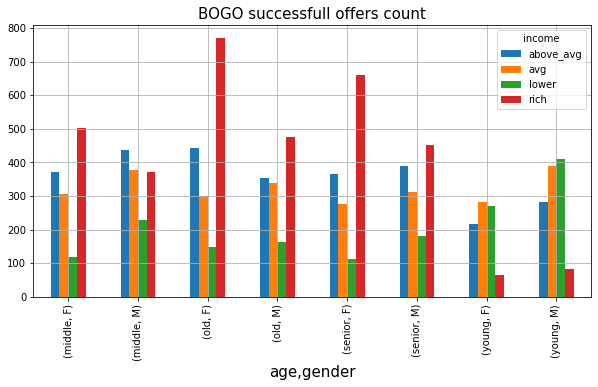

In [235]:
bogo_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==1]
a = bogo_success_df.groupby(['age', 'gender', 'income'])['age'].count().unstack()
a.plot.bar(figsize = (10,5), title = 'BOGO successfull offers count', grid = True)
a

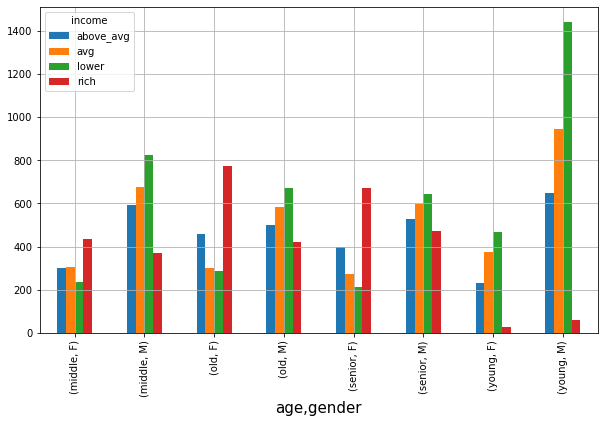

In [228]:
bogo_not_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==0]
b = bogo_not_success_df.groupby(['age', 'gender', 'income'])['age'].count().unstack()
b.plot.bar(figsize = (10,6),title = 'BOGO successfull offers count',  grid = True)


In [219]:
c = a+b
c

income         above_avg   avg  lower  rich
age    gender                              
middle F             674   611    358   939
       M            1030  1055   1054   744
old    F             903   601    436  1545
       M             851   923    836   894
senior F             765   547    325  1333
       M             914   909    824   921
young  F             449   657    738    94
       M             929  1331   1850   143

income         above_avg   avg  lower  rich
age    gender                              
middle F            55.0  50.0   34.0  53.0
       M            42.0  36.0   22.0  50.0
old    F            49.0  50.0   34.0  50.0
       M            41.0  37.0   20.0  53.0
senior F            48.0  50.0   35.0  50.0
       M            42.0  34.0   22.0  49.0
young  F            49.0  43.0   37.0  70.0
       M            30.0  29.0   22.0  57.0

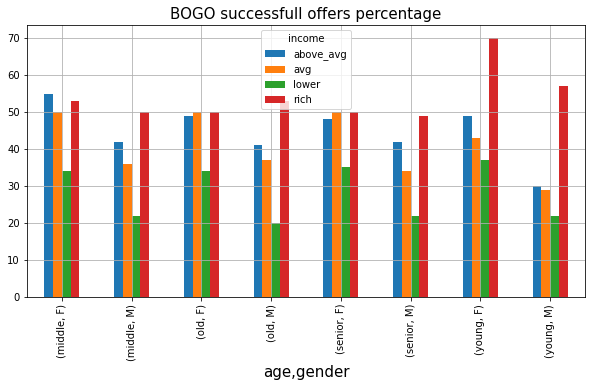

In [236]:
percentage_offer_complete = np.round(a/c * 100, decimals = 0)
percentage_offer_complete.plot.bar(figsize = (10,5),title = 'BOGO successfull offers percentage', grid = True)
percentage_offer_complete

From above graphs we can wee that the Females prefer BOGO more than men. If you will look at the graphs carefully, you will see that Rich category has offer completion percentage of nearly 45% - 55% for all the demographic groups and females in the age group of senior and old makes most number of purchases for BOGO offers. So we will say that Rich, females in the age group of Senior and old like BOGO offers more.

This doesnot give a very clear picture of which type of offer is prefered by the members. Lets deep dive into BOGO offers and see which of the four bogo offers were prefered more by customers by the customers.
Also we have seen that females make more purchases than males so now we will remove the gender category and concentrate on age and income.

offer_id
1.0    6590
2.0    6521
4.0    6584
9.0    6488
Name: offer_id, dtype: int64


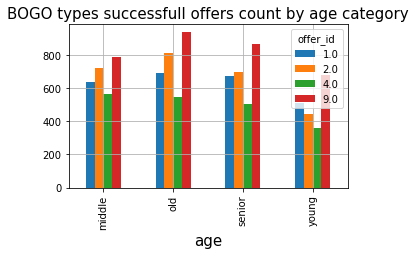

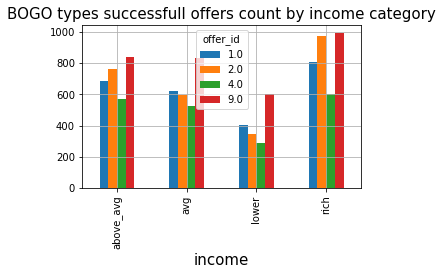

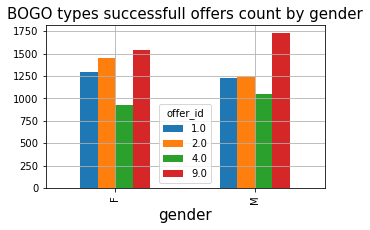

In [257]:
print(bogo_offers_df.groupby('offer_id')['offer_id'].count())
#bogo_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==1]
bogo_type_age_success_count = bogo_success_df.groupby(['age', 'offer_id'])['age'].count().unstack()
bogo_type_age_success_count.plot.bar(figsize = (5,3), title = 'BOGO types successfull offers count by age category', grid = True)
bogo_type_income_success_count = bogo_success_df.groupby(['income', 'offer_id'])['age'].count().unstack()
bogo_type_income_success_count.plot.bar(figsize = (5,3), title = 'BOGO types successfull offers count by income category', grid = True)
bogo_type_gender_success_count = bogo_success_df.groupby(['gender', 'offer_id'])['age'].count().unstack()
bogo_type_gender_success_count.plot.bar(figsize = (5,3), title = 'BOGO types successfull offers count by gender', grid = True)

#bogo_not_success_df = bogo_offers_df[bogo_offers_df['offer_successfull'] ==0]
bogo_type_age_not_success_count = bogo_not_success_df.groupby(['age', 'offer_id'])['age'].count().unstack()
bogo_type_income_not_success_count = bogo_not_success_df.groupby(['income', 'offer_id'])['age'].count().unstack()
bogo_type_gender_not_success_count = bogo_not_success_df.groupby(['gender', 'offer_id'])['age'].count().unstack()

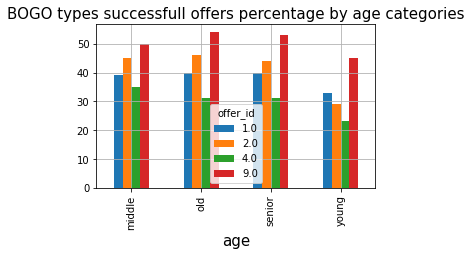

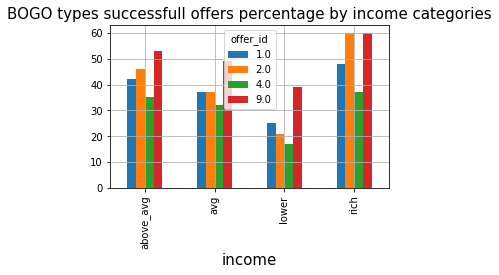

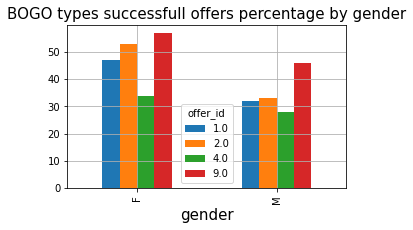

In [254]:
percentage_offer_age_type_complete = np.round((bogo_type_age_success_count/(bogo_type_age_success_count+bogo_type_age_not_success_count)) * 100, decimals = 0)
percentage_offer_age_type_complete.plot.bar(figsize = (5,3),title = 'BOGO types successfull offers percentage by age categories', grid = True)
percentage_offer_income_type_complete = np.round((bogo_type_income_success_count/(bogo_type_income_success_count+bogo_type_income_not_success_count)) * 100, decimals = 0)
percentage_offer_income_type_complete.plot.bar(figsize = (5,3),title = 'BOGO types successfull offers percentage by income categories', grid = True)
percentage_offer_gender_type_complete = np.round((bogo_type_gender_success_count/(bogo_type_gender_success_count+bogo_type_gender_not_success_count)) * 100, decimals = 0)
percentage_offer_gender_type_complete.plot.bar(figsize = (5,3),title = 'BOGO types successfull offers percentage by gender', grid = True)


Clearly offer 9 pis favorite amongst customers.

Now we will create a machine learning model to pridict which offers sent to customers will be successfully completed. To comlete this task I will create 3 model using 1. Logistics regression , 2. Random forrest classifier. Once I have initial benchmark of accuracy and F1 score, I will further tune these models and after that we will choose the one with best accuracy and F1 score.

We will give F1 score more preference as it is a more balance scale and gives weightage to both precision and recall.

In [275]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53201 entries, 0 to 272760
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index_new           53201 non-null  int32  
 1   member_id           53201 non-null  float64
 2   event               53201 non-null  object 
 3   time                53201 non-null  int64  
 4   offer_id            53201 non-null  float64
 5   transaction_amount  53201 non-null  float64
 6   transaction_reward  53201 non-null  float64
 7   gender              53201 non-null  object 
 8   age                 53201 non-null  object 
 9   income              53201 non-null  object 
 10  loyalty             53201 non-null  object 
 11  offer_reward        53201 non-null  float64
 12  difficulty          53201 non-null  float64
 13  duration            53201 non-null  float64
 14  offer_type          53201 non-null  object 
 15  email               53201 non-null  float64
 16  mob

Before we start making model we need to delete few columns which dont have any value add and create dummy variable from few columns.
1. Delete : Index_new, member_id, transaction_amount, transaction_reward
2. create dummy variables for : Gender, age, income, loyalty, offer_type

In [276]:
#delete unwanted columns
model_df = model_df.drop(['index_new', 'member_id','time', 'event', 'transaction_amount','transaction_reward'], axis = 1)

In [277]:
#dataset for random forrest classifier:
model_rfc_data = model_df.copy()

Creating dummy variables for random forrest classifier dataset

In [278]:
#gender dummy
gender = pd.get_dummies(model_rfc_data['gender'],prefix = "gender", prefix_sep = "-")
model_rfc_data = pd.concat([model_rfc_data,gender],axis=1)

#age dummy
age = pd.get_dummies(model_rfc_data['age'],prefix = "age", prefix_sep = "-")
model_rfc_data = pd.concat([model_rfc_data,age],axis=1)

#income dummy
income = pd.get_dummies(model_rfc_data['income'],prefix = "income", prefix_sep = "-")
model_rfc_data = pd.concat([model_rfc_data,income],axis=1)

#loyalty dummy
loyalty = pd.get_dummies(model_rfc_data['loyalty'],prefix = "loyalty", prefix_sep = "-")
model_rfc_data = pd.concat([model_rfc_data,loyalty],axis=1)

#offer_type dummy
offer_type = pd.get_dummies(model_rfc_data['offer_type'],prefix = "offer_type", prefix_sep = "-")
model_rfc_data = pd.concat([model_rfc_data,offer_type],axis=1)

In [312]:
model_rfc_data.head()

offer_id  offer_reward  difficulty  duration  email  mobile  social  web  \
0        4.0           5.0         5.0     168.0    1.0     1.0     0.0  1.0   
10       1.0          10.0        10.0     168.0    1.0     1.0     1.0  0.0   
12       9.0           5.0         5.0     120.0    1.0     1.0     1.0  1.0   
18      10.0           2.0        10.0     168.0    1.0     1.0     0.0  1.0   
23       4.0           5.0         5.0     168.0    1.0     1.0     0.0  1.0   

    offer_successfull  view_successfull  ...  income-above_avg  income-avg  \
0                 1.0               1.0  ...                 0           0   
10                1.0               1.0  ...                 0           0   
12                0.0               1.0  ...                 0           0   
18                0.0               1.0  ...                 1           0   
23                1.0               1.0  ...                 1           0   

    income-lower  income-rich  loyalty-recent  loyalty-seasoned  \
0              0            1               0                 1   
10             0            1               0                 1   
12             0            1               0                 1   
18             0            0               0                 0   
23             0            0               0                 0   

    loyalty-very_recent  loyalty-vintage  offer_type-bogo  offer_type-discount  
0                     0                0                1                    0  
10                    0                0                1                    0  
12                    0                0                1                    0  
18                    1                0                0                    1  
23                    1                0                1                    0  

[5 rows x 27 columns]

In [281]:
model_rfc_data =  model_rfc_data.drop(['gender', 'age', 'loyalty', 'offer_type', 'income'], axis = 1)

In [283]:
X = model_rfc_data.drop(['offer_successfull'], axis = 1)
Y = model_rfc_data['offer_successfull']
#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [288]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))
#accuracy_score(Y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77      7747
         1.0       0.68      0.71      0.70      5554

    accuracy                           0.74     13301
   macro avg       0.73      0.74      0.74     13301
weighted avg       0.74      0.74      0.74     13301



Random forrest  classifier produces an accuracy of : 74% and f1 score of 0.70 
Now lets try and increase the performance of our classifier 

In [289]:
param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [10,20,25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid)
grid_search.fit(X_train, Y_train)
grid_search.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 40}

Tuning our model with the best parameters: I will run 5 iterations with various combinations of any two parameters here:
1. 'max_depth': 10, 'n_estimators': 40
2. 'min_samples_split': 2, 'n_estimators': 40
3. 'max_features': 'auto', 'min_samples_leaf': 15, 
4. 'max_depth': 10, 'min_samples_leaf': 15
5. 'min_samples_leaf': 15, 'min_samples_split': 2

In [301]:
#iteration one 1. 'max_depth': 10, 'n_estimators': 40
clf = RandomForestClassifier(max_depth= 10, n_estimators= 40,min_samples_split = 2,max_features= 'auto',min_samples_leaf=15, random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      7747
         1.0       0.69      0.70      0.70      5554

    accuracy                           0.75     13301
   macro avg       0.74      0.74      0.74     13301
weighted avg       0.75      0.75      0.75     13301



Iteration one result: Accuracy increases to 75% but F1 score remains same 

In [294]:
#iteration 2.. 'max_depth': 10, 'n_estimators': 40
clf = RandomForestClassifier(min_samples_split = 2, n_estimators= 40, random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77      7747
         1.0       0.68      0.71      0.69      5554

    accuracy                           0.74     13301
   macro avg       0.73      0.73      0.73     13301
weighted avg       0.74      0.74      0.74     13301



In [296]:
#iteration 3.. 'max_features': 'auto', 'min_samples_leaf': 15
clf = RandomForestClassifier(max_features = 'auto', min_samples_leaf = 15, random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      7747
         1.0       0.69      0.71      0.70      5554

    accuracy                           0.74     13301
   macro avg       0.74      0.74      0.74     13301
weighted avg       0.75      0.74      0.74     13301



In [297]:
#iteration 4.. 'max_depth': 10, 'min_samples_leaf': 15
clf = RandomForestClassifier(max_depth = 10 , min_samples_leaf = 15, random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      7747
         1.0       0.69      0.70      0.70      5554

    accuracy                           0.75     13301
   macro avg       0.74      0.74      0.74     13301
weighted avg       0.75      0.75      0.75     13301



In [315]:
#iteration 5.. 'min_samples_leaf': 15, 'min_samples_split': 2
clf = RandomForestClassifier(min_samples_leaf = 15 , min_samples_split = 2, random_state=42)
clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78      7747
         1.0       0.69      0.71      0.70      5554

    accuracy                           0.74     13301
   macro avg       0.74      0.74      0.74     13301
weighted avg       0.75      0.74      0.74     13301

